In [1]:
import os
import tejapi

os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'YOUR KEY'

import TejToolAPI
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import alphalens
from zipline.data import bundles
from zipline.pipeline import Pipeline
from logbook import Logger, StderrHandler, INFO
import sys
import time
import warnings

warnings.filterwarnings('ignore')
print(sys.executable)
print(sys.version)
print(sys.prefix)

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\python.exe
3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]
C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing


In [2]:
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         record,
                         schedule_function,
                         set_slippage,
                         set_commission,
                         order_target,
                         order_target_percent,
                         set_benchmark,
                         symbol,
                         get_datetime,
                         get_open_orders,
                         cancel_order,
                         order,
                         set_max_leverage,
                         cancel_order
                         )
import zipline

from zipline.finance import commission, slippage
from zipline.finance.commission import PerDollar , NoCommission, PerTrade, PerShare, PerContract
from zipline.finance.slippage import VolumeShareSlippage, NoSlippage, FixedBasisPointsSlippage, FixedSlippage
from zipline.utils.events import date_rules, time_rules
from collections import defaultdict

from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar

from zipline.api import future_symbol,  \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target
from functools import partial
from zipline.assets import Equity, Future

# 台指期貨-小台散戶多空比情緒指標交易策略實證研究（2018–2024）

## 研究概念與策略設計

本研究旨在實證 **小台散戶多空比情緒指標交易策略** 於台灣加權股價指數期貨（簡稱「台指期貨」）市場的獲利可行性，資料期間涵蓋 2018 年至 2024 年。

此交易策略係建立於 **散戶缺乏資訊優勢** 的假設，認為散戶因缺乏專業的金融知識與資訊優勢，往往錯估未來市場的行情走勢，導致其操作與市場趨勢常常相左。

- 當市場價格上漲時，散戶錯估行情反轉下跌建立空單部位，散戶的部位與市場走勢呈現負向關係因而進場做多。
- 當市場價格下跌時，散戶錯估行情反轉上漲建立多單部位，散戶的部位與市場走勢呈現負向關係因而多單平倉。

本擬運用**TQuant Lab**的投資研究平台，進行指數期貨資料撈取，以及逆勢交易策略建構、回測與績效分析。


## 導入資料
- 設定樣本為台指期貨(TX)、小台指期貨(MTX)
- 設定起訖日為2018-2024年

In [3]:
ticker1 = 'IR0001 IX0001'
ticker2 = 'TX MTX'

os.environ['ticker'] = ticker1
os.environ['future'] = ticker2
os.environ['mdate'] = '20180101 20250410'
!zipline ingest -b tquant_future

Merging daily equity files:


C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
[2025-05-28 09:41:59.267442] INFO: zipline.data.bundles.core: Ingesting tquant_future.
[2025-05-28 09:42:05.251608] INFO: zipline.data.bundles.core: Ingest tquant_future successfully.


## 導入zipline 回測時需要的模組

In [4]:
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         record,
                         schedule_function,
                         set_slippage,
                         set_commission,
                         order_target,
                         order_target_percent,
                         set_benchmark,
                         symbol,
                         get_datetime,
                         get_open_orders,
                         cancel_order,
                         order,
                         set_max_leverage,
                         cancel_order
                         )
import zipline

from zipline.finance import commission, slippage
from zipline.finance.commission import PerDollar , NoCommission, PerTrade, PerShare, PerContract
from zipline.finance.slippage import VolumeShareSlippage, NoSlippage, FixedBasisPointsSlippage
from zipline.utils.events import date_rules, time_rules

from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar

from zipline.api import future_symbol,  \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target

from zipline.TQresearch.futures_package import retail_long_short_ratio, get_stock_futures_universe

## 交易成本與交易策略設定

### 1. 交易成本設定

- **券商手續費**：每次每口單邊收取 1 點（等同 200元）
- **滑價成本（Slippage）**：每次每口單邊假設滑價為 3 點（等同600元）
  
### 2. 交易策略設定

散戶小台多空比指標：運用小台指期貨全市場未平倉量分別扣除三大法人空單、多單的未平倉量而得出散戶的多單與空單部位，最後計算散戶淨多單占全市場未平倉量的比率。

買進：散戶小台多空比指標 < 0。

賣出：散戶小台多空比指標 > 0。


- #### 進場條件：
    - 條件1. : $ \text{Position}_{t} = 0 $
    - 條件2. : $ \text{Retail Invest Ratio}_{t} < 0 $  
   
   當條件1.和條件2.同時成立時，進場做多一口台指期貨。

- #### 出場條件：
    - 條件1. : $ \text{Position}_{t} > 0 $
    - 條件2. : $ \text{Retail Invest Ratio}_{t} > 0 $  
      
   
   當條件1.和條件2.同時成立時，賣出一口台指期貨。


- #### 到期日轉倉

    於當月近月合約到期日時，以當日台指期貨近月收盤價平倉，並於隔日以新合約收盤價建倉。

## 建立散戶小台多空比情緒指標

In [5]:
df_retail_long_short_ratio = retail_long_short_ratio(root_symbol='MTX')

[2025-05-28 09:43:36.132026]: WARNING: _can_order_asset: Cannot place order for TX201801, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-01-18 00:00:00+00:00.
[2025-05-28 09:43:36.264951]: WARNING: _can_order_asset: Cannot place order for TX201803, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-03-22 00:00:00+00:00.
[2025-05-28 09:43:36.337908]: WARNING: _can_order_asset: Cannot place order for TX201804, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-04-19 00:00:00+00:00.
[2025-05-28 09:43:36.406883]: WARNING: _can_order_asset: Cannot place order for TX201805, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-05-17 00:00:00+00:00.
[2025-05-28 09:43:36.549787]: WARNING: _can_order_asset: Cannot place order for TX201807, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-07-19 00:00:00+00:00.
[2025-05-2

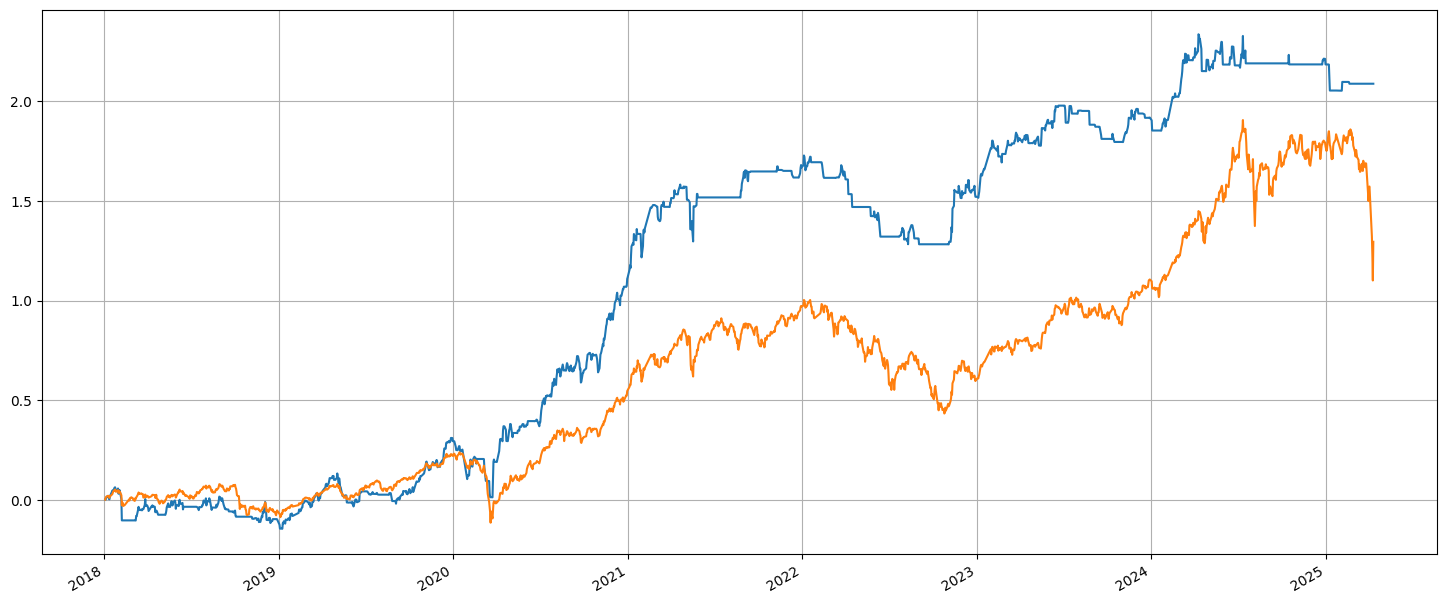

In [6]:
def initialize(context):

    context.root_symbol = 'TX'
    # 設定 benchmark
    context.set_benchmark(symbol('IR0001'))
    # 交易成本
    set_commission(equities = PerDollar(cost=0.003),futures = PerContract(cost={'TX':200},exchange_fee=0))
    set_slippage(equities = NoSlippage(),futures = FixedSlippage(spread=6.0))   
    # Schedule daily trading
    context.continue_fut = continuous_future(context.root_symbol, offset=0, roll='calendar', adjustment='add')
    # Schedule daily position rolling
    schedule_function(roll_futures, date_rules.every_day(), time_rules.market_close())   
    # calculate retail_ls_ratio
    context.retail_ls_ratio = df_retail_long_short_ratio

def roll_futures(context, data):
    open_orders = get_open_orders()
    for held_contract in context.portfolio.positions:
        if held_contract in open_orders:
            continue
        days_to_auto_close = (held_contract.auto_close_date.date() - data.current_session.date()).days
        if days_to_auto_close > 10:
            continue
        # Make a continuation
        continuation = continuous_future(
            held_contract.root_symbol, offset=0, roll="calendar", adjustment="add"
        )
        continuation_contract = data.current(continuation, "contract")
        if continuation_contract != held_contract:
            pos_size = context.portfolio.positions[held_contract].amount
            order_target(held_contract, 0)
            order_target(continuation_contract, pos_size)

def handle_data(context, data):
    
    today = data.current_session#.date()    
    sentiment_index1 = context.retail_ls_ratio.loc[today]
    score = 0        
    contract = data.current(context.continue_fut, 'contract')  
    
    market_positions = len(context.portfolio.positions)
    if market_positions<=0 and sentiment_index1<score:        
        order_target(contract,1)    

    if market_positions>0 and sentiment_index1>score:
        order_target(contract,0)
        
def analyze(context=None, results=None):
    # Plot the portfolio and asset data.
    results.algorithm_period_return.plot()
    results.benchmark_period_return.plot()
    plt.grid(True)
    # Show the plot.
    plt.gcf().set_size_inches(18, 8)
    plt.show()

capital_base = 1e6 
calendar_name = 'TEJ' 
start_dt = pd.Timestamp('2018-01-02', tz='utc') 
end_dt = pd.Timestamp('2025-04-10', tz='utc')

# Running a Backtest
results = run_algorithm(start=start_dt, 
                        end=end_dt, 
                        initialize=initialize, 
                        handle_data = handle_data, 
                        capital_base=capital_base, 
                        analyze = analyze,
                        data_frequency='daily', 
                        bundle='tquant_future', 
                        trading_calendar=get_calendar(calendar_name), ) 

#results[['starting_cash','capital_used','ending_cash','long_exposure','longs_count','portfolio_value','futures_contract','futures_price','security_price']]

# 台指期貨逆勢交易策略實證研究（2018–2024）

## 研究概念與策略設計

本研究旨在實證 **逆勢交易策略（Contrarian Trading Strategy）** 於台灣加權股價指數期貨（簡稱「台指期貨」）市場的獲利可行性，資料期間涵蓋 2018 年至 2024 年。

逆勢交易策略係建立於 **均值回歸（Mean Reversion）** 假設，認為市場價格在短期出現過度波動後，傾向回歸其歷史均值或合理價值。

- 當價格短期內大幅上漲，可能出現過熱，後市可能下跌。
- 當價格短期內大幅下跌，可能為過度悲觀，後市可能反彈。

本擬運用**TQuant Lab**的投資研究平台，進行指數期貨資料撈取，以及逆勢交易策略建構、回測與績效分析。

## 導入資料
- 設定樣本為台指期貨(TX)、小台指期貨(MTX)
- 設定起訖日為2018-2024年

In [7]:
ticker1 = 'IR0001 IX0001'
ticker2 = 'TX MTX'

os.environ['ticker'] = ticker1
os.environ['future'] = ticker2
os.environ['mdate'] = '20180101 20250410'
#!zipline ingest -b tquant_future

## 導入zipline 回測時需要的模組

In [8]:
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         record,
                         schedule_function,
                         set_slippage,
                         set_commission,
                         order_target,
                         order_target_percent,
                         set_benchmark,
                         symbol,
                         get_datetime,
                         get_open_orders,
                         cancel_order,
                         order,
                         set_max_leverage,
                         cancel_order
                         )
import zipline
from zipline.finance import commission, slippage
from zipline.finance.commission import PerDollar , NoCommission, PerTrade, PerShare, PerContract 
from zipline.finance.slippage import VolumeShareSlippage, NoSlippage, FixedBasisPointsSlippage, FixedSlippage
from zipline.utils.events import date_rules, time_rules
from collections import defaultdict

from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar

from zipline.api import future_symbol,  \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target
from functools import partial
from zipline.assets import Equity, Future

# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets


## 交易成本與交易策略設定

### 1. 交易成本設定

- **券商手續費**：每次每口單邊收取 1 點（等同 200元）
- **滑價成本（Slippage）**：每次每口單邊假設滑價為 3 點（等同600元）
  
### 2. 交易策略設定

- #### 進場條件：
    - 條件1. : $ \text{EMA}_{20} > \text{EMA}_{40}$
    - 條件2. : $ P_t \leq P_{t}^{\max(20)} - 3 \times \sigma_{P,20} $
      
   
   當條件1.和條件2.同時成立時，視為價格大幅修正，進場做多一口台指期貨。

- #### 出場條件：
    - 條件1. : $ \text{EMA}_{20} < \text{EMA}_{40}$
    - 條件2. : $ \text{Holding\_Period} > 20 $
      
   
   當條件1.或條件2.同時成立時，賣出一口台指期貨。


- #### 到期日轉倉

    於當月近月合約到期日時，以當日台指期貨近月收盤價平倉，並於隔日以新合約收盤價建倉。


HTML(value='')

[2025-05-28 09:43:44.250960]: WARNING: _can_order_asset: Cannot place order for TX201806, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-06-21 00:00:00+00:00.


Future(102 [TX201806]) 平倉出場於轉倉
Future(103 [TX201807]) 買進進場於轉倉


[2025-05-28 09:43:44.659483]: WARNING: _can_order_asset: Cannot place order for TX201808, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-08-16 00:00:00+00:00.


Future(104 [TX201808]) 平倉出場於轉倉
Future(105 [TX201809]) 買進進場於轉倉


[2025-05-28 09:43:44.948052]: WARNING: _can_order_asset: Cannot place order for TX201809, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-09-20 00:00:00+00:00.


Future(105 [TX201809]) 平倉出場於轉倉
Future(106 [TX201810]) 買進進場於轉倉


[2025-05-28 09:43:46.388337]: WARNING: _can_order_asset: Cannot place order for TX201905, as it has de-listed. Any existing positions for this asset will be liquidated on 2019-05-16 00:00:00+00:00.
[2025-05-28 09:43:46.576454]: WARNING: _can_order_asset: Cannot place order for TX201906, as it has de-listed. Any existing positions for this asset will be liquidated on 2019-06-20 00:00:00+00:00.


Future(113 [TX201905]) 平倉出場於轉倉
Future(114 [TX201906]) 買進進場於轉倉
Future(114 [TX201906]) 平倉出場於轉倉
Future(115 [TX201907]) 買進進場於轉倉


[2025-05-28 09:43:46.972271]: WARNING: _can_order_asset: Cannot place order for TX201908, as it has de-listed. Any existing positions for this asset will be liquidated on 2019-08-22 00:00:00+00:00.


Future(116 [TX201908]) 平倉出場於轉倉
Future(117 [TX201909]) 買進進場於轉倉


[2025-05-28 09:43:47.617223]: WARNING: _can_order_asset: Cannot place order for TX201911, as it has de-listed. Any existing positions for this asset will be liquidated on 2019-11-21 00:00:00+00:00.


Future(119 [TX201911]) 平倉出場於轉倉
Future(120 [TX201912]) 買進進場於轉倉


[2025-05-28 09:43:48.004606]: WARNING: _can_order_asset: Cannot place order for TX202001, as it has de-listed. Any existing positions for this asset will be liquidated on 2020-01-16 00:00:00+00:00.
[2025-05-28 09:43:48.163314]: WARNING: _can_order_asset: Cannot place order for TX202002, as it has de-listed. Any existing positions for this asset will be liquidated on 2020-02-20 00:00:00+00:00.


Future(121 [TX202001]) 平倉出場於轉倉
Future(122 [TX202002]) 買進進場於轉倉
Future(122 [TX202002]) 平倉出場於轉倉
Future(123 [TX202003]) 買進進場於轉倉


[2025-05-28 09:43:48.936362]: WARNING: _can_order_asset: Cannot place order for TX202006, as it has de-listed. Any existing positions for this asset will be liquidated on 2020-06-18 00:00:00+00:00.


Future(126 [TX202006]) 平倉出場於轉倉
Future(127 [TX202007]) 買進進場於轉倉


[2025-05-28 09:43:49.166271]: WARNING: _can_order_asset: Cannot place order for TX202007, as it has de-listed. Any existing positions for this asset will be liquidated on 2020-07-16 00:00:00+00:00.
[2025-05-28 09:43:49.582467]: WARNING: _can_order_asset: Cannot place order for TX202009, as it has de-listed. Any existing positions for this asset will be liquidated on 2020-09-17 00:00:00+00:00.
[2025-05-28 09:43:49.583467]: WARNING: _can_order_asset: Cannot place order for TX202009, as it has de-listed. Any existing positions for this asset will be liquidated on 2020-09-17 00:00:00+00:00.
[2025-05-28 09:43:49.758778]: WARNING: _can_order_asset: Cannot place order for TX202010, as it has de-listed. Any existing positions for this asset will be liquidated on 2020-10-22 00:00:00+00:00.


Future(129 [TX202009]) 平倉出場於轉倉
Future(130 [TX202010]) 買進進場於轉倉
Future(130 [TX202010]) 平倉出場於轉倉
Future(131 [TX202011]) 買進進場於轉倉


[2025-05-28 09:43:49.992771]: WARNING: _can_order_asset: Cannot place order for TX202011, as it has de-listed. Any existing positions for this asset will be liquidated on 2020-11-19 00:00:00+00:00.


Future(131 [TX202011]) 平倉出場於轉倉
Future(132 [TX202012]) 買進進場於轉倉


[2025-05-28 09:43:50.516651]: WARNING: _can_order_asset: Cannot place order for TX202102, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-02-18 00:00:00+00:00.


Future(134 [TX202102]) 平倉出場於轉倉
Future(135 [TX202103]) 買進進場於轉倉


[2025-05-28 09:43:51.117020]: WARNING: _can_order_asset: Cannot place order for TX202105, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-05-20 00:00:00+00:00.


Future(137 [TX202105]) 平倉出場於轉倉
Future(138 [TX202106]) 買進進場於轉倉


[2025-05-28 09:43:51.526529]: WARNING: _can_order_asset: Cannot place order for TX202107, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-07-22 00:00:00+00:00.


Future(139 [TX202107]) 平倉出場於轉倉
Future(140 [TX202108]) 買進進場於轉倉


[2025-05-28 09:43:51.931535]: WARNING: _can_order_asset: Cannot place order for TX202109, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-09-16 00:00:00+00:00.
[2025-05-28 09:43:51.931535]: WARNING: _can_order_asset: Cannot place order for TX202109, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-09-16 00:00:00+00:00.
[2025-05-28 09:43:52.106941]: WARNING: _can_order_asset: Cannot place order for TX202110, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-10-21 00:00:00+00:00.


Future(141 [TX202109]) 平倉出場於轉倉
Future(142 [TX202110]) 買進進場於轉倉
Future(142 [TX202110]) 平倉出場於轉倉
Future(143 [TX202111]) 買進進場於轉倉


[2025-05-28 09:43:52.521052]: WARNING: _can_order_asset: Cannot place order for TX202112, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-12-16 00:00:00+00:00.


Future(144 [TX202112]) 平倉出場於轉倉
Future(145 [TX202201]) 買進進場於轉倉


[2025-05-28 09:43:52.880653]: WARNING: _can_order_asset: Cannot place order for TX202202, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-02-17 00:00:00+00:00.
[2025-05-28 09:43:53.030985]: WARNING: _can_order_asset: Cannot place order for TX202203, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-03-17 00:00:00+00:00.


Future(146 [TX202202]) 平倉出場於轉倉
Future(147 [TX202203]) 買進進場於轉倉


[2025-05-28 09:43:55.144135]: WARNING: _can_order_asset: Cannot place order for TX202212, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-12-22 00:00:00+00:00.


Future(156 [TX202212]) 平倉出場於轉倉
Future(157 [TX202301]) 買進進場於轉倉


[2025-05-28 09:43:55.691081]: WARNING: _can_order_asset: Cannot place order for TX202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.


Future(159 [TX202303]) 平倉出場於轉倉
Future(160 [TX202304]) 買進進場於轉倉


[2025-05-28 09:43:56.176641]: WARNING: _can_order_asset: Cannot place order for TX202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.


Future(161 [TX202305]) 平倉出場於轉倉
Future(162 [TX202306]) 買進進場於轉倉


[2025-05-28 09:43:56.724500]: WARNING: _can_order_asset: Cannot place order for TX202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.


Future(163 [TX202307]) 平倉出場於轉倉
Future(164 [TX202308]) 買進進場於轉倉


[2025-05-28 09:43:56.976199]: WARNING: _can_order_asset: Cannot place order for TX202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.


Future(164 [TX202308]) 平倉出場於轉倉
Future(165 [TX202309]) 買進進場於轉倉


[2025-05-28 09:43:57.420701]: WARNING: _can_order_asset: Cannot place order for TX202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.


Future(166 [TX202310]) 平倉出場於轉倉
Future(167 [TX202311]) 買進進場於轉倉


[2025-05-28 09:43:58.046876]: WARNING: _can_order_asset: Cannot place order for TX202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.


Future(169 [TX202401]) 平倉出場於轉倉
Future(170 [TX202402]) 買進進場於轉倉


[2025-05-28 09:43:58.704563]: WARNING: _can_order_asset: Cannot place order for TX202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 09:43:58.893088]: WARNING: _can_order_asset: Cannot place order for TX202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.


Future(172 [TX202404]) 平倉出場於轉倉
Future(173 [TX202405]) 買進進場於轉倉


[2025-05-28 09:44:00.240960]: WARNING: _can_order_asset: Cannot place order for TX202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.


Future(179 [TX202411]) 平倉出場於轉倉
Future(180 [TX202412]) 買進進場於轉倉


[2025-05-28 09:44:00.686460]: WARNING: _can_order_asset: Cannot place order for TX202501, as it has de-listed. Any existing positions for this asset will be liquidated on 2025-01-16 00:00:00+00:00.


Future(181 [TX202501]) 平倉出場於轉倉
Future(182 [TX202502]) 買進進場於轉倉


[2025-05-28 09:44:00.941017]: WARNING: _can_order_asset: Cannot place order for TX202502, as it has de-listed. Any existing positions for this asset will be liquidated on 2025-02-20 00:00:00+00:00.
[2025-05-28 09:44:01.278277]: INFO: handle_simulation_end: Simulated 1766 trading days
first open: 2018-01-02 01:01:00+00:00
last close: 2025-04-10 05:30:00+00:00


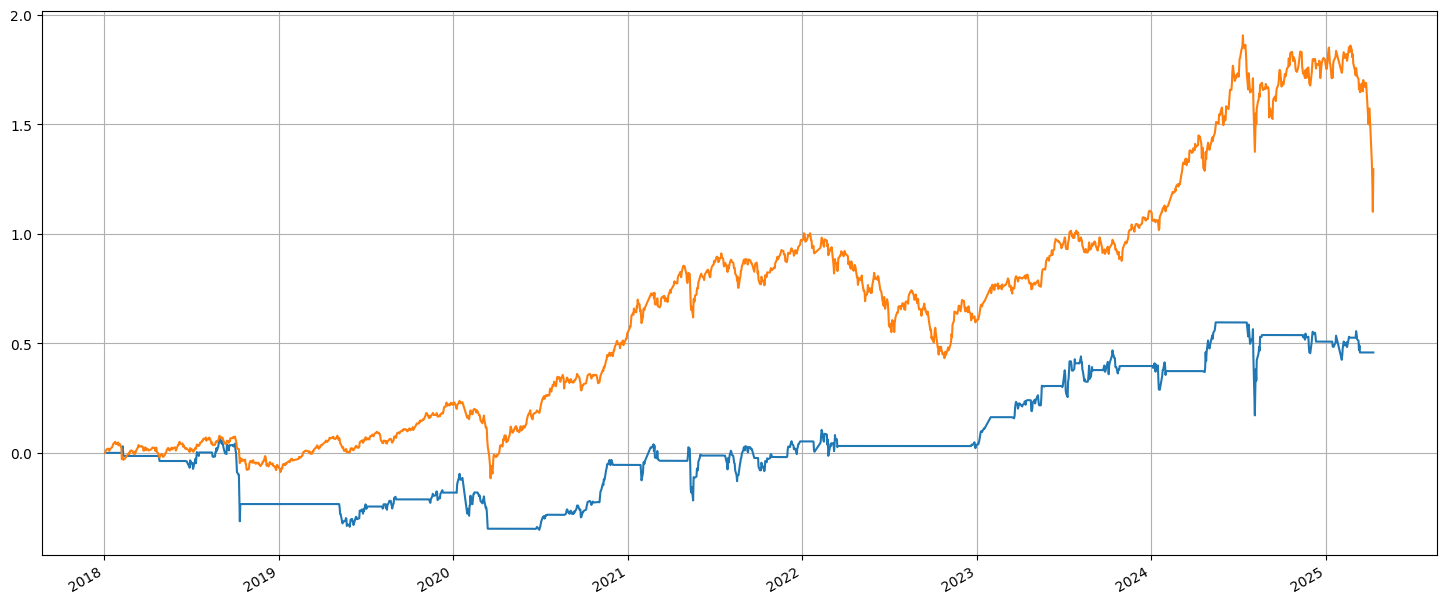

In [9]:
out = widgets.HTML()
display(out)

"""
Model Settings
"""
vola_window = 40
slow_ma = 80
fast_ma = 40
risk_factor = 0.02
high_window = 20
days_to_hold = 20
dip_buy = -3

def report_result(context, data):
    context.months += 1
    today = zipline.api.get_datetime().date()
    # Calculate annualized return so far
    ann_ret = (
        np.power(
            context.portfolio.portfolio_value / starting_portfolio, 12 / context.months
        )
        - 1
    )
    
    # Update the text
    out.value = """{} We have traded <b>{}</b> months 
    and the annualized return is <b>{:.2%}</b>""".format(
        today, context.months, ann_ret
    )
    
def initialize(context):

    # 設定 benchmark
    context.set_benchmark(symbol('IR0001'))
    # 交易成本
    context.enable_commission = True
    context.enable_slippage = True   
    
    if context.enable_commission:
        comm_model = PerContract(cost={'TX':200},exchange_fee=0)
    else:
        comm_model = PerContract(cost=0.0,exchange_fee=0)
        
    set_commission(futures=comm_model)
    
    if context.enable_slippage:
        slippage_model = FixedSlippage(spread=6.0)
    else:
        slippage_model=FixedSlippage(spread=0.0)      
        
    set_slippage(futures=slippage_model)

    # construct continues futures
    tx1 = continuous_future('TX', offset=0, roll='calendar', adjustment='add')
    context.continue_tx1 = tx1

    context.universe = [tx1]
    context.bars_held = {market.root_symbol: 0 for market in context.universe} 
    
    # Schedule daily trading
    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())
    
    context.months = 0  

    # Schedule monthly report output
    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open(),
    )

def roll_futures(context, data):
    
    open_orders = get_open_orders()
    # rolling positions
    for held_contract in context.portfolio.positions:
        if not isinstance(held_contract, Future):
            continue
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders: 
            continue
        # Save some time by only checking rolls for
        # contracts expiring in the next week        
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days
        if days_to_auto_close > 5:
            continue  
     
        # Get the current contract of the continuation
        continuation_contract = data.current( context.continue_tx1, "contract")
          
        if continuation_contract != held_contract:
            # Check how many contracts we hold
            pos_size = context.portfolio.positions[held_contract].amount         
            # Close current position
            print(f'{held_contract} 平倉出場於轉倉')
            order_target(held_contract, 0)
            # Open new position
            print(f'{continuation_contract} 買進進場於轉倉')
            order_target(continuation_contract, pos_size)


def position_size(portfolio_value, std, pv):
    target_variation = portfolio_value * risk_factor
    contract_variation = std * pv
    contracts = target_variation / contract_variation
    # Return rounded down number.
    return int(np.nan_to_num(contracts))
    
def daily_trade(context, data):
    
    hist = data.history(
        context.universe, 
        fields=['close', 'volume'], 
        frequency='1d', 
        bar_count=250,
    )    
    # Calculate the trend
    hist['trend'] = hist['close'].ewm(span=fast_ma).mean() > hist['close'].ewm(span=slow_ma).mean()

    open_pos = {pos.root_symbol: pos for pos in context.portfolio.positions}         
    
    for continuation in context.universe:
        root = continuation.root_symbol

        # Slice off history for this market
        h = hist.xs(continuation, level=1)
        # Calculate volatility
        std = h.close.diff()[-vola_window:].std()
        
        if root in open_pos: # Check open positions first.
            context.bars_held[root] += 1 # One more day held
            
            if context.bars_held[root] >= 20:
                # Held for a month, exit                
                contract = open_pos[root]
                order_target(contract,0)

            elif h['trend'].iloc[-1] == False:
                # Trend changed, exit.
                contract = open_pos[root]
                order_target(contract,0)

        else: # Check for new entries            
            if h['trend'].iloc[-1]: 
                # Calculate the pullback
                pullback = (
                    h['close'].values[-1] - np.max(h['close'].values[-high_window:])
                    ) / std                
                if pullback < dip_buy:                    
                    # Get the current contract
                    contract = data.current(continuation, 'contract')                    
                    # Calculate size
                    contracts_to_trade = position_size( \
                                           context.portfolio.portfolio_value, \
                                           std, \
                                           contract.price_multiplier)                    
                    # Trade
                    order_target(contract, contracts_to_trade)                    
                    # Reset bar count to zero
                    context.bars_held[root] = 0
    
    # # # Check if we need to roll.
    if len(open_pos) > 0:  
        roll_futures(context, data)


def analyze(context=None, results=None):
    # Plot the portfolio and asset data.
    results.algorithm_period_return.plot()
    results.benchmark_period_return.plot()
    plt.grid(True)
    # Show the plot.
    plt.gcf().set_size_inches(18, 8)
    plt.show()

    
capital_base = 1e7
starting_portfolio = capital_base
calendar_name = 'TEJ'
start_dt = pd.Timestamp('2018-01-02', tz='utc')
end_dt = pd.Timestamp('2025-04-10', tz='utc')
# Running a Backtest
results = run_algorithm(start=start_dt,
                        end=end_dt,
                        initialize=initialize,
                        #handle_data = handle_data,
                        capital_base=capital_base,
                        analyze=analyze,
                        data_frequency='daily',
                        bundle='tquant_future',
                        trading_calendar=get_calendar(calendar_name),
                        )

# 台股個股期貨動能交易策略實證研究（2020–2024）

## 研究概念與策略設計

本研究旨在實證 **動能交易策略（Contrarian Trading Strategy）** 於台股個股期貨市場上的獲利可行性，資料期間涵蓋 2018 年至 2024 年。

動能交易策略係建立於 **趨勢持續性（trend continuation）** 假設，認為市場具有一定程度的價格慣性，未來的價格走勢可能延續過去的趨勢。

- 當市場價格上漲且動能指標顯示強勢，預期價格將持續上漲，因而進場做多。
- 當市場價格下跌且動能指標顯示疲弱，預期價格將持續下跌，因而賣出出場。

本擬運用**TQuant Lab**的投資研究平台，進行**個股期貨**資料撈取，以及動能交易策略建構、回測與績效分析。


## 導入資料
- 設定樣本有個股期貨的Pool
- 設定起訖日為2018-2024年
- 運用`get_stock_futures_universe`取得具有個股期貨的股票代碼和期貨代碼

In [10]:
from zipline.TQresearch.futures_package import retail_long_short_ratio, get_stock_futures_universe

st = None
et =None
if st is None:
    st='2020-01-01'
if et is None:
    et = pd.Timestamp.now().date().isoformat()    

stk_universe, fut_universe = get_stock_futures_universe(st=st,et=et)

In [11]:
ticker1 = ' '.join(stk_universe)+' IR0001 IX0001'
ticker2 = ' '.join(fut_universe)+' TX MTX'

os.environ['ticker'] = ticker1
os.environ['future'] = ticker2
os.environ['mdate'] = '20200101 20250410'
!zipline ingest -b tquant_future

Merging daily equity files:


C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
[2025-05-28 09:44:28.093964] INFO: zipline.data.bundles.core: Ingesting tquant_future.
[2025-05-28 09:49:39.955016] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=424, ex_date=2021-07-22, amount=1.600
[2025-05-28 09:49:39.955999] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=499, ex_date=2022-09-22, amount=2.521
[2025-05-28 09:49:39.955999] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=518, ex_date=2023-07-20, amount=1.500
[2025-05-28 09:49:39.955999] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=655, ex_date=2023-04-20, amount=1.200
[2025-05-28 09:49:39.955999] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=767, ex_

## 導入zipline 回測時需要的模組

In [12]:
import zipline
from zipline.finance import commission, slippage
from zipline.finance.commission import PerDollar , NoCommission, PerTrade, PerShare, PerContract 
from zipline.finance.slippage import VolumeShareSlippage, NoSlippage, FixedBasisPointsSlippage, FixedSlippage
from zipline.utils.events import date_rules, time_rules
from collections import defaultdict

from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar

from zipline.api import future_symbol,  \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target
from functools import partial
from zipline.assets import Equity, Future

# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets

from zipline.api import (attach_pipeline,
                         pipeline_output,
                         record,
                         schedule_function,
                         set_slippage,
                         set_commission,
                         order_target,
                         order_target_percent,
                         set_benchmark,
                         symbol,
                         get_datetime,
                         get_open_orders,
                         cancel_order,
                         order,
                         set_max_leverage,
                         cancel_order
                         )

## 交易成本與交易策略設定

### 1. 交易成本設定

- **券商手續費**：每次每口單邊收取 1 點（等同 200元）
- **滑價成本（Slippage）**：每次每口單邊假設滑價為 3 點（等同600元）
  
### 2. 交易策略設定

動能因子：運用股價對時間進行線性回歸後所得到的斜率係數。該係數反映了股價隨時間變化的趨勢方向與速度，是評估資產動能的重要指標。

買進：動能因子最強的top30檔個股期貨，且動能因子數值必須大於最低要求0。

賣出：當持倉部位的動能因子強度排名不在top30內，或當動能因子數值小於0，賣出個股期貨


- #### 進場條件：
    - 條件 1： $ \text{Momentum}_i > 0$
    - 條件 2： $ \text{Rank}(\text{Momentum}_i) \in Top 30 $
      
   
   當條件1.和條件2.同時成立時，進場做多一口台指期貨。

- #### 出場條件：
    - 條件 1：$ \text{Momentum}_i \leq 0$  
    - 條件 2：$ \text{Rank}(\text{Momentum}_i) \notin \text{Top 30} $
      
   
   當條件1.或條件2.同時成立時，賣出一口台指期貨。


- #### 到期日轉倉

    於當月近月合約到期日時，以當日台指期貨近月收盤價平倉，並於隔日以新合約收盤價建倉。

[2025-05-28 09:51:21.658660]: WARNING: _can_order_asset: Cannot place order for OUF202102, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-02-18 00:00:00+00:00.
[2025-05-28 09:51:21.663666]: WARNING: _can_order_asset: Cannot place order for CCF202102, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-02-18 00:00:00+00:00.
[2025-05-28 09:51:21.668982]: WARNING: _can_order_asset: Cannot place order for CZF202102, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-02-18 00:00:00+00:00.
[2025-05-28 09:51:21.674982]: WARNING: _can_order_asset: Cannot place order for IRF202102, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-02-18 00:00:00+00:00.
[2025-05-28 09:51:21.679979]: WARNING: _can_order_asset: Cannot place order for FWF202102, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-02-18 00:00:00+00:00.
[2025

Future(10883 [OUF202102]) 平倉出場於轉倉
Future(10884 [OUF202103]) 買進進場於轉倉
Future(408 [CCF202102]) 平倉出場於轉倉
Future(409 [CCF202103]) 買進進場於轉倉
Future(1572 [CZF202102]) 平倉出場於轉倉
Future(1573 [CZF202103]) 買進進場於轉倉
Future(6263 [IRF202102]) 平倉出場於轉倉
Future(6264 [IRF202103]) 買進進場於轉倉
Future(4088 [FWF202102]) 平倉出場於轉倉
Future(4089 [FWF202103]) 買進進場於轉倉
Future(4018 [FVF202102]) 平倉出場於轉倉
Future(4019 [FVF202103]) 買進進場於轉倉
Future(11793 [PNF202102]) 平倉出場於轉倉
Future(11794 [PNF202103]) 買進進場於轉倉
Future(9491 [NGF202102]) 平倉出場於轉倉
Future(9492 [NGF202103]) 買進進場於轉倉
Future(10309 [OEF202102]) 平倉出場於轉倉
Future(10310 [OEF202103]) 買進進場於轉倉
Future(9703 [NLF202102]) 平倉出場於轉倉
Future(9704 [NLF202103]) 買進進場於轉倉
Future(4967 [GWF202102]) 平倉出場於轉倉
Future(4968 [GWF202103]) 買進進場於轉倉
Future(6543 [IZF202102]) 平倉出場於轉倉
Future(6544 [IZF202103]) 買進進場於轉倉
Future(8145 [LMF202102]) 平倉出場於轉倉
Future(8146 [LMF202103]) 買進進場於轉倉
Future(6403 [IXF202102]) 平倉出場於轉倉
Future(6404 [IXF202103]) 買進進場於轉倉
Future(4666 [GNF202102]) 平倉出場於轉倉
Future(4667 [GNF202103]) 買進進場於轉倉
Future

[2025-05-28 09:51:26.332396]: WARNING: _can_order_asset: Cannot place order for OUF202103, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-03-18 00:00:00+00:00.
[2025-05-28 09:51:26.337393]: WARNING: _can_order_asset: Cannot place order for CCF202103, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-03-18 00:00:00+00:00.
[2025-05-28 09:51:26.342708]: WARNING: _can_order_asset: Cannot place order for CZF202103, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-03-18 00:00:00+00:00.
[2025-05-28 09:51:26.346693]: WARNING: _can_order_asset: Cannot place order for IRF202103, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-03-18 00:00:00+00:00.
[2025-05-28 09:51:26.351689]: WARNING: _can_order_asset: Cannot place order for FWF202103, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-03-18 00:00:00+00:00.
[2025

Future(10884 [OUF202103]) 平倉出場於轉倉
Future(10885 [OUF202104]) 買進進場於轉倉
Future(409 [CCF202103]) 平倉出場於轉倉
Future(410 [CCF202104]) 買進進場於轉倉
Future(1573 [CZF202103]) 平倉出場於轉倉
Future(1574 [CZF202104]) 買進進場於轉倉
Future(6264 [IRF202103]) 平倉出場於轉倉
Future(6265 [IRF202104]) 買進進場於轉倉
Future(4089 [FWF202103]) 平倉出場於轉倉
Future(4090 [FWF202104]) 買進進場於轉倉
Future(4019 [FVF202103]) 平倉出場於轉倉
Future(4020 [FVF202104]) 買進進場於轉倉
Future(11794 [PNF202103]) 平倉出場於轉倉
Future(11795 [PNF202104]) 買進進場於轉倉
Future(9492 [NGF202103]) 平倉出場於轉倉
Future(9493 [NGF202104]) 買進進場於轉倉
Future(10310 [OEF202103]) 平倉出場於轉倉
Future(10311 [OEF202104]) 買進進場於轉倉
Future(9704 [NLF202103]) 平倉出場於轉倉
Future(9705 [NLF202104]) 買進進場於轉倉
Future(4968 [GWF202103]) 平倉出場於轉倉
Future(4969 [GWF202104]) 買進進場於轉倉
Future(6544 [IZF202103]) 平倉出場於轉倉
Future(6545 [IZF202104]) 買進進場於轉倉
Future(8146 [LMF202103]) 平倉出場於轉倉
Future(8147 [LMF202104]) 買進進場於轉倉
Future(6404 [IXF202103]) 平倉出場於轉倉
Future(6405 [IXF202104]) 買進進場於轉倉
Future(4667 [GNF202103]) 平倉出場於轉倉
Future(4668 [GNF202104]) 買進進場於轉倉
Future

[2025-05-28 09:51:49.017760]: WARNING: _can_order_asset: Cannot place order for OUF202104, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-04-22 00:00:00+00:00.
[2025-05-28 09:51:49.022989]: WARNING: _can_order_asset: Cannot place order for CCF202104, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-04-22 00:00:00+00:00.
[2025-05-28 09:51:49.028967]: WARNING: _can_order_asset: Cannot place order for CZF202104, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-04-22 00:00:00+00:00.
[2025-05-28 09:51:49.033983]: WARNING: _can_order_asset: Cannot place order for IRF202104, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-04-22 00:00:00+00:00.
[2025-05-28 09:51:49.038962]: WARNING: _can_order_asset: Cannot place order for FWF202104, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-04-22 00:00:00+00:00.
[2025

Future(10885 [OUF202104]) 平倉出場於轉倉
Future(10886 [OUF202105]) 買進進場於轉倉
Future(410 [CCF202104]) 平倉出場於轉倉
Future(411 [CCF202105]) 買進進場於轉倉
Future(1574 [CZF202104]) 平倉出場於轉倉
Future(1575 [CZF202105]) 買進進場於轉倉
Future(6265 [IRF202104]) 平倉出場於轉倉
Future(6266 [IRF202105]) 買進進場於轉倉
Future(4090 [FWF202104]) 平倉出場於轉倉
Future(4091 [FWF202105]) 買進進場於轉倉
Future(4020 [FVF202104]) 平倉出場於轉倉
Future(4021 [FVF202105]) 買進進場於轉倉
Future(11795 [PNF202104]) 平倉出場於轉倉
Future(11796 [PNF202105]) 買進進場於轉倉
Future(9493 [NGF202104]) 平倉出場於轉倉
Future(9494 [NGF202105]) 買進進場於轉倉
Future(10311 [OEF202104]) 平倉出場於轉倉
Future(10312 [OEF202105]) 買進進場於轉倉
Future(9705 [NLF202104]) 平倉出場於轉倉
Future(9706 [NLF202105]) 買進進場於轉倉
Future(4969 [GWF202104]) 平倉出場於轉倉
Future(4970 [GWF202105]) 買進進場於轉倉
Future(6545 [IZF202104]) 平倉出場於轉倉
Future(6546 [IZF202105]) 買進進場於轉倉
Future(8147 [LMF202104]) 平倉出場於轉倉
Future(8148 [LMF202105]) 買進進場於轉倉
Future(6405 [IXF202104]) 平倉出場於轉倉
Future(6406 [IXF202105]) 買進進場於轉倉
Future(4668 [GNF202104]) 平倉出場於轉倉
Future(4669 [GNF202105]) 買進進場於轉倉
Future

[2025-05-28 09:51:53.463612]: WARNING: _can_order_asset: Cannot place order for OUF202105, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-05-20 00:00:00+00:00.
[2025-05-28 09:51:53.475094]: WARNING: _can_order_asset: Cannot place order for CCF202105, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-05-20 00:00:00+00:00.
[2025-05-28 09:51:53.481749]: WARNING: _can_order_asset: Cannot place order for CZF202105, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-05-20 00:00:00+00:00.
[2025-05-28 09:51:53.483780]: WARNING: _can_order_asset: Cannot place order for IRF202105, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-05-20 00:00:00+00:00.
[2025-05-28 09:51:53.493179]: WARNING: _can_order_asset: Cannot place order for FWF202105, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-05-20 00:00:00+00:00.
[2025

Future(10886 [OUF202105]) 平倉出場於轉倉
Future(10887 [OUF202106]) 買進進場於轉倉
Future(411 [CCF202105]) 平倉出場於轉倉
Future(412 [CCF202106]) 買進進場於轉倉
Future(1575 [CZF202105]) 平倉出場於轉倉
Future(1576 [CZF202106]) 買進進場於轉倉
Future(6266 [IRF202105]) 平倉出場於轉倉
Future(6267 [IRF202106]) 買進進場於轉倉
Future(4091 [FWF202105]) 平倉出場於轉倉
Future(4092 [FWF202106]) 買進進場於轉倉
Future(4021 [FVF202105]) 平倉出場於轉倉
Future(4022 [FVF202106]) 買進進場於轉倉
Future(11796 [PNF202105]) 平倉出場於轉倉
Future(11797 [PNF202106]) 買進進場於轉倉
Future(9494 [NGF202105]) 平倉出場於轉倉
Future(9495 [NGF202106]) 買進進場於轉倉
Future(10312 [OEF202105]) 平倉出場於轉倉
Future(10313 [OEF202106]) 買進進場於轉倉
Future(9706 [NLF202105]) 平倉出場於轉倉
Future(9707 [NLF202106]) 買進進場於轉倉
Future(4970 [GWF202105]) 平倉出場於轉倉
Future(4971 [GWF202106]) 買進進場於轉倉
Future(6546 [IZF202105]) 平倉出場於轉倉
Future(6547 [IZF202106]) 買進進場於轉倉
Future(8148 [LMF202105]) 平倉出場於轉倉
Future(8149 [LMF202106]) 買進進場於轉倉
Future(6406 [IXF202105]) 平倉出場於轉倉
Future(6407 [IXF202106]) 買進進場於轉倉
Future(4669 [GNF202105]) 平倉出場於轉倉
Future(4670 [GNF202106]) 買進進場於轉倉
Future

[2025-05-28 09:51:57.940617]: WARNING: _can_order_asset: Cannot place order for OUF202106, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-06-17 00:00:00+00:00.
[2025-05-28 09:51:57.946273]: WARNING: _can_order_asset: Cannot place order for CCF202106, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-06-17 00:00:00+00:00.
[2025-05-28 09:51:57.947718]: WARNING: _can_order_asset: Cannot place order for CZF202106, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-06-17 00:00:00+00:00.
[2025-05-28 09:51:57.958922]: WARNING: _can_order_asset: Cannot place order for IRF202106, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-06-17 00:00:00+00:00.
[2025-05-28 09:51:57.958922]: WARNING: _can_order_asset: Cannot place order for FWF202106, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-06-17 00:00:00+00:00.
[2025

Future(10887 [OUF202106]) 平倉出場於轉倉
Future(10888 [OUF202107]) 買進進場於轉倉
Future(412 [CCF202106]) 平倉出場於轉倉
Future(413 [CCF202107]) 買進進場於轉倉
Future(1576 [CZF202106]) 平倉出場於轉倉
Future(1577 [CZF202107]) 買進進場於轉倉
Future(6267 [IRF202106]) 平倉出場於轉倉
Future(6268 [IRF202107]) 買進進場於轉倉
Future(4092 [FWF202106]) 平倉出場於轉倉
Future(4093 [FWF202107]) 買進進場於轉倉
Future(4022 [FVF202106]) 平倉出場於轉倉
Future(4023 [FVF202107]) 買進進場於轉倉
Future(9495 [NGF202106]) 平倉出場於轉倉
Future(9496 [NGF202107]) 買進進場於轉倉
Future(10313 [OEF202106]) 平倉出場於轉倉
Future(10314 [OEF202107]) 買進進場於轉倉
Future(9707 [NLF202106]) 平倉出場於轉倉
Future(9708 [NLF202107]) 買進進場於轉倉
Future(4971 [GWF202106]) 平倉出場於轉倉
Future(4972 [GWF202107]) 買進進場於轉倉
Future(6547 [IZF202106]) 平倉出場於轉倉
Future(6548 [IZF202107]) 買進進場於轉倉
Future(8149 [LMF202106]) 平倉出場於轉倉
Future(8150 [LMF202107]) 買進進場於轉倉
Future(6407 [IXF202106]) 平倉出場於轉倉
Future(6408 [IXF202107]) 買進進場於轉倉
Future(4670 [GNF202106]) 平倉出場於轉倉
Future(4671 [GNF202107]) 買進進場於轉倉
Future(2567 [DQF202106]) 平倉出場於轉倉
Future(2568 [DQF202107]) 買進進場於轉倉
Future(2

[2025-05-28 09:51:58.944161]: INFO: earn_dividends: Future(693 [CHF202107]), cash_dividend amount: 0.3, pay_date: 2021-06-24, div_owed: 21599.999999999996
[2025-05-28 09:51:59.310302]: INFO: earn_dividends: Future(7329 [KFF202107]), cash_dividend amount: 1.2, pay_date: 2021-06-28, div_owed: 84000.0
[2025-05-28 09:51:59.690846]: INFO: earn_dividends: Future(2638 [DSF202107]), cash_dividend amount: 1.5, pay_date: 2021-06-30, div_owed: 87000.0
[2025-05-28 09:52:19.431771]: INFO: earn_dividends: Future(4233 [FZF202107]), cash_dividend amount: 0.19999999999999998, pay_date: 2021-07-13, div_owed: 11200.0
[2025-05-28 09:52:19.827216]: INFO: earn_dividends: Future(11238 [PBF202107]), cash_dividend amount: 10.0, pay_date: 2021-07-15, div_owed: 22000.0
[2025-05-28 09:52:20.926106]: WARNING: _can_order_asset: Cannot place order for OUF202107, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-07-22 00:00:00+00:00.
[2025-05-28 09:52:20.937304]: WARNING: _can_orde

Future(10888 [OUF202107]) 平倉出場於轉倉
Future(10889 [OUF202108]) 買進進場於轉倉
Future(413 [CCF202107]) 平倉出場於轉倉
Future(414 [CCF202108]) 買進進場於轉倉
Future(1577 [CZF202107]) 平倉出場於轉倉
Future(1578 [CZF202108]) 買進進場於轉倉
Future(6268 [IRF202107]) 平倉出場於轉倉
Future(6269 [IRF202108]) 買進進場於轉倉
Future(4093 [FWF202107]) 平倉出場於轉倉
Future(4094 [FWF202108]) 買進進場於轉倉
Future(4023 [FVF202107]) 平倉出場於轉倉
Future(4024 [FVF202108]) 買進進場於轉倉
Future(9496 [NGF202107]) 平倉出場於轉倉
Future(9497 [NGF202108]) 買進進場於轉倉
Future(10314 [OEF202107]) 平倉出場於轉倉
Future(10315 [OEF202108]) 買進進場於轉倉
Future(9708 [NLF202107]) 平倉出場於轉倉
Future(9709 [NLF202108]) 買進進場於轉倉
Future(4972 [GWF202107]) 平倉出場於轉倉
Future(4973 [GWF202108]) 買進進場於轉倉
Future(6548 [IZF202107]) 平倉出場於轉倉
Future(6549 [IZF202108]) 買進進場於轉倉
Future(8150 [LMF202107]) 平倉出場於轉倉
Future(8151 [LMF202108]) 買進進場於轉倉
Future(6408 [IXF202107]) 平倉出場於轉倉
Future(6409 [IXF202108]) 買進進場於轉倉
Future(4671 [GNF202107]) 平倉出場於轉倉
Future(4672 [GNF202108]) 買進進場於轉倉
Future(2568 [DQF202107]) 平倉出場於轉倉
Future(2569 [DQF202108]) 買進進場於轉倉
Future(2

[2025-05-28 09:52:21.431684]: INFO: earn_dividends: Future(7750 [KPF202108]), cash_dividend amount: 1.0, pay_date: 2021-07-26, div_owed: 36000.0
[2025-05-28 09:52:21.431684]: INFO: earn_dividends: Future(10130 [NVF202108]), cash_dividend amount: 2.68569507, pay_date: 2021-07-26, div_owed: 69828.07182000001
[2025-05-28 09:52:21.652638]: INFO: earn_dividends: Future(2569 [DQF202108]), cash_dividend amount: 0.39883800999999997, pay_date: 2021-07-27, div_owed: 36693.096919999996
[2025-05-28 09:52:22.040102]: INFO: earn_dividends: Future(4094 [FWF202108]), cash_dividend amount: 0.3, pay_date: 2021-07-29, div_owed: 30000.0
[2025-05-28 09:52:23.795677]: INFO: earn_dividends: Future(5989 [IIF202108]), cash_dividend amount: 2.0, pay_date: 2021-08-04, div_owed: 24000.0
[2025-05-28 09:52:23.988120]: INFO: earn_dividends: Future(8151 [LMF202108]), cash_dividend amount: 7.0, pay_date: 2021-08-05, div_owed: 42000.0
[2025-05-28 09:52:23.988120]: INFO: earn_dividends: Future(8570 [LVF202108]), cash_di

Future(10889 [OUF202108]) 平倉出場於轉倉
Future(10890 [OUF202109]) 買進進場於轉倉
Future(414 [CCF202108]) 平倉出場於轉倉
Future(415 [CCF202109]) 買進進場於轉倉
Future(1578 [CZF202108]) 平倉出場於轉倉
Future(1579 [CZF202109]) 買進進場於轉倉
Future(6269 [IRF202108]) 平倉出場於轉倉
Future(6270 [IRF202109]) 買進進場於轉倉
Future(4094 [FWF202108]) 平倉出場於轉倉
Future(4095 [FWF202109]) 買進進場於轉倉
Future(4024 [FVF202108]) 平倉出場於轉倉
Future(4025 [FVF202109]) 買進進場於轉倉
Future(9497 [NGF202108]) 平倉出場於轉倉
Future(9498 [NGF202109]) 買進進場於轉倉
Future(10315 [OEF202108]) 平倉出場於轉倉
Future(10316 [OEF202109]) 買進進場於轉倉
Future(9709 [NLF202108]) 平倉出場於轉倉
Future(9710 [NLF202109]) 買進進場於轉倉
Future(4973 [GWF202108]) 平倉出場於轉倉
Future(4974 [GWF202109]) 買進進場於轉倉
Future(6549 [IZF202108]) 平倉出場於轉倉
Future(6550 [IZF202109]) 買進進場於轉倉
Future(8151 [LMF202108]) 平倉出場於轉倉
Future(8152 [LMF202109]) 買進進場於轉倉
Future(6409 [IXF202108]) 平倉出場於轉倉
Future(6410 [IXF202109]) 買進進場於轉倉
Future(4672 [GNF202108]) 平倉出場於轉倉
Future(4673 [GNF202109]) 買進進場於轉倉
Future(2569 [DQF202108]) 平倉出場於轉倉
Future(2570 [DQF202109]) 買進進場於轉倉
Future(2

[2025-05-28 09:52:26.635425]: INFO: earn_dividends: Future(10316 [OEF202109]), cash_dividend amount: 0.5, pay_date: 2021-08-23, div_owed: 50000.0
[2025-05-28 09:52:27.022413]: INFO: earn_dividends: Future(11979 [PQF202109]), cash_dividend amount: 2.0, pay_date: 2021-08-25, div_owed: 44000.0
[2025-05-28 09:52:27.395048]: INFO: earn_dividends: Future(6270 [IRF202109]), cash_dividend amount: 1.39293356, pay_date: 2021-08-27, div_owed: 19501.06984
[2025-05-28 09:52:27.395048]: INFO: earn_dividends: Future(6550 [IZF202109]), cash_dividend amount: 1.0, pay_date: 2021-08-27, div_owed: 70000.0
[2025-05-28 09:52:27.617911]: INFO: earn_dividends: Future(7872 [KWF202109]), cash_dividend amount: 0.65, pay_date: 2021-08-30, div_owed: 31200.000000000004
[2025-05-28 09:52:47.814899]: INFO: earn_dividends: Future(485 [CEF202109]), cash_dividend amount: 7.7, pay_date: 2021-09-06, div_owed: 169400.0
[2025-05-28 09:52:48.370135]: INFO: earn_dividends: Future(9247 [NBF202109]), cash_dividend amount: 10.79

Future(10890 [OUF202109]) 平倉出場於轉倉
Future(10891 [OUF202110]) 買進進場於轉倉
Future(415 [CCF202109]) 平倉出場於轉倉
Future(416 [CCF202110]) 買進進場於轉倉
Future(1579 [CZF202109]) 平倉出場於轉倉
Future(1580 [CZF202110]) 買進進場於轉倉
Future(6270 [IRF202109]) 平倉出場於轉倉
Future(6271 [IRF202110]) 買進進場於轉倉
Future(4025 [FVF202109]) 平倉出場於轉倉
Future(4026 [FVF202110]) 買進進場於轉倉
Future(9498 [NGF202109]) 平倉出場於轉倉
Future(9499 [NGF202110]) 買進進場於轉倉
Future(10316 [OEF202109]) 平倉出場於轉倉
Future(10317 [OEF202110]) 買進進場於轉倉
Future(9710 [NLF202109]) 平倉出場於轉倉
Future(9711 [NLF202110]) 買進進場於轉倉
Future(4974 [GWF202109]) 平倉出場於轉倉
Future(4975 [GWF202110]) 買進進場於轉倉
Future(8152 [LMF202109]) 平倉出場於轉倉
Future(8153 [LMF202110]) 買進進場於轉倉
Future(6410 [IXF202109]) 平倉出場於轉倉
Future(6411 [IXF202110]) 買進進場於轉倉
Future(4673 [GNF202109]) 平倉出場於轉倉
Future(4674 [GNF202110]) 買進進場於轉倉
Future(2570 [DQF202109]) 平倉出場於轉倉
Future(2571 [DQF202110]) 買進進場於轉倉
Future(2640 [DSF202109]) 平倉出場於轉倉
Future(2641 [DSF202110]) 買進進場於轉倉
Future(6340 [ITF202109]) 平倉出場於轉倉
Future(6341 [ITF202110]) 買進進場於轉倉
Future(9

[2025-05-28 09:52:50.343620]: INFO: earn_dividends: Future(7752 [KPF202110]), cash_dividend amount: 23.65714285714286, pay_date: 2021-09-23, div_owed: 709714.2857142858
[2025-05-28 09:52:54.482094]: INFO: earn_dividends: Future(486 [CEF202110]), cash_dividend amount: 0.617, pay_date: 2021-10-18, div_owed: 14808.0
[2025-05-28 09:52:54.482094]: INFO: earn_dividends: Future(3659 [FEF202110]), cash_dividend amount: 0.316, pay_date: 2021-10-18, div_owed: 12640.0
[2025-05-28 09:52:55.205563]: WARNING: _can_order_asset: Cannot place order for OUF202110, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-10-21 00:00:00+00:00.
[2025-05-28 09:52:55.213596]: WARNING: _can_order_asset: Cannot place order for CCF202110, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-10-21 00:00:00+00:00.
[2025-05-28 09:52:55.223605]: WARNING: _can_order_asset: Cannot place order for CZF202110, as it has de-listed. Any existing positions for t

Future(10891 [OUF202110]) 平倉出場於轉倉
Future(10892 [OUF202111]) 買進進場於轉倉
Future(416 [CCF202110]) 平倉出場於轉倉
Future(417 [CCF202111]) 買進進場於轉倉
Future(1580 [CZF202110]) 平倉出場於轉倉
Future(1581 [CZF202111]) 買進進場於轉倉
Future(6271 [IRF202110]) 平倉出場於轉倉
Future(6272 [IRF202111]) 買進進場於轉倉
Future(4026 [FVF202110]) 平倉出場於轉倉
Future(4027 [FVF202111]) 買進進場於轉倉
Future(10317 [OEF202110]) 平倉出場於轉倉
Future(10318 [OEF202111]) 買進進場於轉倉
Future(9711 [NLF202110]) 平倉出場於轉倉
Future(9712 [NLF202111]) 買進進場於轉倉
Future(4975 [GWF202110]) 平倉出場於轉倉
Future(4976 [GWF202111]) 買進進場於轉倉
Future(8153 [LMF202110]) 平倉出場於轉倉
Future(8154 [LMF202111]) 買進進場於轉倉
Future(6411 [IXF202110]) 平倉出場於轉倉
Future(6412 [IXF202111]) 買進進場於轉倉
Future(4674 [GNF202110]) 平倉出場於轉倉
Future(4675 [GNF202111]) 買進進場於轉倉
Future(2571 [DQF202110]) 平倉出場於轉倉
Future(2572 [DQF202111]) 買進進場於轉倉
Future(2641 [DSF202110]) 平倉出場於轉倉
Future(2642 [DSF202111]) 買進進場於轉倉
Future(6341 [ITF202110]) 平倉出場於轉倉
Future(6342 [ITF202111]) 買進進場於轉倉
Future(9429 [NEF202110]) 平倉出場於轉倉
Future(9430 [NEF202111]) 買進進場於轉倉
Future(5

[2025-05-28 09:53:00.148922]: WARNING: _can_order_asset: Cannot place order for CCF202111, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-11-18 00:00:00+00:00.
[2025-05-28 09:53:00.156983]: WARNING: _can_order_asset: Cannot place order for CZF202111, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-11-18 00:00:00+00:00.
[2025-05-28 09:53:00.156983]: WARNING: _can_order_asset: Cannot place order for IRF202111, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-11-18 00:00:00+00:00.
[2025-05-28 09:53:00.167006]: WARNING: _can_order_asset: Cannot place order for FVF202111, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-11-18 00:00:00+00:00.
[2025-05-28 09:53:00.167006]: WARNING: _can_order_asset: Cannot place order for OEF202111, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-11-18 00:00:00+00:00.
[2025

Future(417 [CCF202111]) 平倉出場於轉倉
Future(418 [CCF202112]) 買進進場於轉倉
Future(1581 [CZF202111]) 平倉出場於轉倉
Future(1582 [CZF202112]) 買進進場於轉倉
Future(6272 [IRF202111]) 平倉出場於轉倉
Future(6273 [IRF202112]) 買進進場於轉倉
Future(4027 [FVF202111]) 平倉出場於轉倉
Future(4028 [FVF202112]) 買進進場於轉倉
Future(10318 [OEF202111]) 平倉出場於轉倉
Future(10319 [OEF202112]) 買進進場於轉倉
Future(9712 [NLF202111]) 平倉出場於轉倉
Future(9713 [NLF202112]) 買進進場於轉倉
Future(4976 [GWF202111]) 平倉出場於轉倉
Future(4977 [GWF202112]) 買進進場於轉倉
Future(8154 [LMF202111]) 平倉出場於轉倉
Future(8155 [LMF202112]) 買進進場於轉倉
Future(6412 [IXF202111]) 平倉出場於轉倉
Future(6413 [IXF202112]) 買進進場於轉倉
Future(4675 [GNF202111]) 平倉出場於轉倉
Future(4676 [GNF202112]) 買進進場於轉倉
Future(2572 [DQF202111]) 平倉出場於轉倉
Future(2573 [DQF202112]) 買進進場於轉倉
Future(2642 [DSF202111]) 平倉出場於轉倉
Future(2643 [DSF202112]) 買進進場於轉倉
Future(6342 [ITF202111]) 平倉出場於轉倉
Future(6343 [ITF202112]) 買進進場於轉倉
Future(9430 [NEF202111]) 平倉出場於轉倉
Future(9431 [NEF202112]) 買進進場於轉倉
Future(5992 [IIF202111]) 平倉出場於轉倉
Future(5993 [IIF202112]) 買進進場於轉倉
Future(857

[2025-05-28 09:53:21.757282]: WARNING: _can_order_asset: Cannot place order for CCF202112, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-12-16 00:00:00+00:00.
[2025-05-28 09:53:21.765319]: WARNING: _can_order_asset: Cannot place order for CZF202112, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-12-16 00:00:00+00:00.
[2025-05-28 09:53:21.765319]: WARNING: _can_order_asset: Cannot place order for IRF202112, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-12-16 00:00:00+00:00.
[2025-05-28 09:53:21.775323]: WARNING: _can_order_asset: Cannot place order for OEF202112, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-12-16 00:00:00+00:00.
[2025-05-28 09:53:21.775323]: WARNING: _can_order_asset: Cannot place order for NLF202112, as it has de-listed. Any existing positions for this asset will be liquidated on 2021-12-16 00:00:00+00:00.
[2025

Future(418 [CCF202112]) 平倉出場於轉倉
Future(419 [CCF202201]) 買進進場於轉倉
Future(1582 [CZF202112]) 平倉出場於轉倉
Future(1583 [CZF202201]) 買進進場於轉倉
Future(6273 [IRF202112]) 平倉出場於轉倉
Future(6274 [IRF202201]) 買進進場於轉倉
Future(10319 [OEF202112]) 平倉出場於轉倉
Future(10320 [OEF202201]) 買進進場於轉倉
Future(9713 [NLF202112]) 平倉出場於轉倉
Future(9714 [NLF202201]) 買進進場於轉倉
Future(4977 [GWF202112]) 平倉出場於轉倉
Future(4978 [GWF202201]) 買進進場於轉倉
Future(8155 [LMF202112]) 平倉出場於轉倉
Future(8156 [LMF202201]) 買進進場於轉倉
Future(6413 [IXF202112]) 平倉出場於轉倉
Future(6414 [IXF202201]) 買進進場於轉倉
Future(4676 [GNF202112]) 平倉出場於轉倉
Future(4677 [GNF202201]) 買進進場於轉倉
Future(2573 [DQF202112]) 平倉出場於轉倉
Future(2574 [DQF202201]) 買進進場於轉倉
Future(2643 [DSF202112]) 平倉出場於轉倉
Future(2644 [DSF202201]) 買進進場於轉倉
Future(6343 [ITF202112]) 平倉出場於轉倉
Future(6344 [ITF202201]) 買進進場於轉倉
Future(9431 [NEF202112]) 平倉出場於轉倉
Future(9432 [NEF202201]) 買進進場於轉倉
Future(5993 [IIF202112]) 平倉出場於轉倉
Future(5994 [IIF202201]) 買進進場於轉倉
Future(8574 [LVF202112]) 平倉出場於轉倉
Future(8575 [LVF202201]) 買進進場於轉倉
Future(775

[2025-05-28 09:53:25.286291]: INFO: earn_dividends: Future(11244 [PBF202201]), cash_dividend amount: 8.0, pay_date: 2022-01-06, div_owed: 20800.0
[2025-05-28 09:53:26.217377]: INFO: earn_dividends: Future(9855 [NOF202201]), cash_dividend amount: 3.5, pay_date: 2022-01-13, div_owed: 35000.0
[2025-05-28 09:53:27.267140]: WARNING: _can_order_asset: Cannot place order for CCF202201, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-01-20 00:00:00+00:00.
[2025-05-28 09:53:27.282764]: WARNING: _can_order_asset: Cannot place order for CZF202201, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-01-20 00:00:00+00:00.
[2025-05-28 09:53:27.282764]: WARNING: _can_order_asset: Cannot place order for IRF202201, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-01-20 00:00:00+00:00.
[2025-05-28 09:53:27.282764]: WARNING: _can_order_asset: Cannot place order for OEF202201, as it has de-listed. 

Future(419 [CCF202201]) 平倉出場於轉倉
Future(420 [CCF202202]) 買進進場於轉倉
Future(1583 [CZF202201]) 平倉出場於轉倉
Future(1584 [CZF202202]) 買進進場於轉倉
Future(6274 [IRF202201]) 平倉出場於轉倉
Future(6275 [IRF202202]) 買進進場於轉倉
Future(10320 [OEF202201]) 平倉出場於轉倉
Future(10321 [OEF202202]) 買進進場於轉倉
Future(9714 [NLF202201]) 平倉出場於轉倉
Future(9715 [NLF202202]) 買進進場於轉倉
Future(8156 [LMF202201]) 平倉出場於轉倉
Future(8157 [LMF202202]) 買進進場於轉倉
Future(6414 [IXF202201]) 平倉出場於轉倉
Future(6415 [IXF202202]) 買進進場於轉倉
Future(4677 [GNF202201]) 平倉出場於轉倉
Future(4678 [GNF202202]) 買進進場於轉倉
Future(2574 [DQF202201]) 平倉出場於轉倉
Future(2575 [DQF202202]) 買進進場於轉倉
Future(2644 [DSF202201]) 平倉出場於轉倉
Future(2645 [DSF202202]) 買進進場於轉倉
Future(6344 [ITF202201]) 平倉出場於轉倉
Future(6345 [ITF202202]) 買進進場於轉倉
Future(9432 [NEF202201]) 平倉出場於轉倉
Future(9433 [NEF202202]) 買進進場於轉倉
Future(5994 [IIF202201]) 平倉出場於轉倉
Future(5995 [IIF202202]) 買進進場於轉倉
Future(8575 [LVF202201]) 平倉出場於轉倉
Future(8576 [LVF202202]) 買進進場於轉倉
Future(7755 [KPF202201]) 平倉出場於轉倉
Future(7756 [KPF202202]) 買進進場於轉倉
Future(112

[2025-05-28 09:53:30.884199]: WARNING: _can_order_asset: Cannot place order for CCF202202, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-02-17 00:00:00+00:00.
[2025-05-28 09:53:30.899824]: WARNING: _can_order_asset: Cannot place order for CZF202202, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-02-17 00:00:00+00:00.
[2025-05-28 09:53:30.899824]: WARNING: _can_order_asset: Cannot place order for IRF202202, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-02-17 00:00:00+00:00.
[2025-05-28 09:53:30.899824]: WARNING: _can_order_asset: Cannot place order for NLF202202, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-02-17 00:00:00+00:00.
[2025-05-28 09:53:30.915466]: WARNING: _can_order_asset: Cannot place order for LMF202202, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-02-17 00:00:00+00:00.
[2025

Future(420 [CCF202202]) 平倉出場於轉倉
Future(421 [CCF202203]) 買進進場於轉倉
Future(1584 [CZF202202]) 平倉出場於轉倉
Future(1585 [CZF202203]) 買進進場於轉倉
Future(6275 [IRF202202]) 平倉出場於轉倉
Future(6276 [IRF202203]) 買進進場於轉倉
Future(9715 [NLF202202]) 平倉出場於轉倉
Future(9716 [NLF202203]) 買進進場於轉倉
Future(8157 [LMF202202]) 平倉出場於轉倉
Future(8158 [LMF202203]) 買進進場於轉倉
Future(6415 [IXF202202]) 平倉出場於轉倉
Future(6416 [IXF202203]) 買進進場於轉倉
Future(4678 [GNF202202]) 平倉出場於轉倉
Future(4679 [GNF202203]) 買進進場於轉倉
Future(9433 [NEF202202]) 平倉出場於轉倉
Future(9434 [NEF202203]) 買進進場於轉倉
Future(5995 [IIF202202]) 平倉出場於轉倉
Future(5996 [IIF202203]) 買進進場於轉倉
Future(8576 [LVF202202]) 平倉出場於轉倉
Future(8577 [LVF202203]) 買進進場於轉倉
Future(7756 [KPF202202]) 平倉出場於轉倉
Future(7757 [KPF202203]) 買進進場於轉倉
Future(11245 [PBF202202]) 平倉出場於轉倉
Future(11246 [PBF202203]) 買進進場於轉倉
Future(10136 [NVF202202]) 平倉出場於轉倉
Future(10137 [NVF202203]) 買進進場於轉倉
Future(700 [CHF202202]) 平倉出場於轉倉
Future(701 [CHF202203]) 買進進場於轉倉
Future(9856 [NOF202202]) 平倉出場於轉倉
Future(9857 [NOF202203]) 買進進場於轉倉
Future(119

[2025-05-28 09:53:52.118840]: WARNING: _can_order_asset: Cannot place order for CCF202203, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-03-17 00:00:00+00:00.
[2025-05-28 09:53:52.126923]: WARNING: _can_order_asset: Cannot place order for CZF202203, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-03-17 00:00:00+00:00.
[2025-05-28 09:53:52.126923]: WARNING: _can_order_asset: Cannot place order for IRF202203, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-03-17 00:00:00+00:00.
[2025-05-28 09:53:52.136927]: WARNING: _can_order_asset: Cannot place order for NLF202203, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-03-17 00:00:00+00:00.
[2025-05-28 09:53:52.136927]: WARNING: _can_order_asset: Cannot place order for IXF202203, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-03-17 00:00:00+00:00.
[2025

Future(421 [CCF202203]) 平倉出場於轉倉
Future(422 [CCF202204]) 買進進場於轉倉
Future(1585 [CZF202203]) 平倉出場於轉倉
Future(1586 [CZF202204]) 買進進場於轉倉
Future(6276 [IRF202203]) 平倉出場於轉倉
Future(6277 [IRF202204]) 買進進場於轉倉
Future(9716 [NLF202203]) 平倉出場於轉倉
Future(9717 [NLF202204]) 買進進場於轉倉
Future(6416 [IXF202203]) 平倉出場於轉倉
Future(6417 [IXF202204]) 買進進場於轉倉
Future(4679 [GNF202203]) 平倉出場於轉倉
Future(4680 [GNF202204]) 買進進場於轉倉
Future(9434 [NEF202203]) 平倉出場於轉倉
Future(9435 [NEF202204]) 買進進場於轉倉
Future(5996 [IIF202203]) 平倉出場於轉倉
Future(5997 [IIF202204]) 買進進場於轉倉
Future(8577 [LVF202203]) 平倉出場於轉倉
Future(8578 [LVF202204]) 買進進場於轉倉
Future(7757 [KPF202203]) 平倉出場於轉倉
Future(7758 [KPF202204]) 買進進場於轉倉
Future(10137 [NVF202203]) 平倉出場於轉倉
Future(10138 [NVF202204]) 買進進場於轉倉
Future(9857 [NOF202203]) 平倉出場於轉倉
Future(9858 [NOF202204]) 買進進場於轉倉
Future(11985 [PQF202203]) 平倉出場於轉倉
Future(11986 [PQF202204]) 買進進場於轉倉
Future(3664 [FEF202203]) 平倉出場於轉倉
Future(3665 [FEF202204]) 買進進場於轉倉
Future(491 [CEF202203]) 平倉出場於轉倉
Future(492 [CEF202204]) 買進進場於轉倉
Future(978

[2025-05-28 09:53:57.533489]: WARNING: _can_order_asset: Cannot place order for CCF202204, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-04-21 00:00:00+00:00.
[2025-05-28 09:53:57.535519]: WARNING: _can_order_asset: Cannot place order for CZF202204, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-04-21 00:00:00+00:00.
[2025-05-28 09:53:57.545662]: WARNING: _can_order_asset: Cannot place order for IRF202204, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-04-21 00:00:00+00:00.
[2025-05-28 09:53:57.545662]: WARNING: _can_order_asset: Cannot place order for NLF202204, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-04-21 00:00:00+00:00.
[2025-05-28 09:53:57.555744]: WARNING: _can_order_asset: Cannot place order for IXF202204, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-04-21 00:00:00+00:00.
[2025

Future(422 [CCF202204]) 平倉出場於轉倉
Future(423 [CCF202205]) 買進進場於轉倉
Future(1586 [CZF202204]) 平倉出場於轉倉
Future(1587 [CZF202205]) 買進進場於轉倉
Future(6277 [IRF202204]) 平倉出場於轉倉
Future(6278 [IRF202205]) 買進進場於轉倉
Future(9717 [NLF202204]) 平倉出場於轉倉
Future(9718 [NLF202205]) 買進進場於轉倉
Future(6417 [IXF202204]) 平倉出場於轉倉
Future(6418 [IXF202205]) 買進進場於轉倉
Future(4680 [GNF202204]) 平倉出場於轉倉
Future(4681 [GNF202205]) 買進進場於轉倉
Future(9435 [NEF202204]) 平倉出場於轉倉
Future(9436 [NEF202205]) 買進進場於轉倉
Future(5997 [IIF202204]) 平倉出場於轉倉
Future(5998 [IIF202205]) 買進進場於轉倉
Future(8578 [LVF202204]) 平倉出場於轉倉
Future(8579 [LVF202205]) 買進進場於轉倉
Future(7758 [KPF202204]) 平倉出場於轉倉
Future(7759 [KPF202205]) 買進進場於轉倉
Future(10138 [NVF202204]) 平倉出場於轉倉
Future(10139 [NVF202205]) 買進進場於轉倉
Future(9858 [NOF202204]) 平倉出場於轉倉
Future(9859 [NOF202205]) 買進進場於轉倉
Future(3665 [FEF202204]) 平倉出場於轉倉
Future(3666 [FEF202205]) 買進進場於轉倉
Future(492 [CEF202204]) 平倉出場於轉倉
Future(493 [CEF202205]) 買進進場於轉倉
Future(9787 [NMF202204]) 平倉出場於轉倉
Future(9788 [NMF202205]) 買進進場於轉倉
Future(6137 

[2025-05-28 09:54:19.252732]: WARNING: _can_order_asset: Cannot place order for CZF202205, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-05-19 00:00:00+00:00.
[2025-05-28 09:54:19.254759]: WARNING: _can_order_asset: Cannot place order for IRF202205, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-05-19 00:00:00+00:00.
[2025-05-28 09:54:19.262815]: WARNING: _can_order_asset: Cannot place order for NLF202205, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-05-19 00:00:00+00:00.
[2025-05-28 09:54:19.262815]: WARNING: _can_order_asset: Cannot place order for IXF202205, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-05-19 00:00:00+00:00.
[2025-05-28 09:54:19.272818]: WARNING: _can_order_asset: Cannot place order for GNF202205, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-05-19 00:00:00+00:00.
[2025

Future(1587 [CZF202205]) 平倉出場於轉倉
Future(1588 [CZF202206]) 買進進場於轉倉
Future(6278 [IRF202205]) 平倉出場於轉倉
Future(6279 [IRF202206]) 買進進場於轉倉
Future(9718 [NLF202205]) 平倉出場於轉倉
Future(9719 [NLF202206]) 買進進場於轉倉
Future(6418 [IXF202205]) 平倉出場於轉倉
Future(6419 [IXF202206]) 買進進場於轉倉
Future(4681 [GNF202205]) 平倉出場於轉倉
Future(4682 [GNF202206]) 買進進場於轉倉
Future(5998 [IIF202205]) 平倉出場於轉倉
Future(5999 [IIF202206]) 買進進場於轉倉
Future(8579 [LVF202205]) 平倉出場於轉倉
Future(8580 [LVF202206]) 買進進場於轉倉
Future(7759 [KPF202205]) 平倉出場於轉倉
Future(7760 [KPF202206]) 買進進場於轉倉
Future(10139 [NVF202205]) 平倉出場於轉倉
Future(10140 [NVF202206]) 買進進場於轉倉
Future(3666 [FEF202205]) 平倉出場於轉倉
Future(3667 [FEF202206]) 買進進場於轉倉
Future(493 [CEF202205]) 平倉出場於轉倉
Future(494 [CEF202206]) 買進進場於轉倉
Future(9788 [NMF202205]) 平倉出場於轉倉
Future(9789 [NMF202206]) 買進進場於轉倉
Future(6138 [IPF202205]) 平倉出場於轉倉
Future(6139 [IPF202206]) 買進進場於轉倉
Future(6208 [IQF202205]) 平倉出場於轉倉
Future(6209 [IQF202206]) 買進進場於轉倉
Future(8370 [LRF202205]) 平倉出場於轉倉
Future(8371 [LRF202206]) 買進進場於轉倉
Future(273

[2025-05-28 09:54:22.993878]: INFO: earn_dividends: Future(4314 [GAF202206]), cash_dividend amount: 5.0, pay_date: 2022-06-09, div_owed: 130000.0
[2025-05-28 09:54:24.091582]: WARNING: _can_order_asset: Cannot place order for CZF202206, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-06-16 00:00:00+00:00.
[2025-05-28 09:54:24.091582]: WARNING: _can_order_asset: Cannot place order for IRF202206, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-06-16 00:00:00+00:00.
[2025-05-28 09:54:24.091582]: WARNING: _can_order_asset: Cannot place order for IXF202206, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-06-16 00:00:00+00:00.
[2025-05-28 09:54:24.110214]: WARNING: _can_order_asset: Cannot place order for LVF202206, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-06-16 00:00:00+00:00.
[2025-05-28 09:54:24.110214]: WARNING: _can_order_asset: C

Future(1588 [CZF202206]) 平倉出場於轉倉
Future(1589 [CZF202207]) 買進進場於轉倉
Future(6279 [IRF202206]) 平倉出場於轉倉
Future(6280 [IRF202207]) 買進進場於轉倉
Future(6419 [IXF202206]) 平倉出場於轉倉
Future(6420 [IXF202207]) 買進進場於轉倉
Future(8580 [LVF202206]) 平倉出場於轉倉
Future(8581 [LVF202207]) 買進進場於轉倉
Future(7760 [KPF202206]) 平倉出場於轉倉
Future(7761 [KPF202207]) 買進進場於轉倉
Future(10140 [NVF202206]) 平倉出場於轉倉
Future(10141 [NVF202207]) 買進進場於轉倉
Future(494 [CEF202206]) 平倉出場於轉倉
Future(495 [CEF202207]) 買進進場於轉倉
Future(9789 [NMF202206]) 平倉出場於轉倉
Future(9790 [NMF202207]) 買進進場於轉倉
Future(6139 [IPF202206]) 平倉出場於轉倉
Future(6140 [IPF202207]) 買進進場於轉倉
Future(6209 [IQF202206]) 平倉出場於轉倉
Future(6210 [IQF202207]) 買進進場於轉倉
Future(8371 [LRF202206]) 平倉出場於轉倉
Future(8372 [LRF202207]) 買進進場於轉倉
Future(2735 [DWF202206]) 平倉出場於轉倉
Future(2736 [DWF202207]) 買進進場於轉倉
Future(4174 [FYF202206]) 平倉出場於轉倉
Future(4175 [FYF202207]) 買進進場於轉倉
Future(5369 [HCF202206]) 平倉出場於轉倉
Future(5370 [HCF202207]) 買進進場於轉倉
Future(11669 [PLF202206]) 平倉出場於轉倉
Future(11670 [PLF202207]) 買進進場於轉倉
Future(1

[2025-05-28 09:54:24.554746]: INFO: earn_dividends: Future(6210 [IQF202207]), cash_dividend amount: 5.0148668899999995, pay_date: 2022-06-20, div_owed: 120356.80535999998
[2025-05-28 09:54:24.932709]: INFO: earn_dividends: Future(8581 [LVF202207]), cash_dividend amount: 16.42857142857143, pay_date: 2022-06-22, div_owed: 131428.57142857145
[2025-05-28 09:54:25.650917]: INFO: earn_dividends: Future(12364 [QAF202207]), cash_dividend amount: 247.72727272727272, pay_date: 2022-06-28, div_owed: 198181.81818181818
[2025-05-28 09:54:25.833640]: INFO: earn_dividends: Future(1589 [CZF202207]), cash_dividend amount: 17.999996369999998, pay_date: 2022-06-29, div_owed: 251999.94918
[2025-05-28 09:54:44.292718]: INFO: earn_dividends: Future(7205 [KDF202207]), cash_dividend amount: 9.00037872, pay_date: 2022-07-04, div_owed: 72003.02976
[2025-05-28 09:54:44.755619]: INFO: earn_dividends: Future(8372 [LRF202207]), cash_dividend amount: 1.00007775, pay_date: 2022-07-06, div_owed: 118009.1745
[2025-05-2

Future(6280 [IRF202207]) 平倉出場於轉倉
Future(6281 [IRF202208]) 買進進場於轉倉
Future(8581 [LVF202207]) 平倉出場於轉倉
Future(8582 [LVF202208]) 買進進場於轉倉
Future(7761 [KPF202207]) 平倉出場於轉倉
Future(7762 [KPF202208]) 買進進場於轉倉
Future(10141 [NVF202207]) 平倉出場於轉倉
Future(10142 [NVF202208]) 買進進場於轉倉
Future(9790 [NMF202207]) 平倉出場於轉倉
Future(9791 [NMF202208]) 買進進場於轉倉
Future(6140 [IPF202207]) 平倉出場於轉倉
Future(6141 [IPF202208]) 買進進場於轉倉
Future(6210 [IQF202207]) 平倉出場於轉倉
Future(6211 [IQF202208]) 買進進場於轉倉
Future(8372 [LRF202207]) 平倉出場於轉倉
Future(8373 [LRF202208]) 買進進場於轉倉
Future(2736 [DWF202207]) 平倉出場於轉倉
Future(2737 [DWF202208]) 買進進場於轉倉
Future(4175 [FYF202207]) 平倉出場於轉倉
Future(4176 [FYF202208]) 買進進場於轉倉
Future(5370 [HCF202207]) 平倉出場於轉倉
Future(5371 [HCF202208]) 買進進場於轉倉
Future(12364 [QAF202207]) 平倉出場於轉倉
Future(12365 [QAF202208]) 買進進場於轉倉
Future(985 [CMF202207]) 平倉出場於轉倉
Future(986 [CMF202208]) 買進進場於轉倉
Future(5762 [HSF202207]) 平倉出場於轉倉
Future(5763 [HSF202208]) 買進進場於轉倉
Future(8232 [LOF202207]) 平倉出場於轉倉
Future(8233 [LOF202208]) 買進進場於轉倉
Future(1

[2025-05-28 09:54:47.544007]: INFO: earn_dividends: Future(10142 [NVF202208]), cash_dividend amount: 3.1999999999999997, pay_date: 2022-07-25, div_owed: 31999.999999999996
[2025-05-28 09:54:47.951500]: INFO: earn_dividends: Future(9791 [NMF202208]), cash_dividend amount: 4.0, pay_date: 2022-07-27, div_owed: 136000.0
[2025-05-28 09:54:48.140927]: INFO: earn_dividends: Future(2371 [DNF202208]), cash_dividend amount: 2.483940764287301, pay_date: 2022-07-28, div_owed: 149036.44585723805
[2025-05-28 09:54:49.657436]: INFO: earn_dividends: Future(5861 [IAF202208]), cash_dividend amount: 0.5459980713596915, pay_date: 2022-08-02, div_owed: 81899.71070395372
[2025-05-28 09:54:49.920468]: INFO: earn_dividends: Future(1266 [CSF202208]), cash_dividend amount: 0.146, pay_date: 2022-08-03, div_owed: 7300.0
[2025-05-28 09:54:50.105418]: INFO: earn_dividends: Future(2511 [DPF202208]), cash_dividend amount: 1.5107843137254902, pay_date: 2022-08-04, div_owed: 99711.76470588235
[2025-05-28 09:54:50.10541

Future(6281 [IRF202208]) 平倉出場於轉倉
Future(6282 [IRF202209]) 買進進場於轉倉
Future(7762 [KPF202208]) 平倉出場於轉倉
Future(7763 [KPF202209]) 買進進場於轉倉
Future(10142 [NVF202208]) 平倉出場於轉倉
Future(10143 [NVF202209]) 買進進場於轉倉
Future(6141 [IPF202208]) 平倉出場於轉倉
Future(6142 [IPF202209]) 買進進場於轉倉
Future(6211 [IQF202208]) 平倉出場於轉倉
Future(6212 [IQF202209]) 買進進場於轉倉
Future(8373 [LRF202208]) 平倉出場於轉倉
Future(8374 [LRF202209]) 買進進場於轉倉
Future(4176 [FYF202208]) 平倉出場於轉倉
Future(4177 [FYF202209]) 買進進場於轉倉
Future(5371 [HCF202208]) 平倉出場於轉倉
Future(5372 [HCF202209]) 買進進場於轉倉
Future(5763 [HSF202208]) 平倉出場於轉倉
Future(5764 [HSF202209]) 買進進場於轉倉
Future(8233 [LOF202208]) 平倉出場於轉倉
Future(8234 [LOF202209]) 買進進場於轉倉
Future(12537 [QDF202208]) 平倉出場於轉倉
Future(12538 [QDF202209]) 買進進場於轉倉
Future(1881 [DEF202208]) 平倉出場於轉倉
Future(1882 [DEF202209]) 買進進場於轉倉
Future(4316 [GAF202208]) 平倉出場於轉倉
Future(4317 [GAF202209]) 買進進場於轉倉
Future(3503 [EZF202208]) 平倉出場於轉倉
Future(3504 [EZF202209]) 買進進場於轉倉
Future(2511 [DPF202208]) 平倉出場於轉倉
Future(2512 [DPF202209]) 買進進場於轉倉
Future

[2025-05-28 09:54:53.370120]: INFO: earn_dividends: Future(3504 [EZF202209]), cash_dividend amount: 2.8, pay_date: 2022-08-26, div_owed: 72800.0
[2025-05-28 09:55:14.499265]: WARNING: _can_order_asset: Cannot place order for IRF202209, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-09-22 00:00:00+00:00.
[2025-05-28 09:55:14.499265]: WARNING: _can_order_asset: Cannot place order for KPF202209, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-09-22 00:00:00+00:00.
[2025-05-28 09:55:14.514873]: WARNING: _can_order_asset: Cannot place order for NVF202209, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-09-22 00:00:00+00:00.
[2025-05-28 09:55:14.514873]: WARNING: _can_order_asset: Cannot place order for IPF202209, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-09-22 00:00:00+00:00.
[2025-05-28 09:55:14.514873]: WARNING: _can_order_asset: Ca

Future(6282 [IRF202209]) 平倉出場於轉倉
Future(6283 [IRF202210]) 買進進場於轉倉
Future(7763 [KPF202209]) 平倉出場於轉倉
Future(7764 [KPF202210]) 買進進場於轉倉
Future(10143 [NVF202209]) 平倉出場於轉倉
Future(10144 [NVF202210]) 買進進場於轉倉
Future(6142 [IPF202209]) 平倉出場於轉倉
Future(6143 [IPF202210]) 買進進場於轉倉
Future(6212 [IQF202209]) 平倉出場於轉倉
Future(6213 [IQF202210]) 買進進場於轉倉
Future(4177 [FYF202209]) 平倉出場於轉倉
Future(4178 [FYF202210]) 買進進場於轉倉
Future(5372 [HCF202209]) 平倉出場於轉倉
Future(5373 [HCF202210]) 買進進場於轉倉
Future(5764 [HSF202209]) 平倉出場於轉倉
Future(5765 [HSF202210]) 買進進場於轉倉
Future(8234 [LOF202209]) 平倉出場於轉倉
Future(8235 [LOF202210]) 買進進場於轉倉
Future(12538 [QDF202209]) 平倉出場於轉倉
Future(12539 [QDF202210]) 買進進場於轉倉
Future(1882 [DEF202209]) 平倉出場於轉倉
Future(1883 [DEF202210]) 買進進場於轉倉
Future(4317 [GAF202209]) 平倉出場於轉倉
Future(4318 [GAF202210]) 買進進場於轉倉
Future(3504 [EZF202209]) 平倉出場於轉倉
Future(3505 [EZF202210]) 買進進場於轉倉
Future(777 [CJF202209]) 平倉出場於轉倉
Future(778 [CJF202210]) 買進進場於轉倉
Future(917 [CLF202209]) 平倉出場於轉倉
Future(918 [CLF202210]) 買進進場於轉倉
Future(237

[2025-05-28 09:55:19.338867]: WARNING: _can_order_asset: Cannot place order for KPF202210, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-10-20 00:00:00+00:00.
[2025-05-28 09:55:19.354492]: WARNING: _can_order_asset: Cannot place order for NVF202210, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-10-20 00:00:00+00:00.
[2025-05-28 09:55:19.360999]: WARNING: _can_order_asset: Cannot place order for IPF202210, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-10-20 00:00:00+00:00.
[2025-05-28 09:55:19.360999]: WARNING: _can_order_asset: Cannot place order for IQF202210, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-10-20 00:00:00+00:00.
[2025-05-28 09:55:19.360999]: WARNING: _can_order_asset: Cannot place order for HSF202210, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-10-20 00:00:00+00:00.
[2025

Future(7764 [KPF202210]) 平倉出場於轉倉
Future(7765 [KPF202211]) 買進進場於轉倉
Future(10144 [NVF202210]) 平倉出場於轉倉
Future(10145 [NVF202211]) 買進進場於轉倉
Future(6143 [IPF202210]) 平倉出場於轉倉
Future(6144 [IPF202211]) 買進進場於轉倉
Future(6213 [IQF202210]) 平倉出場於轉倉
Future(6214 [IQF202211]) 買進進場於轉倉
Future(5765 [HSF202210]) 平倉出場於轉倉
Future(5766 [HSF202211]) 買進進場於轉倉
Future(8235 [LOF202210]) 平倉出場於轉倉
Future(8236 [LOF202211]) 買進進場於轉倉
Future(1883 [DEF202210]) 平倉出場於轉倉
Future(1884 [DEF202211]) 買進進場於轉倉
Future(4318 [GAF202210]) 平倉出場於轉倉
Future(4319 [GAF202211]) 買進進場於轉倉
Future(778 [CJF202210]) 平倉出場於轉倉
Future(779 [CJF202211]) 買進進場於轉倉
Future(918 [CLF202210]) 平倉出場於轉倉
Future(919 [CLF202211]) 買進進場於轉倉
Future(2373 [DNF202210]) 平倉出場於轉倉
Future(2374 [DNF202211]) 買進進場於轉倉
Future(5863 [IAF202210]) 平倉出場於轉倉
Future(5864 [IAF202211]) 買進進場於轉倉
Future(11323 [PCF202210]) 平倉出場於轉倉
Future(11324 [PCF202211]) 買進進場於轉倉
Future(8444 [LTF202210]) 平倉出場於轉倉
Future(8445 [LTF202211]) 買進進場於轉倉
Future(1268 [CSF202210]) 平倉出場於轉倉
Future(1269 [CSF202211]) 買進進場於轉倉
Future(230

[2025-05-28 09:55:20.423802]: INFO: earn_dividends: Future(7765 [KPF202211]), cash_dividend amount: 19.433333333333334, pay_date: 2022-10-27, div_owed: 621866.6666666666
[2025-05-28 09:55:43.294022]: WARNING: _can_order_asset: Cannot place order for NVF202211, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-11-17 00:00:00+00:00.
[2025-05-28 09:55:43.299019]: WARNING: _can_order_asset: Cannot place order for HSF202211, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-11-17 00:00:00+00:00.
[2025-05-28 09:55:43.304017]: WARNING: _can_order_asset: Cannot place order for LOF202211, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-11-17 00:00:00+00:00.
[2025-05-28 09:55:43.309032]: WARNING: _can_order_asset: Cannot place order for DEF202211, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-11-17 00:00:00+00:00.
[2025-05-28 09:55:43.314025]: WARN

Future(10145 [NVF202211]) 平倉出場於轉倉
Future(10146 [NVF202212]) 買進進場於轉倉
Future(5766 [HSF202211]) 平倉出場於轉倉
Future(5767 [HSF202212]) 買進進場於轉倉
Future(8236 [LOF202211]) 平倉出場於轉倉
Future(8237 [LOF202212]) 買進進場於轉倉
Future(1884 [DEF202211]) 平倉出場於轉倉
Future(1885 [DEF202212]) 買進進場於轉倉
Future(779 [CJF202211]) 平倉出場於轉倉
Future(780 [CJF202212]) 買進進場於轉倉
Future(5864 [IAF202211]) 平倉出場於轉倉
Future(5865 [IAF202212]) 買進進場於轉倉
Future(11324 [PCF202211]) 平倉出場於轉倉
Future(11325 [PCF202212]) 買進進場於轉倉
Future(8445 [LTF202211]) 平倉出場於轉倉
Future(8446 [LTF202212]) 買進進場於轉倉
Future(1269 [CSF202211]) 平倉出場於轉倉
Future(1270 [CSF202212]) 買進進場於轉倉
Future(2304 [DLF202211]) 平倉出場於轉倉
Future(2305 [DLF202212]) 買進進場於轉倉
Future(1744 [DCF202211]) 平倉出場於轉倉
Future(1745 [DCF202212]) 買進進場於轉倉
Future(3969 [FTF202211]) 平倉出場於轉倉
Future(3970 [FTF202212]) 買進進場於轉倉
Future(8026 [LCF202211]) 平倉出場於轉倉
Future(8027 [LCF202212]) 買進進場於轉倉
Future(9654 [NJF202211]) 平倉出場於轉倉
Future(9655 [NJF202212]) 買進進場於轉倉
Future(8515 [LUF202211]) 平倉出場於轉倉
Future(8516 [LUF202212]) 買進進場於轉倉
Future(2

[2025-05-28 09:55:50.173142]: WARNING: _can_order_asset: Cannot place order for NVF202212, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-12-22 00:00:00+00:00.
[2025-05-28 09:55:50.178139]: WARNING: _can_order_asset: Cannot place order for HSF202212, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-12-22 00:00:00+00:00.
[2025-05-28 09:55:50.183136]: WARNING: _can_order_asset: Cannot place order for LOF202212, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-12-22 00:00:00+00:00.
[2025-05-28 09:55:50.188133]: WARNING: _can_order_asset: Cannot place order for DEF202212, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-12-22 00:00:00+00:00.
[2025-05-28 09:55:50.194130]: WARNING: _can_order_asset: Cannot place order for CJF202212, as it has de-listed. Any existing positions for this asset will be liquidated on 2022-12-22 00:00:00+00:00.
[2025

Future(10146 [NVF202212]) 平倉出場於轉倉
Future(10147 [NVF202301]) 買進進場於轉倉
Future(5767 [HSF202212]) 平倉出場於轉倉
Future(5768 [HSF202301]) 買進進場於轉倉
Future(8237 [LOF202212]) 平倉出場於轉倉
Future(8238 [LOF202301]) 買進進場於轉倉
Future(1885 [DEF202212]) 平倉出場於轉倉
Future(1886 [DEF202301]) 買進進場於轉倉
Future(780 [CJF202212]) 平倉出場於轉倉
Future(781 [CJF202301]) 買進進場於轉倉
Future(5865 [IAF202212]) 平倉出場於轉倉
Future(5866 [IAF202301]) 買進進場於轉倉
Future(11325 [PCF202212]) 平倉出場於轉倉
Future(11326 [PCF202301]) 買進進場於轉倉
Future(8446 [LTF202212]) 平倉出場於轉倉
Future(8447 [LTF202301]) 買進進場於轉倉
Future(1270 [CSF202212]) 平倉出場於轉倉
Future(1271 [CSF202301]) 買進進場於轉倉
Future(3970 [FTF202212]) 平倉出場於轉倉
Future(3971 [FTF202301]) 買進進場於轉倉
Future(9655 [NJF202212]) 平倉出場於轉倉
Future(9656 [NJF202301]) 買進進場於轉倉
Future(8516 [LUF202212]) 平倉出場於轉倉
Future(8517 [LUF202301]) 買進進場於轉倉
Future(2515 [DPF202212]) 平倉出場於轉倉
Future(2516 [DPF202301]) 買進進場於轉倉
Future(7696 [KOF202212]) 平倉出場於轉倉
Future(7697 [KOF202301]) 買進進場於轉倉
Future(5655 [HOF202212]) 平倉出場於轉倉
Future(5656 [HOF202301]) 買進進場於轉倉
Future(1

[2025-05-28 09:56:14.835109]: WARNING: _can_order_asset: Cannot place order for NVF202301, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-01-31 00:00:00+00:00.
[2025-05-28 09:56:14.840284]: WARNING: _can_order_asset: Cannot place order for LOF202301, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-01-31 00:00:00+00:00.
[2025-05-28 09:56:14.845406]: WARNING: _can_order_asset: Cannot place order for DEF202301, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-01-31 00:00:00+00:00.
[2025-05-28 09:56:14.850050]: WARNING: _can_order_asset: Cannot place order for CJF202301, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-01-31 00:00:00+00:00.
[2025-05-28 09:56:14.855200]: WARNING: _can_order_asset: Cannot place order for IAF202301, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-01-31 00:00:00+00:00.
[2025

Future(10147 [NVF202301]) 平倉出場於轉倉
Future(10148 [NVF202302]) 買進進場於轉倉
Future(8238 [LOF202301]) 平倉出場於轉倉
Future(8239 [LOF202302]) 買進進場於轉倉
Future(1886 [DEF202301]) 平倉出場於轉倉
Future(1887 [DEF202302]) 買進進場於轉倉
Future(781 [CJF202301]) 平倉出場於轉倉
Future(782 [CJF202302]) 買進進場於轉倉
Future(5866 [IAF202301]) 平倉出場於轉倉
Future(5867 [IAF202302]) 買進進場於轉倉
Future(11326 [PCF202301]) 平倉出場於轉倉
Future(11327 [PCF202302]) 買進進場於轉倉
Future(1271 [CSF202301]) 平倉出場於轉倉
Future(1272 [CSF202302]) 買進進場於轉倉
Future(3971 [FTF202301]) 平倉出場於轉倉
Future(3972 [FTF202302]) 買進進場於轉倉
Future(9656 [NJF202301]) 平倉出場於轉倉
Future(9657 [NJF202302]) 買進進場於轉倉
Future(8517 [LUF202301]) 平倉出場於轉倉
Future(8518 [LUF202302]) 買進進場於轉倉
Future(2516 [DPF202301]) 平倉出場於轉倉
Future(2517 [DPF202302]) 買進進場於轉倉
Future(7697 [KOF202301]) 平倉出場於轉倉
Future(7698 [KOF202302]) 買進進場於轉倉
Future(5656 [HOF202301]) 平倉出場於轉倉
Future(5657 [HOF202302]) 買進進場於轉倉
Future(1201 [CRF202301]) 平倉出場於轉倉
Future(1202 [CRF202302]) 買進進場於轉倉
Future(11466 [PEF202301]) 平倉出場於轉倉
Future(11467 [PEF202302]) 買進進場於轉倉
Future

[2025-05-28 09:56:18.243169]: INFO: earn_dividends: Future(1887 [DEF202302]), cash_dividend amount: 0.115, pay_date: 2023-02-15, div_owed: 11960.0
[2025-05-28 09:56:18.495133]: WARNING: _can_order_asset: Cannot place order for NVF202302, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-02-16 00:00:00+00:00.
[2025-05-28 09:56:18.500130]: WARNING: _can_order_asset: Cannot place order for LOF202302, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-02-16 00:00:00+00:00.
[2025-05-28 09:56:18.506128]: WARNING: _can_order_asset: Cannot place order for DEF202302, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-02-16 00:00:00+00:00.
[2025-05-28 09:56:18.512105]: WARNING: _can_order_asset: Cannot place order for CJF202302, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-02-16 00:00:00+00:00.
[2025-05-28 09:56:18.517102]: WARNING: _can_order_asset: 

Future(10148 [NVF202302]) 平倉出場於轉倉
Future(10149 [NVF202303]) 買進進場於轉倉
Future(8239 [LOF202302]) 平倉出場於轉倉
Future(8240 [LOF202303]) 買進進場於轉倉
Future(1887 [DEF202302]) 平倉出場於轉倉
Future(1888 [DEF202303]) 買進進場於轉倉
Future(782 [CJF202302]) 平倉出場於轉倉
Future(783 [CJF202303]) 買進進場於轉倉
Future(5867 [IAF202302]) 平倉出場於轉倉
Future(5868 [IAF202303]) 買進進場於轉倉
Future(11327 [PCF202302]) 平倉出場於轉倉
Future(11328 [PCF202303]) 買進進場於轉倉
Future(1272 [CSF202302]) 平倉出場於轉倉
Future(1273 [CSF202303]) 買進進場於轉倉
Future(3972 [FTF202302]) 平倉出場於轉倉
Future(3973 [FTF202303]) 買進進場於轉倉
Future(9657 [NJF202302]) 平倉出場於轉倉
Future(9658 [NJF202303]) 買進進場於轉倉
Future(8518 [LUF202302]) 平倉出場於轉倉
Future(8519 [LUF202303]) 買進進場於轉倉
Future(2517 [DPF202302]) 平倉出場於轉倉
Future(2518 [DPF202303]) 買進進場於轉倉
Future(7698 [KOF202302]) 平倉出場於轉倉
Future(7699 [KOF202303]) 買進進場於轉倉
Future(1202 [CRF202302]) 平倉出場於轉倉
Future(1203 [CRF202303]) 買進進場於轉倉
Future(11467 [PEF202302]) 平倉出場於轉倉
Future(11468 [PEF202303]) 買進進場於轉倉
Future(10417 [OHF202302]) 平倉出場於轉倉
Future(10418 [OHF202303]) 買進進場於轉倉
Futu

[2025-05-28 09:56:22.906638]: INFO: earn_dividends: Future(1888 [DEF202303]), cash_dividend amount: 0.113, pay_date: 2023-03-07, div_owed: 11752.0
[2025-05-28 09:56:25.810632]: WARNING: _can_order_asset: Cannot place order for NVF202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.
[2025-05-28 09:56:25.815629]: WARNING: _can_order_asset: Cannot place order for LOF202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.
[2025-05-28 09:56:25.821626]: WARNING: _can_order_asset: Cannot place order for DEF202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.
[2025-05-28 09:56:25.827623]: WARNING: _can_order_asset: Cannot place order for IAF202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.
[2025-05-28 09:56:25.832618]: WARNING: _can_order_asset: 

Future(10149 [NVF202303]) 平倉出場於轉倉
Future(10150 [NVF202304]) 買進進場於轉倉
Future(8240 [LOF202303]) 平倉出場於轉倉
Future(8241 [LOF202304]) 買進進場於轉倉
Future(1888 [DEF202303]) 平倉出場於轉倉
Future(1889 [DEF202304]) 買進進場於轉倉
Future(5868 [IAF202303]) 平倉出場於轉倉
Future(5869 [IAF202304]) 買進進場於轉倉
Future(11328 [PCF202303]) 平倉出場於轉倉
Future(11329 [PCF202304]) 買進進場於轉倉
Future(1273 [CSF202303]) 平倉出場於轉倉
Future(1274 [CSF202304]) 買進進場於轉倉
Future(3973 [FTF202303]) 平倉出場於轉倉
Future(3974 [FTF202304]) 買進進場於轉倉
Future(9658 [NJF202303]) 平倉出場於轉倉
Future(9659 [NJF202304]) 買進進場於轉倉
Future(8519 [LUF202303]) 平倉出場於轉倉
Future(8520 [LUF202304]) 買進進場於轉倉
Future(2518 [DPF202303]) 平倉出場於轉倉
Future(2519 [DPF202304]) 買進進場於轉倉
Future(7699 [KOF202303]) 平倉出場於轉倉
Future(7700 [KOF202304]) 買進進場於轉倉
Future(1203 [CRF202303]) 平倉出場於轉倉
Future(1204 [CRF202304]) 買進進場於轉倉
Future(11468 [PEF202303]) 平倉出場於轉倉
Future(11469 [PEF202304]) 買進進場於轉倉
Future(10418 [OHF202303]) 平倉出場於轉倉
Future(10419 [OHF202304]) 買進進場於轉倉
Future(7003 [KAF202303]) 平倉出場於轉倉
Future(7004 [KAF202304]) 買進進場於轉倉
Fu

[2025-05-28 09:56:26.003993]: WARNING: _can_order_asset: Cannot place order for OQF202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.
[2025-05-28 09:56:26.009990]: WARNING: _can_order_asset: Cannot place order for NEF202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.
[2025-05-28 09:56:26.015985]: WARNING: _can_order_asset: Cannot place order for GLF202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.
[2025-05-28 09:56:26.024115]: WARNING: _can_order_asset: Cannot place order for KLF202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.
[2025-05-28 09:56:26.031103]: WARNING: _can_order_asset: Cannot place order for MAF202303, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-03-16 00:00:00+00:00.
[2025

Future(8885 [MJF202304]) 買進進場於轉倉
Future(10628 [OQF202303]) 平倉出場於轉倉
Future(10629 [OQF202304]) 買進進場於轉倉
Future(9446 [NEF202303]) 平倉出場於轉倉
Future(9447 [NEF202304]) 買進進場於轉倉
Future(4551 [GLF202303]) 平倉出場於轉倉
Future(4552 [GLF202304]) 買進進場於轉倉
Future(7629 [KLF202303]) 平倉出場於轉倉
Future(7630 [KLF202304]) 買進進場於轉倉
Future(8729 [MAF202303]) 平倉出場於轉倉
Future(8730 [MAF202304]) 買進進場於轉倉
Future(4761 [GOF202303]) 平倉出場於轉倉
Future(4762 [GOF202304]) 買進進場於轉倉
Future(5938 [IHF202303]) 平倉出場於轉倉
Future(5939 [IHF202304]) 買進進場於轉倉
Future(7820 [KUF202303]) 平倉出場於轉倉
Future(7821 [KUF202304]) 買進進場於轉倉
Future(5378 [HCF202303]) 平倉出場於轉倉
Future(5379 [HCF202304]) 買進進場於轉倉
Future(7890 [KWF202303]) 平倉出場於轉倉
Future(7891 [KWF202304]) 買進進場於轉倉
Future(6568 [IZF202303]) 平倉出場於轉倉
Future(6569 [IZF202304]) 買進進場於轉倉
Future(11118 [OZF202303]) 平倉出場於轉倉
Future(11119 [OZF202304]) 買進進場於轉倉
Future(4463 [GIF202303]) 平倉出場於轉倉
Future(4464 [GIF202304]) 買進進場於轉倉
Future(12129 [PSF202303]) 平倉出場於轉倉
Future(12130 [PSF202304]) 買進進場於轉倉
Future(11538 [PGF202303]) 平倉出場於轉倉
Fut

[2025-05-28 09:56:29.384052]: INFO: earn_dividends: Future(12130 [PSF202304]), cash_dividend amount: 1.3, pay_date: 2023-03-29, div_owed: 78000.0
[2025-05-28 09:56:29.721723]: INFO: earn_dividends: Future(4044 [FVF202304]), cash_dividend amount: 0.7999999999999999, pay_date: 2023-03-30, div_owed: 65600.0
[2025-05-28 09:56:54.861157]: INFO: earn_dividends: Future(2239 [DKF202304]), cash_dividend amount: 6.0, pay_date: 2023-04-14, div_owed: 120000.0
[2025-05-28 09:56:59.343193]: WARNING: _can_order_asset: Cannot place order for NVF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.348293]: WARNING: _can_order_asset: Cannot place order for LOF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.353290]: WARNING: _can_order_asset: Cannot place order for DEF202304, as it has de-listed. Any existing positions for this asset 

Future(10150 [NVF202304]) 平倉出場於轉倉
Future(10151 [NVF202305]) 買進進場於轉倉
Future(8241 [LOF202304]) 平倉出場於轉倉
Future(8242 [LOF202305]) 買進進場於轉倉
Future(1889 [DEF202304]) 平倉出場於轉倉
Future(1890 [DEF202305]) 買進進場於轉倉
Future(5869 [IAF202304]) 平倉出場於轉倉
Future(5870 [IAF202305]) 買進進場於轉倉
Future(11329 [PCF202304]) 平倉出場於轉倉
Future(11330 [PCF202305]) 買進進場於轉倉
Future(1274 [CSF202304]) 平倉出場於轉倉
Future(1275 [CSF202305]) 買進進場於轉倉
Future(9659 [NJF202304]) 平倉出場於轉倉
Future(9660 [NJF202305]) 買進進場於轉倉
Future(8520 [LUF202304]) 平倉出場於轉倉
Future(8521 [LUF202305]) 買進進場於轉倉
Future(2519 [DPF202304]) 平倉出場於轉倉
Future(2520 [DPF202305]) 買進進場於轉倉
Future(7700 [KOF202304]) 平倉出場於轉倉
Future(7701 [KOF202305]) 買進進場於轉倉
Future(1204 [CRF202304]) 平倉出場於轉倉
Future(1205 [CRF202305]) 買進進場於轉倉
Future(11469 [PEF202304]) 平倉出場於轉倉
Future(11470 [PEF202305]) 買進進場於轉倉
Future(10419 [OHF202304]) 平倉出場於轉倉
Future(10420 [OHF202305]) 買進進場於轉倉
Future(7004 [KAF202304]) 平倉出場於轉倉
Future(7005 [KAF202305]) 買進進場於轉倉
Future(3880 [FQF202304]) 平倉出場於轉倉
Future(3881 [FQF202305]) 買進進場於轉倉
Fu

[2025-05-28 09:56:59.532139]: WARNING: _can_order_asset: Cannot place order for GLF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.537254]: WARNING: _can_order_asset: Cannot place order for KLF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.543369]: WARNING: _can_order_asset: Cannot place order for MAF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.548480]: WARNING: _can_order_asset: Cannot place order for GOF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.553600]: WARNING: _can_order_asset: Cannot place order for IHF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025

Future(9448 [NEF202305]) 買進進場於轉倉
Future(4552 [GLF202304]) 平倉出場於轉倉
Future(4553 [GLF202305]) 買進進場於轉倉
Future(7630 [KLF202304]) 平倉出場於轉倉
Future(7631 [KLF202305]) 買進進場於轉倉
Future(8730 [MAF202304]) 平倉出場於轉倉
Future(8731 [MAF202305]) 買進進場於轉倉
Future(4762 [GOF202304]) 平倉出場於轉倉
Future(4763 [GOF202305]) 買進進場於轉倉
Future(5939 [IHF202304]) 平倉出場於轉倉
Future(5940 [IHF202305]) 買進進場於轉倉
Future(7821 [KUF202304]) 平倉出場於轉倉
Future(7822 [KUF202305]) 買進進場於轉倉
Future(5379 [HCF202304]) 平倉出場於轉倉
Future(5380 [HCF202305]) 買進進場於轉倉
Future(7891 [KWF202304]) 平倉出場於轉倉
Future(7892 [KWF202305]) 買進進場於轉倉
Future(6569 [IZF202304]) 平倉出場於轉倉
Future(6570 [IZF202305]) 買進進場於轉倉
Future(11119 [OZF202304]) 平倉出場於轉倉
Future(11120 [OZF202305]) 買進進場於轉倉
Future(4464 [GIF202304]) 平倉出場於轉倉
Future(4465 [GIF202305]) 買進進場於轉倉
Future(12130 [PSF202304]) 平倉出場於轉倉
Future(12131 [PSF202305]) 買進進場於轉倉
Future(11539 [PGF202304]) 平倉出場於轉倉
Future(11540 [PGF202305]) 買進進場於轉倉
Future(1134 [CQF202304]) 平倉出場於轉倉
Future(1135 [CQF202305]) 買進進場於轉倉
Future(7350 [KFF202304]) 平倉出場於轉倉
Futu

[2025-05-28 09:56:59.717501]: WARNING: _can_order_asset: Cannot place order for OEF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.724654]: WARNING: _can_order_asset: Cannot place order for MBF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.729764]: WARNING: _can_order_asset: Cannot place order for DKF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.734869]: WARNING: _can_order_asset: Cannot place order for LVF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025-05-28 09:56:59.741090]: WARNING: _can_order_asset: Cannot place order for CGF202304, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-04-20 00:00:00+00:00.
[2025

Future(3678 [FEF202305]) 買進進場於轉倉
Future(10335 [OEF202304]) 平倉出場於轉倉
Future(10336 [OEF202305]) 買進進場於轉倉
Future(8799 [MBF202304]) 平倉出場於轉倉
Future(8800 [MBF202305]) 買進進場於轉倉
Future(2239 [DKF202304]) 平倉出場於轉倉
Future(2240 [DKF202305]) 買進進場於轉倉
Future(8590 [LVF202304]) 平倉出場於轉倉
Future(8591 [LVF202305]) 買進進場於轉倉
Future(644 [CGF202304]) 平倉出場於轉倉
Future(645 [CGF202305]) 買進進場於轉倉
Future(5169 [GZF202304]) 平倉出場於轉倉
Future(5170 [GZF202305]) 買進進場於轉倉
Future(2449 [DOF202304]) 平倉出場於轉倉
Future(2450 [DOF202305]) 買進進場於轉倉
Future(6079 [IMF202304]) 平倉出場於轉倉
Future(6080 [IMF202305]) 買進進場於轉倉
Future(294 [CAF202304]) 平倉出場於轉倉
Future(295 [CAF202305]) 買進進場於轉倉
Future(4114 [FWF202304]) 平倉出場於轉倉
Future(4115 [FWF202305]) 買進進場於轉倉
Future(3747 [FKF202304]) 平倉出場於轉倉
Future(3748 [FKF202305]) 買進進場於轉倉
Future(9870 [NOF202304]) 平倉出場於轉倉
Future(9871 [NOF202305]) 買進進場於轉倉
Future(1528 [CYF202304]) 平倉出場於轉倉
Future(1529 [CYF202305]) 買進進場於轉倉
Future(12373 [QAF202304]) 平倉出場於轉倉
Future(12374 [QAF202305]) 買進進場於轉倉
Future(11189 [PAF202304]) 平倉出場於轉倉
Future(11

[2025-05-28 09:57:16.431561]: WARNING: _can_order_asset: Cannot place order for LOF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.438557]: WARNING: _can_order_asset: Cannot place order for DEF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.444553]: WARNING: _can_order_asset: Cannot place order for IAF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.449550]: WARNING: _can_order_asset: Cannot place order for PCF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.455546]: WARNING: _can_order_asset: Cannot place order for CSF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025

Future(8242 [LOF202305]) 平倉出場於轉倉
Future(8243 [LOF202306]) 買進進場於轉倉
Future(1890 [DEF202305]) 平倉出場於轉倉
Future(1891 [DEF202306]) 買進進場於轉倉
Future(5870 [IAF202305]) 平倉出場於轉倉
Future(5871 [IAF202306]) 買進進場於轉倉
Future(11330 [PCF202305]) 平倉出場於轉倉
Future(11331 [PCF202306]) 買進進場於轉倉
Future(1275 [CSF202305]) 平倉出場於轉倉
Future(1276 [CSF202306]) 買進進場於轉倉
Future(9660 [NJF202305]) 平倉出場於轉倉
Future(9661 [NJF202306]) 買進進場於轉倉
Future(8521 [LUF202305]) 平倉出場於轉倉
Future(8522 [LUF202306]) 買進進場於轉倉
Future(2520 [DPF202305]) 平倉出場於轉倉
Future(2521 [DPF202306]) 買進進場於轉倉
Future(7701 [KOF202305]) 平倉出場於轉倉
Future(7702 [KOF202306]) 買進進場於轉倉
Future(1205 [CRF202305]) 平倉出場於轉倉
Future(1206 [CRF202306]) 買進進場於轉倉
Future(11470 [PEF202305]) 平倉出場於轉倉
Future(11471 [PEF202306]) 買進進場於轉倉
Future(10420 [OHF202305]) 平倉出場於轉倉
Future(10421 [OHF202306]) 買進進場於轉倉
Future(7005 [KAF202305]) 平倉出場於轉倉
Future(7006 [KAF202306]) 買進進場於轉倉
Future(3881 [FQF202305]) 平倉出場於轉倉
Future(3882 [FQF202306]) 買進進場於轉倉
Future(5064 [GXF202305]) 平倉出場於轉倉
Future(5065 [GXF202306]) 買進進場於轉倉
Futu

[2025-05-28 09:57:16.625814]: WARNING: _can_order_asset: Cannot place order for MJF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.630811]: WARNING: _can_order_asset: Cannot place order for OQF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.635807]: WARNING: _can_order_asset: Cannot place order for NEF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.641806]: WARNING: _can_order_asset: Cannot place order for GLF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.646803]: WARNING: _can_order_asset: Cannot place order for KLF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025

Future(10267 [ODF202306]) 買進進場於轉倉
Future(8886 [MJF202305]) 平倉出場於轉倉
Future(8887 [MJF202306]) 買進進場於轉倉
Future(10630 [OQF202305]) 平倉出場於轉倉
Future(10631 [OQF202306]) 買進進場於轉倉
Future(9448 [NEF202305]) 平倉出場於轉倉
Future(9449 [NEF202306]) 買進進場於轉倉
Future(4553 [GLF202305]) 平倉出場於轉倉
Future(4554 [GLF202306]) 買進進場於轉倉
Future(7631 [KLF202305]) 平倉出場於轉倉
Future(7632 [KLF202306]) 買進進場於轉倉
Future(8731 [MAF202305]) 平倉出場於轉倉
Future(8732 [MAF202306]) 買進進場於轉倉
Future(4763 [GOF202305]) 平倉出場於轉倉
Future(4764 [GOF202306]) 買進進場於轉倉
Future(5940 [IHF202305]) 平倉出場於轉倉
Future(5941 [IHF202306]) 買進進場於轉倉
Future(7822 [KUF202305]) 平倉出場於轉倉
Future(7823 [KUF202306]) 買進進場於轉倉
Future(5380 [HCF202305]) 平倉出場於轉倉
Future(5381 [HCF202306]) 買進進場於轉倉
Future(7892 [KWF202305]) 平倉出場於轉倉
Future(7893 [KWF202306]) 買進進場於轉倉
Future(6570 [IZF202305]) 平倉出場於轉倉
Future(6571 [IZF202306]) 買進進場於轉倉
Future(11120 [OZF202305]) 平倉出場於轉倉
Future(11121 [OZF202306]) 買進進場於轉倉
Future(4465 [GIF202305]) 平倉出場於轉倉
Future(4466 [GIF202306]) 買進進場於轉倉
Future(12131 [PSF202305]) 平倉出場於轉倉
Futu

[2025-05-28 09:57:16.811827]: WARNING: _can_order_asset: Cannot place order for CWF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.816824]: WARNING: _can_order_asset: Cannot place order for PWF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.821821]: WARNING: _can_order_asset: Cannot place order for NDF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.827820]: WARNING: _can_order_asset: Cannot place order for FEF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:16.832816]: WARNING: _can_order_asset: Cannot place order for OEF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025

Future(6781 [JSF202306]) 買進進場於轉倉
Future(1415 [CWF202305]) 平倉出場於轉倉
Future(1416 [CWF202306]) 買進進場於轉倉
Future(12254 [PWF202305]) 平倉出場於轉倉
Future(12255 [PWF202306]) 買進進場於轉倉
Future(9378 [NDF202305]) 平倉出場於轉倉
Future(9379 [NDF202306]) 買進進場於轉倉
Future(3678 [FEF202305]) 平倉出場於轉倉
Future(3679 [FEF202306]) 買進進場於轉倉
Future(10336 [OEF202305]) 平倉出場於轉倉
Future(10337 [OEF202306]) 買進進場於轉倉
Future(8800 [MBF202305]) 平倉出場於轉倉
Future(8801 [MBF202306]) 買進進場於轉倉
Future(2240 [DKF202305]) 平倉出場於轉倉
Future(2241 [DKF202306]) 買進進場於轉倉
Future(8591 [LVF202305]) 平倉出場於轉倉
Future(8592 [LVF202306]) 買進進場於轉倉
Future(645 [CGF202305]) 平倉出場於轉倉
Future(646 [CGF202306]) 買進進場於轉倉
Future(5170 [GZF202305]) 平倉出場於轉倉
Future(5171 [GZF202306]) 買進進場於轉倉
Future(2450 [DOF202305]) 平倉出場於轉倉
Future(2451 [DOF202306]) 買進進場於轉倉
Future(6080 [IMF202305]) 平倉出場於轉倉
Future(6081 [IMF202306]) 買進進場於轉倉
Future(295 [CAF202305]) 平倉出場於轉倉
Future(296 [CAF202306]) 買進進場於轉倉
Future(4115 [FWF202305]) 平倉出場於轉倉
Future(4116 [FWF202306]) 買進進場於轉倉
Future(3748 [FKF202305]) 平倉出場於轉倉
Future(374

[2025-05-28 09:57:17.003455]: WARNING: _can_order_asset: Cannot place order for JNF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:17.008452]: WARNING: _can_order_asset: Cannot place order for DIF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:17.014449]: WARNING: _can_order_asset: Cannot place order for KKF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:17.019446]: WARNING: _can_order_asset: Cannot place order for HIF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025-05-28 09:57:17.024443]: WARNING: _can_order_asset: Cannot place order for CEF202305, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-05-18 00:00:00+00:00.
[2025

Future(13150 [QPF202306]) 買進進場於轉倉
Future(6640 [JNF202305]) 平倉出場於轉倉
Future(6641 [JNF202306]) 買進進場於轉倉
Future(2170 [DIF202305]) 平倉出場於轉倉
Future(2171 [DIF202306]) 買進進場於轉倉
Future(7561 [KKF202305]) 平倉出場於轉倉
Future(7562 [KKF202306]) 買進進場於轉倉
Future(5520 [HIF202305]) 平倉出場於轉倉
Future(5521 [HIF202306]) 買進進場於轉倉
Future(505 [CEF202305]) 平倉出場於轉倉
Future(506 [CEF202306]) 買進進場於轉倉
Future(7145 [KCF202305]) 平倉出場於轉倉
Future(7146 [KCF202306]) 買進進場於轉倉
Future(12065 [PRF202305]) 平倉出場於轉倉
Future(12066 [PRF202306]) 買進進場於轉倉
Future(9056 [MQF202305]) 平倉出場於轉倉
Future(9057 [MQF202306]) 買進進場於轉倉
Future(4623 [GMF202305]) 平倉出場於轉倉
Future(4624 [GMF202306]) 買進進場於轉倉
Future(12993 [QMF202305]) 平倉出場於轉倉
Future(12994 [QMF202306]) 買進進場於轉倉
Future(7281 [KEF202305]) 平倉出場於轉倉
Future(7282 [KEF202306]) 買進進場於轉倉
Future(12194 [PUF202305]) 平倉出場於轉倉
Future(12195 [PUF202306]) 買進進場於轉倉
Future(6360 [ITF202305]) 平倉出場於轉倉
Future(6361 [ITF202306]) 買進進場於轉倉
Future(3563 [FBF202305]) 平倉出場於轉倉
Future(3564 [FBF202306]) 買進進場於轉倉
Future(4325 [GAF202305]) 平倉出場於轉倉
Futur

[2025-05-28 09:57:21.044306]: INFO: earn_dividends: Future(5661 [HOF202306]), cash_dividend amount: 7.5, pay_date: 2023-05-25, div_owed: 150000.0
[2025-05-28 09:57:24.782023]: INFO: earn_dividends: Future(3749 [FKF202306]), cash_dividend amount: 1.4, pay_date: 2023-06-01, div_owed: 72800.0
[2025-05-28 09:57:24.783009]: INFO: earn_dividends: Future(8103 [LIF202306]), cash_dividend amount: 5.0002388, pay_date: 2023-06-01, div_owed: 100004.776
[2025-05-28 09:57:28.918376]: INFO: earn_dividends: Future(1276 [CSF202306]), cash_dividend amount: 1.8, pay_date: 2023-06-06, div_owed: 90000.0
[2025-05-28 09:57:29.636859]: INFO: earn_dividends: Future(4326 [GAF202306]), cash_dividend amount: 3.5, pay_date: 2023-06-07, div_owed: 126000.0
[2025-05-28 09:57:33.215424]: INFO: earn_dividends: Future(12255 [PWF202306]), cash_dividend amount: 50.0, pay_date: 2023-06-14, div_owed: 95000.0
[2025-05-28 09:57:33.966203]: INFO: earn_dividends: Future(3280 [EMF202306]), cash_dividend amount: 1.5, pay_date: 20

Future(13197 [QQF202306]) 平倉出場於轉倉
Future(9336 [NCF202306]) 平倉出場於轉倉
Future(9337 [NCF202309]) 買進進場於轉倉
Future(1891 [DEF202306]) 平倉出場於轉倉
Future(1892 [DEF202307]) 買進進場於轉倉
Future(5871 [IAF202306]) 平倉出場於轉倉
Future(5872 [IAF202307]) 買進進場於轉倉
Future(11331 [PCF202306]) 平倉出場於轉倉
Future(11332 [PCF202307]) 買進進場於轉倉
Future(1276 [CSF202306]) 平倉出場於轉倉
Future(1277 [CSF202307]) 買進進場於轉倉
Future(9661 [NJF202306]) 平倉出場於轉倉
Future(9662 [NJF202307]) 買進進場於轉倉
Future(2521 [DPF202306]) 平倉出場於轉倉
Future(2522 [DPF202307]) 買進進場於轉倉
Future(7702 [KOF202306]) 平倉出場於轉倉
Future(7703 [KOF202307]) 買進進場於轉倉
Future(1206 [CRF202306]) 平倉出場於轉倉
Future(1207 [CRF202307]) 買進進場於轉倉
Future(11471 [PEF202306]) 平倉出場於轉倉
Future(11472 [PEF202307]) 買進進場於轉倉
Future(10421 [OHF202306]) 平倉出場於轉倉
Future(10422 [OHF202307]) 買進進場於轉倉
Future(7006 [KAF202306]) 平倉出場於轉倉
Future(7007 [KAF202307]) 買進進場於轉倉
Future(3882 [FQF202306]) 平倉出場於轉倉
Future(3883 [FQF202307]) 買進進場於轉倉
Future(5065 [GXF202306]) 平倉出場於轉倉
Future(5066 [GXF202307]) 買進進場於轉倉
Future(3812 [FNF202306]) 平倉出場於轉倉
Fut

[2025-05-28 09:57:38.234632]: WARNING: _can_order_asset: Cannot place order for KUF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025-05-28 09:57:38.239760]: WARNING: _can_order_asset: Cannot place order for HCF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025-05-28 09:57:38.244850]: WARNING: _can_order_asset: Cannot place order for KWF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025-05-28 09:57:38.248999]: WARNING: _can_order_asset: Cannot place order for IZF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025-05-28 09:57:38.254245]: WARNING: _can_order_asset: Cannot place order for OZF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025

Future(5942 [IHF202307]) 買進進場於轉倉
Future(7823 [KUF202306]) 平倉出場於轉倉
Future(7824 [KUF202307]) 買進進場於轉倉
Future(5381 [HCF202306]) 平倉出場於轉倉
Future(5382 [HCF202307]) 買進進場於轉倉
Future(7893 [KWF202306]) 平倉出場於轉倉
Future(7894 [KWF202307]) 買進進場於轉倉
Future(6571 [IZF202306]) 平倉出場於轉倉
Future(6572 [IZF202307]) 買進進場於轉倉
Future(11121 [OZF202306]) 平倉出場於轉倉
Future(11122 [OZF202307]) 買進進場於轉倉
Future(4466 [GIF202306]) 平倉出場於轉倉
Future(4467 [GIF202307]) 買進進場於轉倉
Future(12132 [PSF202306]) 平倉出場於轉倉
Future(12133 [PSF202307]) 買進進場於轉倉
Future(11541 [PGF202306]) 平倉出場於轉倉
Future(11542 [PGF202307]) 買進進場於轉倉
Future(1136 [CQF202306]) 平倉出場於轉倉
Future(1137 [CQF202307]) 買進進場於轉倉
Future(7352 [KFF202306]) 平倉出場於轉倉
Future(7353 [KFF202307]) 買進進場於轉倉
Future(6851 [JWF202306]) 平倉出場於轉倉
Future(6852 [JWF202307]) 買進進場於轉倉
Future(8662 [LWF202306]) 平倉出場於轉倉
Future(8663 [LWF202307]) 買進進場於轉倉
Future(6501 [IYF202306]) 平倉出場於轉倉
Future(6502 [IYF202307]) 買進進場於轉倉
Future(11751 [PMF202306]) 平倉出場於轉倉
Future(11752 [PMF202307]) 買進進場於轉倉
Future(11051 [OYF202306]) 平倉出場於轉倉
F

[2025-05-28 09:57:38.419716]: WARNING: _can_order_asset: Cannot place order for FKF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025-05-28 09:57:38.424828]: WARNING: _can_order_asset: Cannot place order for NOF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025-05-28 09:57:38.429956]: WARNING: _can_order_asset: Cannot place order for CYF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025-05-28 09:57:38.434638]: WARNING: _can_order_asset: Cannot place order for QAF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025-05-28 09:57:38.439867]: WARNING: _can_order_asset: Cannot place order for PAF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.
[2025

Future(4117 [FWF202307]) 買進進場於轉倉
Future(3749 [FKF202306]) 平倉出場於轉倉
Future(3750 [FKF202307]) 買進進場於轉倉
Future(9872 [NOF202306]) 平倉出場於轉倉
Future(9873 [NOF202307]) 買進進場於轉倉
Future(1530 [CYF202306]) 平倉出場於轉倉
Future(1531 [CYF202307]) 買進進場於轉倉
Future(12375 [QAF202306]) 平倉出場於轉倉
Future(12376 [QAF202307]) 買進進場於轉倉
Future(11191 [PAF202306]) 平倉出場於轉倉
Future(11192 [PAF202307]) 買進進場於轉倉
Future(7492 [KIF202306]) 平倉出場於轉倉
Future(7493 [KIF202307]) 買進進場於轉倉
Future(5661 [HOF202306]) 平倉出場於轉倉
Future(5662 [HOF202307]) 買進進場於轉倉
Future(13048 [QNF202306]) 平倉出場於轉倉
Future(13049 [QNF202307]) 買進進場於轉倉
Future(5451 [HHF202306]) 平倉出場於轉倉
Future(5452 [HHF202307]) 買進進場於轉倉
Future(10771 [OSF202306]) 平倉出場於轉倉
Future(10772 [OSF202307]) 買進進場於轉倉
Future(9731 [NLF202306]) 平倉出場於轉倉
Future(9732 [NLF202307]) 買進進場於轉倉
Future(12886 [QKF202306]) 平倉出場於轉倉
Future(12887 [QKF202307]) 買進進場於轉倉
Future(2956 [DZF202306]) 平倉出場於轉倉
Future(2957 [DZF202307]) 買進進場於轉倉
Future(2886 [DYF202306]) 平倉出場於轉倉
Future(2887 [DYF202307]) 買進進場於轉倉
Future(12490 [QCF202306]) 平倉出場於轉倉

[2025-05-28 09:57:38.611545]: WARNING: _can_order_asset: Cannot place order for KCF202306, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-06-22 00:00:00+00:00.


Future(3454 [EYF202307]) 買進進場於轉倉
Future(7146 [KCF202306]) 平倉出場於轉倉
Future(7147 [KCF202307]) 買進進場於轉倉


[2025-05-28 09:57:39.686703]: INFO: earn_dividends: Future(1531 [CYF202307]), cash_dividend amount: 2.13036346, pay_date: 2023-06-28, div_owed: 68171.63072
[2025-05-28 09:57:40.360674]: INFO: earn_dividends: Future(297 [CAF202307]), cash_dividend amount: 3.0, pay_date: 2023-06-29, div_owed: 84000.0
[2025-05-28 09:57:40.360674]: INFO: earn_dividends: Future(2452 [DOF202307]), cash_dividend amount: 0.7999999999999999, pay_date: 2023-06-29, div_owed: 76800.0
[2025-05-28 09:57:40.361678]: INFO: earn_dividends: Future(2662 [DSF202307]), cash_dividend amount: 1.5, pay_date: 2023-06-29, div_owed: 108000.0
[2025-05-28 09:57:40.362659]: INFO: earn_dividends: Future(5066 [GXF202307]), cash_dividend amount: 10.0, pay_date: 2023-06-29, div_owed: 120000.0
[2025-05-28 09:57:41.081405]: INFO: earn_dividends: Future(6082 [IMF202307]), cash_dividend amount: 1.9, pay_date: 2023-06-30, div_owed: 60800.0
[2025-05-28 09:57:41.081405]: INFO: earn_dividends: Future(11122 [OZF202307]), cash_dividend amount: 8

Future(5872 [IAF202307]) 平倉出場於轉倉
Future(5873 [IAF202308]) 買進進場於轉倉
Future(11332 [PCF202307]) 平倉出場於轉倉
Future(11333 [PCF202308]) 買進進場於轉倉
Future(1277 [CSF202307]) 平倉出場於轉倉
Future(1278 [CSF202308]) 買進進場於轉倉
Future(9662 [NJF202307]) 平倉出場於轉倉
Future(9663 [NJF202308]) 買進進場於轉倉
Future(2522 [DPF202307]) 平倉出場於轉倉
Future(2523 [DPF202308]) 買進進場於轉倉
Future(7703 [KOF202307]) 平倉出場於轉倉
Future(7704 [KOF202308]) 買進進場於轉倉
Future(1207 [CRF202307]) 平倉出場於轉倉
Future(1208 [CRF202308]) 買進進場於轉倉
Future(11472 [PEF202307]) 平倉出場於轉倉
Future(11473 [PEF202308]) 買進進場於轉倉
Future(10422 [OHF202307]) 平倉出場於轉倉
Future(10423 [OHF202308]) 買進進場於轉倉
Future(7007 [KAF202307]) 平倉出場於轉倉
Future(7008 [KAF202308]) 買進進場於轉倉
Future(3883 [FQF202307]) 平倉出場於轉倉
Future(3884 [FQF202308]) 買進進場於轉倉
Future(5066 [GXF202307]) 平倉出場於轉倉
Future(5067 [GXF202308]) 買進進場於轉倉
Future(3813 [FNF202307]) 平倉出場於轉倉
Future(3814 [FNF202308]) 買進進場於轉倉
Future(7423 [KGF202307]) 平倉出場於轉倉
Future(7424 [KGF202308]) 買進進場於轉倉
Future(12316 [PYF202307]) 平倉出場於轉倉
Future(12317 [PYF202308]) 買進進場於轉倉
Fu

[2025-05-28 09:58:11.421664]: WARNING: _can_order_asset: Cannot place order for OZF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025-05-28 09:58:11.427786]: WARNING: _can_order_asset: Cannot place order for GIF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025-05-28 09:58:11.432923]: WARNING: _can_order_asset: Cannot place order for PSF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025-05-28 09:58:11.437031]: WARNING: _can_order_asset: Cannot place order for PGF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025-05-28 09:58:11.442167]: WARNING: _can_order_asset: Cannot place order for CQF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025

Future(6573 [IZF202308]) 買進進場於轉倉
Future(11122 [OZF202307]) 平倉出場於轉倉
Future(11123 [OZF202308]) 買進進場於轉倉
Future(4467 [GIF202307]) 平倉出場於轉倉
Future(4468 [GIF202308]) 買進進場於轉倉
Future(12133 [PSF202307]) 平倉出場於轉倉
Future(12134 [PSF202308]) 買進進場於轉倉
Future(11542 [PGF202307]) 平倉出場於轉倉
Future(11543 [PGF202308]) 買進進場於轉倉
Future(1137 [CQF202307]) 平倉出場於轉倉
Future(1138 [CQF202308]) 買進進場於轉倉
Future(7353 [KFF202307]) 平倉出場於轉倉
Future(7354 [KFF202308]) 買進進場於轉倉
Future(8663 [LWF202307]) 平倉出場於轉倉
Future(8664 [LWF202308]) 買進進場於轉倉
Future(11752 [PMF202307]) 平倉出場於轉倉
Future(11753 [PMF202308]) 買進進場於轉倉
Future(11052 [OYF202307]) 平倉出場於轉倉
Future(11053 [OYF202308]) 買進進場於轉倉
Future(9802 [NMF202307]) 平倉出場於轉倉
Future(9803 [NMF202308]) 買進進場於轉倉
Future(10013 [NSF202307]) 平倉出場於轉倉
Future(10014 [NSF202308]) 買進進場於轉倉
Future(437 [CCF202307]) 平倉出場於轉倉
Future(438 [CCF202308]) 買進進場於轉倉
Future(3281 [EMF202307]) 平倉出場於轉倉
Future(3282 [EMF202308]) 買進進場於轉倉
Future(12001 [PQF202307]) 平倉出場於轉倉
Future(12002 [PQF202308]) 買進進場於轉倉
Future(2662 [DSF202307]) 平倉出場於轉

[2025-05-28 09:58:11.611804]: WARNING: _can_order_asset: Cannot place order for QAF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025-05-28 09:58:11.616912]: WARNING: _can_order_asset: Cannot place order for PAF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025-05-28 09:58:11.622024]: WARNING: _can_order_asset: Cannot place order for KIF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025-05-28 09:58:11.628156]: WARNING: _can_order_asset: Cannot place order for QNF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025-05-28 09:58:11.632293]: WARNING: _can_order_asset: Cannot place order for HHF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025

Future(1532 [CYF202308]) 買進進場於轉倉
Future(12376 [QAF202307]) 平倉出場於轉倉
Future(12377 [QAF202308]) 買進進場於轉倉
Future(11192 [PAF202307]) 平倉出場於轉倉
Future(11193 [PAF202308]) 買進進場於轉倉
Future(7493 [KIF202307]) 平倉出場於轉倉
Future(7494 [KIF202308]) 買進進場於轉倉
Future(13049 [QNF202307]) 平倉出場於轉倉
Future(13050 [QNF202308]) 買進進場於轉倉
Future(5452 [HHF202307]) 平倉出場於轉倉
Future(5453 [HHF202308]) 買進進場於轉倉
Future(10772 [OSF202307]) 平倉出場於轉倉
Future(10773 [OSF202308]) 買進進場於轉倉
Future(9732 [NLF202307]) 平倉出場於轉倉
Future(9733 [NLF202308]) 買進進場於轉倉
Future(12887 [QKF202307]) 平倉出場於轉倉
Future(12888 [QKF202308]) 買進進場於轉倉
Future(2957 [DZF202307]) 平倉出場於轉倉
Future(2958 [DZF202308]) 買進進場於轉倉
Future(2887 [DYF202307]) 平倉出場於轉倉
Future(2888 [DYF202308]) 買進進場於轉倉
Future(12491 [QCF202307]) 平倉出場於轉倉
Future(12492 [QCF202308]) 買進進場於轉倉
Future(997 [CMF202307]) 平倉出場於轉倉
Future(998 [CMF202308]) 買進進場於轉倉
Future(367 [CBF202307]) 平倉出場於轉倉
Future(368 [CBF202308]) 買進進場於轉倉
Future(4905 [GUF202307]) 平倉出場於轉倉
Future(4906 [GUF202308]) 買進進場於轉倉
Future(13151 [QPF202307]) 平倉出場於轉倉
F

[2025-05-28 09:58:11.797924]: WARNING: _can_order_asset: Cannot place order for DEF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.
[2025-05-28 09:58:11.803059]: WARNING: _can_order_asset: Cannot place order for IYF202307, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-07-20 00:00:00+00:00.


Future(9270 [NBF202308]) 買進進場於轉倉
Future(1892 [DEF202307]) 平倉出場於轉倉
Future(1893 [DEF202308]) 買進進場於轉倉
Future(6502 [IYF202307]) 平倉出場於轉倉
Future(6503 [IYF202308]) 買進進場於轉倉


[2025-05-28 09:58:13.810808]: INFO: earn_dividends: Future(6643 [JNF202308]), cash_dividend amount: 0.5, pay_date: 2023-07-25, div_owed: 30000.0
[2025-05-28 09:58:13.811808]: INFO: earn_dividends: Future(8803 [MBF202308]), cash_dividend amount: 0.85, pay_date: 2023-07-25, div_owed: 73100.0
[2025-05-28 09:58:13.812808]: INFO: earn_dividends: Future(9874 [NOF202308]), cash_dividend amount: 5.8, pay_date: 2023-07-25, div_owed: 92800.0
[2025-05-28 09:58:13.812808]: INFO: earn_dividends: Future(11933 [PPF202308]), cash_dividend amount: 1.83813444, pay_date: 2023-07-25, div_owed: 95582.99088
[2025-05-28 09:58:14.577846]: INFO: earn_dividends: Future(368 [CBF202308]), cash_dividend amount: 1.0, pay_date: 2023-07-26, div_owed: 94000.0
[2025-05-28 09:58:14.577932]: INFO: earn_dividends: Future(998 [CMF202308]), cash_dividend amount: 1.2754318621540222, pay_date: 2023-07-26, div_owed: 188763.91559879528
[2025-05-28 09:58:14.578932]: INFO: earn_dividends: Future(4556 [GLF202308]), cash_dividend a

Future(5873 [IAF202308]) 平倉出場於轉倉
Future(5874 [IAF202309]) 買進進場於轉倉
Future(1278 [CSF202308]) 平倉出場於轉倉
Future(1279 [CSF202309]) 買進進場於轉倉
Future(9663 [NJF202308]) 平倉出場於轉倉
Future(9664 [NJF202309]) 買進進場於轉倉
Future(2523 [DPF202308]) 平倉出場於轉倉
Future(2524 [DPF202309]) 買進進場於轉倉
Future(7704 [KOF202308]) 平倉出場於轉倉
Future(7705 [KOF202309]) 買進進場於轉倉
Future(1208 [CRF202308]) 平倉出場於轉倉
Future(1209 [CRF202309]) 買進進場於轉倉
Future(11473 [PEF202308]) 平倉出場於轉倉
Future(11474 [PEF202309]) 買進進場於轉倉
Future(7008 [KAF202308]) 平倉出場於轉倉
Future(7009 [KAF202309]) 買進進場於轉倉
Future(3884 [FQF202308]) 平倉出場於轉倉
Future(3885 [FQF202309]) 買進進場於轉倉
Future(5067 [GXF202308]) 平倉出場於轉倉
Future(5068 [GXF202309]) 買進進場於轉倉
Future(3814 [FNF202308]) 平倉出場於轉倉
Future(3815 [FNF202309]) 買進進場於轉倉
Future(7424 [KGF202308]) 平倉出場於轉倉
Future(7425 [KGF202309]) 買進進場於轉倉
Future(12317 [PYF202308]) 平倉出場於轉倉
Future(12318 [PYF202309]) 買進進場於轉倉
Future(4048 [FVF202308]) 平倉出場於轉倉
Future(4049 [FVF202309]) 買進進場於轉倉
Future(5593 [HLF202308]) 平倉出場於轉倉
Future(5594 [HLF202309]) 買進進場於轉倉
Future

[2025-05-28 09:58:27.921327]: WARNING: _can_order_asset: Cannot place order for CQF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025-05-28 09:58:27.926502]: WARNING: _can_order_asset: Cannot place order for KFF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025-05-28 09:58:27.931625]: WARNING: _can_order_asset: Cannot place order for LWF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025-05-28 09:58:27.936756]: WARNING: _can_order_asset: Cannot place order for PMF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025-05-28 09:58:27.941977]: WARNING: _can_order_asset: Cannot place order for OYF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025

Future(11544 [PGF202309]) 買進進場於轉倉
Future(1138 [CQF202308]) 平倉出場於轉倉
Future(1139 [CQF202309]) 買進進場於轉倉
Future(7354 [KFF202308]) 平倉出場於轉倉
Future(7355 [KFF202309]) 買進進場於轉倉
Future(8664 [LWF202308]) 平倉出場於轉倉
Future(8665 [LWF202309]) 買進進場於轉倉
Future(11753 [PMF202308]) 平倉出場於轉倉
Future(11754 [PMF202309]) 買進進場於轉倉
Future(11053 [OYF202308]) 平倉出場於轉倉
Future(11054 [OYF202309]) 買進進場於轉倉
Future(9803 [NMF202308]) 平倉出場於轉倉
Future(9804 [NMF202309]) 買進進場於轉倉
Future(10014 [NSF202308]) 平倉出場於轉倉
Future(10015 [NSF202309]) 買進進場於轉倉
Future(438 [CCF202308]) 平倉出場於轉倉
Future(439 [CCF202309]) 買進進場於轉倉
Future(3282 [EMF202308]) 平倉出場於轉倉
Future(3283 [EMF202309]) 買進進場於轉倉
Future(12002 [PQF202308]) 平倉出場於轉倉
Future(12003 [PQF202309]) 買進進場於轉倉
Future(2663 [DSF202308]) 平倉出場於轉倉
Future(2664 [DSF202309]) 買進進場於轉倉
Future(4836 [GRF202308]) 平倉出場於轉倉
Future(4837 [GRF202309]) 買進進場於轉倉
Future(11933 [PPF202308]) 平倉出場於轉倉
Future(11934 [PPF202309]) 買進進場於轉倉
Future(6783 [JSF202308]) 平倉出場於轉倉
Future(6784 [JSF202309]) 買進進場於轉倉
Future(1418 [CWF202308]) 平倉出場於轉倉
F

[2025-05-28 09:58:28.109667]: WARNING: _can_order_asset: Cannot place order for NLF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025-05-28 09:58:28.114764]: WARNING: _can_order_asset: Cannot place order for QKF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025-05-28 09:58:28.119866]: WARNING: _can_order_asset: Cannot place order for DZF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025-05-28 09:58:28.124965]: WARNING: _can_order_asset: Cannot place order for DYF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025-05-28 09:58:28.130062]: WARNING: _can_order_asset: Cannot place order for QCF202308, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-08-17 00:00:00+00:00.
[2025

Future(10774 [OSF202309]) 買進進場於轉倉
Future(9733 [NLF202308]) 平倉出場於轉倉
Future(9734 [NLF202309]) 買進進場於轉倉
Future(12888 [QKF202308]) 平倉出場於轉倉
Future(12889 [QKF202309]) 買進進場於轉倉
Future(2958 [DZF202308]) 平倉出場於轉倉
Future(2959 [DZF202309]) 買進進場於轉倉
Future(2888 [DYF202308]) 平倉出場於轉倉
Future(2889 [DYF202309]) 買進進場於轉倉
Future(12492 [QCF202308]) 平倉出場於轉倉
Future(12493 [QCF202309]) 買進進場於轉倉
Future(998 [CMF202308]) 平倉出場於轉倉
Future(999 [CMF202309]) 買進進場於轉倉
Future(368 [CBF202308]) 平倉出場於轉倉
Future(369 [CBF202309]) 買進進場於轉倉
Future(4906 [GUF202308]) 平倉出場於轉倉
Future(4907 [GUF202309]) 買進進場於轉倉
Future(13152 [QPF202308]) 平倉出場於轉倉
Future(13153 [QPF202309]) 買進進場於轉倉
Future(6643 [JNF202308]) 平倉出場於轉倉
Future(6644 [JNF202309]) 買進進場於轉倉
Future(2173 [DIF202308]) 平倉出場於轉倉
Future(2174 [DIF202309]) 買進進場於轉倉
Future(508 [CEF202308]) 平倉出場於轉倉
Future(509 [CEF202309]) 買進進場於轉倉
Future(12068 [PRF202308]) 平倉出場於轉倉
Future(12069 [PRF202309]) 買進進場於轉倉
Future(9059 [MQF202308]) 平倉出場於轉倉
Future(9060 [MQF202309]) 買進進場於轉倉
Future(4626 [GMF202308]) 平倉出場於轉倉
Future(

[2025-05-28 09:58:31.711120]: INFO: earn_dividends: Future(3815 [FNF202309]), cash_dividend amount: 0.93457943, pay_date: 2023-08-24, div_owed: 33644.85948
[2025-05-28 09:58:32.688341]: INFO: earn_dividends: Future(7896 [KWF202309]), cash_dividend amount: 1.4, pay_date: 2023-08-25, div_owed: 100800.0
[2025-05-28 09:58:33.599114]: INFO: earn_dividends: Future(4469 [GIF202309]), cash_dividend amount: 6.6, pay_date: 2023-08-28, div_owed: 92399.99999999999
[2025-05-28 09:58:33.599114]: INFO: earn_dividends: Future(6854 [JWF202309]), cash_dividend amount: 5.5, pay_date: 2023-08-28, div_owed: 209000.0
[2025-05-28 09:58:35.968541]: INFO: earn_dividends: Future(5874 [IAF202309]), cash_dividend amount: 0.42578125, pay_date: 2023-08-31, div_owed: 87710.9375
[2025-05-28 09:58:35.968541]: INFO: earn_dividends: Future(8960 [MKF202309]), cash_dividend amount: 4.4732612199999995, pay_date: 2023-08-31, div_owed: 143144.35903999998
[2025-05-28 09:58:56.999359]: INFO: earn_dividends: Future(509 [CEF2023

Future(9337 [NCF202309]) 平倉出場於轉倉
Future(5874 [IAF202309]) 平倉出場於轉倉
Future(5875 [IAF202310]) 買進進場於轉倉
Future(1279 [CSF202309]) 平倉出場於轉倉
Future(1280 [CSF202310]) 買進進場於轉倉
Future(9664 [NJF202309]) 平倉出場於轉倉
Future(9665 [NJF202310]) 買進進場於轉倉
Future(2524 [DPF202309]) 平倉出場於轉倉
Future(2525 [DPF202310]) 買進進場於轉倉
Future(7705 [KOF202309]) 平倉出場於轉倉
Future(7706 [KOF202310]) 買進進場於轉倉
Future(11474 [PEF202309]) 平倉出場於轉倉
Future(11475 [PEF202310]) 買進進場於轉倉
Future(7009 [KAF202309]) 平倉出場於轉倉
Future(7010 [KAF202310]) 買進進場於轉倉
Future(3885 [FQF202309]) 平倉出場於轉倉
Future(3886 [FQF202310]) 買進進場於轉倉
Future(5068 [GXF202309]) 平倉出場於轉倉
Future(5069 [GXF202310]) 買進進場於轉倉
Future(3815 [FNF202309]) 平倉出場於轉倉
Future(3816 [FNF202310]) 買進進場於轉倉
Future(7425 [KGF202309]) 平倉出場於轉倉
Future(7426 [KGF202310]) 買進進場於轉倉
Future(12318 [PYF202309]) 平倉出場於轉倉
Future(12319 [PYF202310]) 買進進場於轉倉
Future(4049 [FVF202309]) 平倉出場於轉倉
Future(4050 [FVF202310]) 買進進場於轉倉
Future(5594 [HLF202309]) 平倉出場於轉倉
Future(5595 [HLF202310]) 買進進場於轉倉
Future(8316 [LQF202309]) 平倉出場於轉倉
Future

[2025-05-28 09:59:07.765132]: WARNING: _can_order_asset: Cannot place order for CQF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025-05-28 09:59:07.773178]: WARNING: _can_order_asset: Cannot place order for KFF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025-05-28 09:59:07.775195]: WARNING: _can_order_asset: Cannot place order for LWF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025-05-28 09:59:07.783242]: WARNING: _can_order_asset: Cannot place order for PMF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025-05-28 09:59:07.785278]: WARNING: _can_order_asset: Cannot place order for OYF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025

Future(11545 [PGF202310]) 買進進場於轉倉
Future(1139 [CQF202309]) 平倉出場於轉倉
Future(1140 [CQF202310]) 買進進場於轉倉
Future(7355 [KFF202309]) 平倉出場於轉倉
Future(7356 [KFF202310]) 買進進場於轉倉
Future(8665 [LWF202309]) 平倉出場於轉倉
Future(8666 [LWF202310]) 買進進場於轉倉
Future(11754 [PMF202309]) 平倉出場於轉倉
Future(11755 [PMF202310]) 買進進場於轉倉
Future(11054 [OYF202309]) 平倉出場於轉倉
Future(11055 [OYF202310]) 買進進場於轉倉
Future(9804 [NMF202309]) 平倉出場於轉倉
Future(9805 [NMF202310]) 買進進場於轉倉
Future(10015 [NSF202309]) 平倉出場於轉倉
Future(10016 [NSF202310]) 買進進場於轉倉
Future(439 [CCF202309]) 平倉出場於轉倉
Future(440 [CCF202310]) 買進進場於轉倉
Future(3283 [EMF202309]) 平倉出場於轉倉
Future(3284 [EMF202310]) 買進進場於轉倉
Future(12003 [PQF202309]) 平倉出場於轉倉
Future(12004 [PQF202310]) 買進進場於轉倉
Future(2664 [DSF202309]) 平倉出場於轉倉
Future(2665 [DSF202310]) 買進進場於轉倉
Future(4837 [GRF202309]) 平倉出場於轉倉
Future(4838 [GRF202310]) 買進進場於轉倉
Future(11934 [PPF202309]) 平倉出場於轉倉
Future(11935 [PPF202310]) 買進進場於轉倉
Future(6784 [JSF202309]) 平倉出場於轉倉
Future(6785 [JSF202310]) 買進進場於轉倉
Future(1419 [CWF202309]) 平倉出場於轉倉
F

[2025-05-28 09:59:07.953494]: WARNING: _can_order_asset: Cannot place order for QKF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025-05-28 09:59:07.953494]: WARNING: _can_order_asset: Cannot place order for DZF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025-05-28 09:59:07.953494]: WARNING: _can_order_asset: Cannot place order for DYF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025-05-28 09:59:07.969136]: WARNING: _can_order_asset: Cannot place order for QCF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025-05-28 09:59:07.969136]: WARNING: _can_order_asset: Cannot place order for CMF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.
[2025

Future(9735 [NLF202310]) 買進進場於轉倉
Future(12889 [QKF202309]) 平倉出場於轉倉
Future(12890 [QKF202310]) 買進進場於轉倉
Future(2959 [DZF202309]) 平倉出場於轉倉
Future(2960 [DZF202310]) 買進進場於轉倉
Future(2889 [DYF202309]) 平倉出場於轉倉
Future(2890 [DYF202310]) 買進進場於轉倉
Future(12493 [QCF202309]) 平倉出場於轉倉
Future(12494 [QCF202310]) 買進進場於轉倉
Future(999 [CMF202309]) 平倉出場於轉倉
Future(1000 [CMF202310]) 買進進場於轉倉
Future(369 [CBF202309]) 平倉出場於轉倉
Future(370 [CBF202310]) 買進進場於轉倉
Future(4907 [GUF202309]) 平倉出場於轉倉
Future(4908 [GUF202310]) 買進進場於轉倉
Future(13153 [QPF202309]) 平倉出場於轉倉
Future(13154 [QPF202310]) 買進進場於轉倉
Future(6644 [JNF202309]) 平倉出場於轉倉
Future(6645 [JNF202310]) 買進進場於轉倉
Future(2174 [DIF202309]) 平倉出場於轉倉
Future(2175 [DIF202310]) 買進進場於轉倉
Future(509 [CEF202309]) 平倉出場於轉倉
Future(510 [CEF202310]) 買進進場於轉倉
Future(12069 [PRF202309]) 平倉出場於轉倉
Future(12070 [PRF202310]) 買進進場於轉倉
Future(9060 [MQF202309]) 平倉出場於轉倉
Future(9061 [MQF202310]) 買進進場於轉倉
Future(4627 [GMF202309]) 平倉出場於轉倉
Future(4628 [GMF202310]) 買進進場於轉倉
Future(12997 [QMF202309]) 平倉出場於轉倉
Future

[2025-05-28 09:59:08.139029]: WARNING: _can_order_asset: Cannot place order for QRF202309, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-09-21 00:00:00+00:00.


Future(7967 [LBF202310]) 買進進場於轉倉
Future(13250 [QRF202309]) 平倉出場於轉倉
Future(13251 [QRF202310]) 買進進場於轉倉


[2025-05-28 09:59:09.873339]: INFO: earn_dividends: Future(5595 [HLF202310]), cash_dividend amount: 4.377272727272727, pay_date: 2023-09-26, div_owed: 288900.0
[2025-05-28 09:59:16.148762]: INFO: earn_dividends: Future(4999 [GWF202310]), cash_dividend amount: 2.0461709999999997, pay_date: 2023-10-06, div_owed: 40923.41999999999
[2025-05-28 09:59:20.755331]: INFO: earn_dividends: Future(4260 [FZF202310]), cash_dividend amount: 0.158, pay_date: 2023-10-18, div_owed: 17696.0
[2025-05-28 09:59:21.562897]: WARNING: _can_order_asset: Cannot place order for IAF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.562897]: WARNING: _can_order_asset: Cannot place order for NJF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.578529]: WARNING: _can_order_asset: Cannot place order for DPF202310, as it has de-listed. Any existing 

Future(5875 [IAF202310]) 平倉出場於轉倉
Future(5876 [IAF202311]) 買進進場於轉倉
Future(9665 [NJF202310]) 平倉出場於轉倉
Future(9666 [NJF202311]) 買進進場於轉倉
Future(2525 [DPF202310]) 平倉出場於轉倉
Future(2526 [DPF202311]) 買進進場於轉倉
Future(7706 [KOF202310]) 平倉出場於轉倉
Future(7707 [KOF202311]) 買進進場於轉倉
Future(11475 [PEF202310]) 平倉出場於轉倉
Future(11476 [PEF202311]) 買進進場於轉倉
Future(7010 [KAF202310]) 平倉出場於轉倉
Future(7011 [KAF202311]) 買進進場於轉倉
Future(3886 [FQF202310]) 平倉出場於轉倉
Future(3887 [FQF202311]) 買進進場於轉倉
Future(5069 [GXF202310]) 平倉出場於轉倉
Future(5070 [GXF202311]) 買進進場於轉倉
Future(3816 [FNF202310]) 平倉出場於轉倉
Future(3817 [FNF202311]) 買進進場於轉倉
Future(7426 [KGF202310]) 平倉出場於轉倉
Future(7427 [KGF202311]) 買進進場於轉倉
Future(12319 [PYF202310]) 平倉出場於轉倉
Future(12320 [PYF202311]) 買進進場於轉倉
Future(4050 [FVF202310]) 平倉出場於轉倉
Future(4051 [FVF202311]) 買進進場於轉倉
Future(5595 [HLF202310]) 平倉出場於轉倉
Future(5596 [HLF202311]) 買進進場於轉倉
Future(8317 [LQF202310]) 平倉出場於轉倉
Future(8318 [LQF202311]) 買進進場於轉倉
Future(2820 [DXF202310]) 平倉出場於轉倉
Future(2821 [DXF202311]) 買進進場於轉倉
Future

[2025-05-28 09:59:21.755717]: WARNING: _can_order_asset: Cannot place order for EMF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.755717]: WARNING: _can_order_asset: Cannot place order for PQF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.755717]: WARNING: _can_order_asset: Cannot place order for DSF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.771341]: WARNING: _can_order_asset: Cannot place order for GRF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.771341]: WARNING: _can_order_asset: Cannot place order for PPF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025

Future(441 [CCF202311]) 買進進場於轉倉
Future(3284 [EMF202310]) 平倉出場於轉倉
Future(3285 [EMF202311]) 買進進場於轉倉
Future(12004 [PQF202310]) 平倉出場於轉倉
Future(12005 [PQF202311]) 買進進場於轉倉
Future(2665 [DSF202310]) 平倉出場於轉倉
Future(2666 [DSF202311]) 買進進場於轉倉
Future(4838 [GRF202310]) 平倉出場於轉倉
Future(4839 [GRF202311]) 買進進場於轉倉
Future(11935 [PPF202310]) 平倉出場於轉倉
Future(11936 [PPF202311]) 買進進場於轉倉
Future(6785 [JSF202310]) 平倉出場於轉倉
Future(6786 [JSF202311]) 買進進場於轉倉
Future(1420 [CWF202310]) 平倉出場於轉倉
Future(1421 [CWF202311]) 買進進場於轉倉
Future(12259 [PWF202310]) 平倉出場於轉倉
Future(12260 [PWF202311]) 買進進場於轉倉
Future(9383 [NDF202310]) 平倉出場於轉倉
Future(9384 [NDF202311]) 買進進場於轉倉
Future(3683 [FEF202310]) 平倉出場於轉倉
Future(3684 [FEF202311]) 買進進場於轉倉
Future(10341 [OEF202310]) 平倉出場於轉倉
Future(10342 [OEF202311]) 買進進場於轉倉
Future(8805 [MBF202310]) 平倉出場於轉倉
Future(8806 [MBF202311]) 買進進場於轉倉
Future(2245 [DKF202310]) 平倉出場於轉倉
Future(2246 [DKF202311]) 買進進場於轉倉
Future(8596 [LVF202310]) 平倉出場於轉倉
Future(8597 [LVF202311]) 買進進場於轉倉
Future(650 [CGF202310]) 平倉出場於轉倉
Futu

[2025-05-28 09:59:21.940446]: WARNING: _can_order_asset: Cannot place order for MQF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.940446]: WARNING: _can_order_asset: Cannot place order for GMF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.956072]: WARNING: _can_order_asset: Cannot place order for QMF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.956072]: WARNING: _can_order_asset: Cannot place order for KEF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025-05-28 09:59:21.956072]: WARNING: _can_order_asset: Cannot place order for PUF202310, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-10-19 00:00:00+00:00.
[2025

Future(12071 [PRF202311]) 買進進場於轉倉
Future(9061 [MQF202310]) 平倉出場於轉倉
Future(9062 [MQF202311]) 買進進場於轉倉
Future(4628 [GMF202310]) 平倉出場於轉倉
Future(4629 [GMF202311]) 買進進場於轉倉
Future(12998 [QMF202310]) 平倉出場於轉倉
Future(12999 [QMF202311]) 買進進場於轉倉
Future(7286 [KEF202310]) 平倉出場於轉倉
Future(7287 [KEF202311]) 買進進場於轉倉
Future(12199 [PUF202310]) 平倉出場於轉倉
Future(12200 [PUF202311]) 買進進場於轉倉
Future(6365 [ITF202310]) 平倉出場於轉倉
Future(6366 [ITF202311]) 買進進場於轉倉
Future(3568 [FBF202310]) 平倉出場於轉倉
Future(3569 [FBF202311]) 買進進場於轉倉
Future(1755 [DCF202310]) 平倉出場於轉倉
Future(1756 [DCF202311]) 買進進場於轉倉
Future(7150 [KCF202310]) 平倉出場於轉倉
Future(7151 [KCF202311]) 買進進場於轉倉
Future(5525 [HIF202310]) 平倉出場於轉倉
Future(5526 [HIF202311]) 買進進場於轉倉
Future(4330 [GAF202310]) 平倉出場於轉倉
Future(4331 [GAF202311]) 買進進場於轉倉
Future(1895 [DEF202310]) 平倉出場於轉倉
Future(1896 [DEF202311]) 買進進場於轉倉
Future(7566 [KKF202310]) 平倉出場於轉倉
Future(7567 [KKF202311]) 買進進場於轉倉
Future(8247 [LOF202310]) 平倉出場於轉倉
Future(8248 [LOF202311]) 買進進場於轉倉
Future(8736 [MAF202310]) 平倉出場於轉倉
Futur

[2025-05-28 09:59:31.514301]: INFO: earn_dividends: Future(4261 [FZF202311]), cash_dividend amount: 0.134, pay_date: 2023-11-03, div_owed: 13668.000000000002
[2025-05-28 09:59:37.286014]: INFO: earn_dividends: Future(7427 [KGF202311]), cash_dividend amount: 2.145, pay_date: 2023-11-15, div_owed: 47190.0
[2025-05-28 09:59:38.157016]: WARNING: _can_order_asset: Cannot place order for IAF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.172646]: WARNING: _can_order_asset: Cannot place order for NJF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.172646]: WARNING: _can_order_asset: Cannot place order for DPF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.172646]: WARNING: _can_order_asset: Cannot place order for KOF202311, as it h

Future(5876 [IAF202311]) 平倉出場於轉倉
Future(5877 [IAF202312]) 買進進場於轉倉
Future(9666 [NJF202311]) 平倉出場於轉倉
Future(9667 [NJF202312]) 買進進場於轉倉
Future(2526 [DPF202311]) 平倉出場於轉倉
Future(2527 [DPF202312]) 買進進場於轉倉
Future(7707 [KOF202311]) 平倉出場於轉倉
Future(7708 [KOF202312]) 買進進場於轉倉
Future(11476 [PEF202311]) 平倉出場於轉倉
Future(11477 [PEF202312]) 買進進場於轉倉
Future(7011 [KAF202311]) 平倉出場於轉倉
Future(7012 [KAF202312]) 買進進場於轉倉
Future(3887 [FQF202311]) 平倉出場於轉倉
Future(3888 [FQF202312]) 買進進場於轉倉
Future(5070 [GXF202311]) 平倉出場於轉倉
Future(5071 [GXF202312]) 買進進場於轉倉
Future(3817 [FNF202311]) 平倉出場於轉倉
Future(3818 [FNF202312]) 買進進場於轉倉
Future(7427 [KGF202311]) 平倉出場於轉倉
Future(7428 [KGF202312]) 買進進場於轉倉
Future(12320 [PYF202311]) 平倉出場於轉倉
Future(12321 [PYF202312]) 買進進場於轉倉
Future(4051 [FVF202311]) 平倉出場於轉倉
Future(4052 [FVF202312]) 買進進場於轉倉
Future(5596 [HLF202311]) 平倉出場於轉倉
Future(5597 [HLF202312]) 買進進場於轉倉
Future(8318 [LQF202311]) 平倉出場於轉倉
Future(8319 [LQF202312]) 買進進場於轉倉
Future(2821 [DXF202311]) 平倉出場於轉倉
Future(2822 [DXF202312]) 買進進場於轉倉
Future

[2025-05-28 09:59:38.363379]: WARNING: _can_order_asset: Cannot place order for NSF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.371374]: WARNING: _can_order_asset: Cannot place order for CCF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.376426]: WARNING: _can_order_asset: Cannot place order for EMF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.376426]: WARNING: _can_order_asset: Cannot place order for PQF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.394110]: WARNING: _can_order_asset: Cannot place order for DSF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025

Future(9807 [NMF202312]) 買進進場於轉倉
Future(10017 [NSF202311]) 平倉出場於轉倉
Future(10018 [NSF202312]) 買進進場於轉倉
Future(441 [CCF202311]) 平倉出場於轉倉
Future(442 [CCF202312]) 買進進場於轉倉
Future(3285 [EMF202311]) 平倉出場於轉倉
Future(3286 [EMF202312]) 買進進場於轉倉
Future(12005 [PQF202311]) 平倉出場於轉倉
Future(12006 [PQF202312]) 買進進場於轉倉
Future(2666 [DSF202311]) 平倉出場於轉倉
Future(2667 [DSF202312]) 買進進場於轉倉
Future(4839 [GRF202311]) 平倉出場於轉倉
Future(4840 [GRF202312]) 買進進場於轉倉
Future(11936 [PPF202311]) 平倉出場於轉倉
Future(11937 [PPF202312]) 買進進場於轉倉
Future(6786 [JSF202311]) 平倉出場於轉倉
Future(6787 [JSF202312]) 買進進場於轉倉
Future(1421 [CWF202311]) 平倉出場於轉倉
Future(1422 [CWF202312]) 買進進場於轉倉
Future(12260 [PWF202311]) 平倉出場於轉倉
Future(12261 [PWF202312]) 買進進場於轉倉
Future(9384 [NDF202311]) 平倉出場於轉倉
Future(9385 [NDF202312]) 買進進場於轉倉
Future(3684 [FEF202311]) 平倉出場於轉倉
Future(3685 [FEF202312]) 買進進場於轉倉
Future(10342 [OEF202311]) 平倉出場於轉倉
Future(10343 [OEF202312]) 買進進場於轉倉
Future(8806 [MBF202311]) 平倉出場於轉倉
Future(8807 [MBF202312]) 買進進場於轉倉
Future(2246 [DKF202311]) 平倉出場於轉倉
Fu

[2025-05-28 09:59:38.544186]: WARNING: _can_order_asset: Cannot place order for DYF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.544186]: WARNING: _can_order_asset: Cannot place order for QCF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.557689]: WARNING: _can_order_asset: Cannot place order for GUF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.557689]: WARNING: _can_order_asset: Cannot place order for QPF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.574413]: WARNING: _can_order_asset: Cannot place order for JNF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025

Future(2962 [DZF202312]) 買進進場於轉倉
Future(2891 [DYF202311]) 平倉出場於轉倉
Future(2892 [DYF202312]) 買進進場於轉倉
Future(12495 [QCF202311]) 平倉出場於轉倉
Future(12496 [QCF202312]) 買進進場於轉倉
Future(4909 [GUF202311]) 平倉出場於轉倉
Future(4910 [GUF202312]) 買進進場於轉倉
Future(13155 [QPF202311]) 平倉出場於轉倉
Future(13156 [QPF202312]) 買進進場於轉倉
Future(6646 [JNF202311]) 平倉出場於轉倉
Future(6647 [JNF202312]) 買進進場於轉倉
Future(2176 [DIF202311]) 平倉出場於轉倉
Future(2177 [DIF202312]) 買進進場於轉倉
Future(511 [CEF202311]) 平倉出場於轉倉
Future(512 [CEF202312]) 買進進場於轉倉
Future(12071 [PRF202311]) 平倉出場於轉倉
Future(12072 [PRF202312]) 買進進場於轉倉
Future(9062 [MQF202311]) 平倉出場於轉倉
Future(9063 [MQF202312]) 買進進場於轉倉
Future(4629 [GMF202311]) 平倉出場於轉倉
Future(4630 [GMF202312]) 買進進場於轉倉
Future(12999 [QMF202311]) 平倉出場於轉倉
Future(13000 [QMF202312]) 買進進場於轉倉
Future(7287 [KEF202311]) 平倉出場於轉倉
Future(7288 [KEF202312]) 買進進場於轉倉
Future(12200 [PUF202311]) 平倉出場於轉倉
Future(12201 [PUF202312]) 買進進場於轉倉
Future(6366 [ITF202311]) 平倉出場於轉倉
Future(6367 [ITF202312]) 買進進場於轉倉
Future(3569 [FBF202311]) 平倉出場於轉倉
Fu

[2025-05-28 09:59:38.730409]: WARNING: _can_order_asset: Cannot place order for KIF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.740467]: WARNING: _can_order_asset: Cannot place order for CZF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.748488]: WARNING: _can_order_asset: Cannot place order for GWF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.750504]: WARNING: _can_order_asset: Cannot place order for QWF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025-05-28 09:59:38.758543]: WARNING: _can_order_asset: Cannot place order for PKF202311, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-11-16 00:00:00+00:00.
[2025

Future(6507 [IYF202312]) 買進進場於轉倉
Future(7497 [KIF202311]) 平倉出場於轉倉
Future(7498 [KIF202312]) 買進進場於轉倉
Future(1605 [CZF202311]) 平倉出場於轉倉
Future(1606 [CZF202312]) 買進進場於轉倉
Future(5000 [GWF202311]) 平倉出場於轉倉
Future(5001 [GWF202312]) 買進進場於轉倉
Future(13483 [QWF202311]) 平倉出場於轉倉
Future(13484 [QWF202312]) 買進進場於轉倉
Future(11616 [PKF202311]) 平倉出場於轉倉
Future(11617 [PKF202312]) 買進進場於轉倉
Future(4191 [FYF202311]) 平倉出場於轉倉
Future(4192 [FYF202312]) 買進進場於轉倉
Future(11826 [PNF202311]) 平倉出場於轉倉
Future(11827 [PNF202312]) 買進進場於轉倉
Future(4261 [FZF202311]) 平倉出場於轉倉
Future(4262 [FZF202312]) 買進進場於轉倉
Future(6296 [IRF202311]) 平倉出場於轉倉
Future(6297 [IRF202312]) 買進進場於轉倉
Future(9273 [NBF202311]) 平倉出場於轉倉
Future(9274 [NBF202312]) 買進進場於轉倉
Future(5666 [HOF202311]) 平倉出場於轉倉
Future(5667 [HOF202312]) 買進進場於轉倉


[2025-05-28 09:59:42.746025]: INFO: earn_dividends: Future(7428 [KGF202312]), cash_dividend amount: 2.181, pay_date: 2023-11-24, div_owed: 47982.0
[2025-05-28 10:00:10.507609]: INFO: earn_dividends: Future(5071 [GXF202312]), cash_dividend amount: 5.0, pay_date: 2023-12-07, div_owed: 80000.0
[2025-05-28 10:00:15.270012]: INFO: earn_dividends: Future(12667 [QFF202312]), cash_dividend amount: 3.0, pay_date: 2023-12-14, div_owed: 17100.0
[2025-05-28 10:00:19.897078]: INFO: earn_dividends: Future(932 [CLF202312]), cash_dividend amount: 0.119, pay_date: 2023-12-20, div_owed: 10234.0
[2025-05-28 10:00:19.898079]: INFO: earn_dividends: Future(6227 [IQF202312]), cash_dividend amount: 1.781, pay_date: 2023-12-20, div_owed: 49867.99999999999
[2025-05-28 10:00:21.395031]: WARNING: _can_order_asset: Cannot place order for IAF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.400029]: WARNING: _can_order_asset: Can

Future(5877 [IAF202312]) 平倉出場於轉倉
Future(5878 [IAF202401]) 買進進場於轉倉
Future(9667 [NJF202312]) 平倉出場於轉倉
Future(9668 [NJF202401]) 買進進場於轉倉
Future(2527 [DPF202312]) 平倉出場於轉倉
Future(2528 [DPF202401]) 買進進場於轉倉
Future(7708 [KOF202312]) 平倉出場於轉倉
Future(7709 [KOF202401]) 買進進場於轉倉
Future(11477 [PEF202312]) 平倉出場於轉倉
Future(11478 [PEF202401]) 買進進場於轉倉
Future(7012 [KAF202312]) 平倉出場於轉倉
Future(7013 [KAF202401]) 買進進場於轉倉
Future(3888 [FQF202312]) 平倉出場於轉倉
Future(3889 [FQF202401]) 買進進場於轉倉
Future(5071 [GXF202312]) 平倉出場於轉倉
Future(5072 [GXF202401]) 買進進場於轉倉
Future(3818 [FNF202312]) 平倉出場於轉倉
Future(3819 [FNF202401]) 買進進場於轉倉
Future(7428 [KGF202312]) 平倉出場於轉倉
Future(7429 [KGF202401]) 買進進場於轉倉
Future(12321 [PYF202312]) 平倉出場於轉倉
Future(12322 [PYF202401]) 買進進場於轉倉
Future(4052 [FVF202312]) 平倉出場於轉倉
Future(4053 [FVF202401]) 買進進場於轉倉
Future(5597 [HLF202312]) 平倉出場於轉倉
Future(5598 [HLF202401]) 買進進場於轉倉
Future(8319 [LQF202312]) 平倉出場於轉倉
Future(8320 [LQF202401]) 買進進場於轉倉
Future(2822 [DXF202312]) 平倉出場於轉倉
Future(2823 [DXF202401]) 買進進場於轉倉
Future

[2025-05-28 10:00:21.573185]: WARNING: _can_order_asset: Cannot place order for OYF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.578764]: WARNING: _can_order_asset: Cannot place order for NMF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.584127]: WARNING: _can_order_asset: Cannot place order for NSF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.589124]: WARNING: _can_order_asset: Cannot place order for CCF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.595796]: WARNING: _can_order_asset: Cannot place order for EMF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025

Future(11058 [OYF202401]) 買進進場於轉倉
Future(9807 [NMF202312]) 平倉出場於轉倉
Future(9808 [NMF202401]) 買進進場於轉倉
Future(10018 [NSF202312]) 平倉出場於轉倉
Future(10019 [NSF202401]) 買進進場於轉倉
Future(442 [CCF202312]) 平倉出場於轉倉
Future(443 [CCF202401]) 買進進場於轉倉
Future(3286 [EMF202312]) 平倉出場於轉倉
Future(3287 [EMF202401]) 買進進場於轉倉
Future(12006 [PQF202312]) 平倉出場於轉倉
Future(12007 [PQF202401]) 買進進場於轉倉
Future(2667 [DSF202312]) 平倉出場於轉倉
Future(2668 [DSF202401]) 買進進場於轉倉
Future(4840 [GRF202312]) 平倉出場於轉倉
Future(4841 [GRF202401]) 買進進場於轉倉
Future(11937 [PPF202312]) 平倉出場於轉倉
Future(11938 [PPF202401]) 買進進場於轉倉
Future(6787 [JSF202312]) 平倉出場於轉倉
Future(6788 [JSF202401]) 買進進場於轉倉
Future(1422 [CWF202312]) 平倉出場於轉倉
Future(1423 [CWF202401]) 買進進場於轉倉
Future(12261 [PWF202312]) 平倉出場於轉倉
Future(12262 [PWF202401]) 買進進場於轉倉
Future(9385 [NDF202312]) 平倉出場於轉倉
Future(9386 [NDF202401]) 買進進場於轉倉
Future(3685 [FEF202312]) 平倉出場於轉倉
Future(3686 [FEF202401]) 買進進場於轉倉
Future(8807 [MBF202312]) 平倉出場於轉倉
Future(8808 [MBF202401]) 買進進場於轉倉
Future(2247 [DKF202312]) 平倉出場於轉倉
Fut

[2025-05-28 10:00:21.773541]: WARNING: _can_order_asset: Cannot place order for KCF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.773541]: WARNING: _can_order_asset: Cannot place order for HIF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.773541]: WARNING: _can_order_asset: Cannot place order for GAF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.789184]: WARNING: _can_order_asset: Cannot place order for DEF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.789184]: WARNING: _can_order_asset: Cannot place order for KKF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025

Future(1758 [DCF202401]) 買進進場於轉倉
Future(7152 [KCF202312]) 平倉出場於轉倉
Future(7153 [KCF202401]) 買進進場於轉倉
Future(5527 [HIF202312]) 平倉出場於轉倉
Future(5528 [HIF202401]) 買進進場於轉倉
Future(4332 [GAF202312]) 平倉出場於轉倉
Future(4333 [GAF202401]) 買進進場於轉倉
Future(1897 [DEF202312]) 平倉出場於轉倉
Future(1898 [DEF202401]) 買進進場於轉倉
Future(7568 [KKF202312]) 平倉出場於轉倉
Future(7569 [KKF202401]) 買進進場於轉倉
Future(8249 [LOF202312]) 平倉出場於轉倉
Future(8250 [LOF202401]) 買進進場於轉倉
Future(10987 [OVF202312]) 平倉出場於轉倉
Future(10988 [OVF202401]) 買進進場於轉倉
Future(12724 [QHF202312]) 平倉出場於轉倉
Future(12725 [QHF202401]) 買進進場於轉倉
Future(6157 [IPF202312]) 平倉出場於轉倉
Future(6158 [IPF202401]) 買進進場於轉倉
Future(7969 [LBF202312]) 平倉出場於轉倉
Future(7970 [LBF202401]) 買進進場於轉倉
Future(13253 [QRF202312]) 平倉出場於轉倉
Future(13254 [QRF202401]) 買進進場於轉倉
Future(9948 [NQF202312]) 平倉出場於轉倉
Future(9949 [NQF202401]) 買進進場於轉倉
Future(1002 [CMF202312]) 平倉出場於轉倉
Future(1003 [CMF202401]) 買進進場於轉倉
Future(6857 [JWF202312]) 平倉出場於轉倉
Future(6858 [JWF202401]) 買進進場於轉倉
Future(6507 [IYF202312]) 平倉出場於轉倉
Futu

[2025-05-28 10:00:21.958210]: WARNING: _can_order_asset: Cannot place order for EZF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.958210]: WARNING: _can_order_asset: Cannot place order for IIF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.973833]: WARNING: _can_order_asset: Cannot place order for FTF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.973833]: WARNING: _can_order_asset: Cannot place order for HBF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025-05-28 10:00:21.973833]: WARNING: _can_order_asset: Cannot place order for CNF202312, as it has de-listed. Any existing positions for this asset will be liquidated on 2023-12-21 00:00:00+00:00.
[2025

Future(8459 [LTF202401]) 買進進場於轉倉
Future(3519 [EZF202312]) 平倉出場於轉倉
Future(3520 [EZF202401]) 買進進場於轉倉
Future(6017 [IIF202312]) 平倉出場於轉倉
Future(6018 [IIF202401]) 買進進場於轉倉
Future(3982 [FTF202312]) 平倉出場於轉倉
Future(3983 [FTF202401]) 買進進場於轉倉
Future(5317 [HBF202312]) 平倉出場於轉倉
Future(5318 [HBF202401]) 買進進場於轉倉
Future(1072 [CNF202312]) 平倉出場於轉倉
Future(1073 [CNF202401]) 買進進場於轉倉
Future(12946 [QLF202312]) 平倉出場於轉倉
Future(12947 [QLF202401]) 買進進場於轉倉
Future(862 [CKF202312]) 平倉出場於轉倉
Future(863 [CKF202401]) 買進進場於轉倉
Future(7082 [KBF202312]) 平倉出場於轉倉
Future(7083 [KBF202401]) 買進進場於轉倉
Future(1687 [DBF202312]) 平倉出場於轉倉
Future(1688 [DBF202401]) 買進進場於轉倉
Future(12667 [QFF202312]) 平倉出場於轉倉
Future(12668 [QFF202401]) 買進進場於轉倉
Future(9597 [NIF202312]) 平倉出場於轉倉
Future(9598 [NIF202401]) 買進進場於轉倉
Future(12838 [QJF202312]) 平倉出場於轉倉
Future(12839 [QJF202401]) 買進進場於轉倉
Future(1648 [DAF202312]) 平倉出場於轉倉
Future(1649 [DAF202401]) 買進進場於轉倉
Future(5779 [HSF202312]) 平倉出場於轉倉
Future(5780 [HSF202401]) 買進進場於轉倉
Future(2387 [DNF202312]) 平倉出場於轉倉
Future

[2025-05-28 10:00:27.740158]: INFO: earn_dividends: Future(6228 [IQF202401]), cash_dividend amount: 1.633, pay_date: 2024-01-02, div_owed: 45724.00000000001
[2025-05-28 10:00:30.884793]: INFO: earn_dividends: Future(12202 [PUF202401]), cash_dividend amount: 24.599999999999998, pay_date: 2024-01-04, div_owed: 91020.0
[2025-05-28 10:00:38.055994]: INFO: earn_dividends: Future(933 [CLF202401]), cash_dividend amount: 0.089, pay_date: 2024-01-17, div_owed: 8187.999999999999
[2025-05-28 10:00:38.960270]: WARNING: _can_order_asset: Cannot place order for IAF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:38.968317]: WARNING: _can_order_asset: Cannot place order for NJF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:38.968317]: WARNING: _can_order_asset: Cannot place order for DPF202401, as it has de-listed. Any existing pos

Future(5878 [IAF202401]) 平倉出場於轉倉
Future(5879 [IAF202402]) 買進進場於轉倉
Future(9668 [NJF202401]) 平倉出場於轉倉
Future(9669 [NJF202402]) 買進進場於轉倉
Future(2528 [DPF202401]) 平倉出場於轉倉
Future(2529 [DPF202402]) 買進進場於轉倉
Future(7709 [KOF202401]) 平倉出場於轉倉
Future(7710 [KOF202402]) 買進進場於轉倉
Future(11478 [PEF202401]) 平倉出場於轉倉
Future(11479 [PEF202402]) 買進進場於轉倉
Future(7013 [KAF202401]) 平倉出場於轉倉
Future(7014 [KAF202402]) 買進進場於轉倉
Future(3889 [FQF202401]) 平倉出場於轉倉
Future(3890 [FQF202402]) 買進進場於轉倉
Future(5072 [GXF202401]) 平倉出場於轉倉
Future(5073 [GXF202402]) 買進進場於轉倉
Future(3819 [FNF202401]) 平倉出場於轉倉
Future(3820 [FNF202402]) 買進進場於轉倉
Future(7429 [KGF202401]) 平倉出場於轉倉
Future(7430 [KGF202402]) 買進進場於轉倉
Future(12322 [PYF202401]) 平倉出場於轉倉
Future(12323 [PYF202402]) 買進進場於轉倉
Future(4053 [FVF202401]) 平倉出場於轉倉
Future(4054 [FVF202402]) 買進進場於轉倉
Future(5598 [HLF202401]) 平倉出場於轉倉
Future(5599 [HLF202402]) 買進進場於轉倉
Future(8320 [LQF202401]) 平倉出場於轉倉
Future(8321 [LQF202402]) 買進進場於轉倉
Future(2823 [DXF202401]) 平倉出場於轉倉
Future(2824 [DXF202402]) 買進進場於轉倉
Future

[2025-05-28 10:00:39.141110]: WARNING: _can_order_asset: Cannot place order for PPF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.141110]: WARNING: _can_order_asset: Cannot place order for JSF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.141110]: WARNING: _can_order_asset: Cannot place order for CWF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.156732]: WARNING: _can_order_asset: Cannot place order for PWF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.156732]: WARNING: _can_order_asset: Cannot place order for NDF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025

Future(4842 [GRF202402]) 買進進場於轉倉
Future(11938 [PPF202401]) 平倉出場於轉倉
Future(11939 [PPF202402]) 買進進場於轉倉
Future(6788 [JSF202401]) 平倉出場於轉倉
Future(6789 [JSF202402]) 買進進場於轉倉
Future(1423 [CWF202401]) 平倉出場於轉倉
Future(1424 [CWF202402]) 買進進場於轉倉
Future(12262 [PWF202401]) 平倉出場於轉倉
Future(12263 [PWF202402]) 買進進場於轉倉
Future(9386 [NDF202401]) 平倉出場於轉倉
Future(9387 [NDF202402]) 買進進場於轉倉
Future(3686 [FEF202401]) 平倉出場於轉倉
Future(3687 [FEF202402]) 買進進場於轉倉
Future(8808 [MBF202401]) 平倉出場於轉倉
Future(8809 [MBF202402]) 買進進場於轉倉
Future(2248 [DKF202401]) 平倉出場於轉倉
Future(2249 [DKF202402]) 買進進場於轉倉
Future(653 [CGF202401]) 平倉出場於轉倉
Future(654 [CGF202402]) 買進進場於轉倉
Future(5178 [GZF202401]) 平倉出場於轉倉
Future(5179 [GZF202402]) 買進進場於轉倉
Future(2458 [DOF202401]) 平倉出場於轉倉
Future(2459 [DOF202402]) 買進進場於轉倉
Future(4123 [FWF202401]) 平倉出場於轉倉
Future(4124 [FWF202402]) 買進進場於轉倉
Future(3756 [FKF202401]) 平倉出場於轉倉
Future(3757 [FKF202402]) 買進進場於轉倉
Future(9879 [NOF202401]) 平倉出場於轉倉
Future(9880 [NOF202402]) 買進進場於轉倉
Future(1537 [CYF202401]) 平倉出場於轉倉
Future(1

[2025-05-28 10:00:39.326050]: WARNING: _can_order_asset: Cannot place order for QHF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.326050]: WARNING: _can_order_asset: Cannot place order for IPF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.326050]: WARNING: _can_order_asset: Cannot place order for LBF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.341656]: WARNING: _can_order_asset: Cannot place order for QRF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.341656]: WARNING: _can_order_asset: Cannot place order for NQF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025

Future(10989 [OVF202402]) 買進進場於轉倉
Future(12725 [QHF202401]) 平倉出場於轉倉
Future(12726 [QHF202402]) 買進進場於轉倉
Future(6158 [IPF202401]) 平倉出場於轉倉
Future(6159 [IPF202402]) 買進進場於轉倉
Future(7970 [LBF202401]) 平倉出場於轉倉
Future(7971 [LBF202402]) 買進進場於轉倉
Future(13254 [QRF202401]) 平倉出場於轉倉
Future(13255 [QRF202402]) 買進進場於轉倉
Future(9949 [NQF202401]) 平倉出場於轉倉
Future(9950 [NQF202402]) 買進進場於轉倉
Future(1003 [CMF202401]) 平倉出場於轉倉
Future(1004 [CMF202402]) 買進進場於轉倉
Future(6858 [JWF202401]) 平倉出場於轉倉
Future(6859 [JWF202402]) 買進進場於轉倉
Future(6508 [IYF202401]) 平倉出場於轉倉
Future(6509 [IYF202402]) 買進進場於轉倉
Future(1607 [CZF202401]) 平倉出場於轉倉
Future(1608 [CZF202402]) 買進進場於轉倉
Future(5002 [GWF202401]) 平倉出場於轉倉
Future(5003 [GWF202402]) 買進進場於轉倉
Future(13485 [QWF202401]) 平倉出場於轉倉
Future(13486 [QWF202402]) 買進進場於轉倉
Future(11618 [PKF202401]) 平倉出場於轉倉
Future(11619 [PKF202402]) 買進進場於轉倉
Future(4193 [FYF202401]) 平倉出場於轉倉
Future(4194 [FYF202402]) 買進進場於轉倉
Future(11828 [PNF202401]) 平倉出場於轉倉
Future(11829 [PNF202402]) 買進進場於轉倉
Future(4263 [FZF202401]) 平倉出場於轉倉

[2025-05-28 10:00:39.510983]: WARNING: _can_order_asset: Cannot place order for DBF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.510983]: WARNING: _can_order_asset: Cannot place order for QFF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.526589]: WARNING: _can_order_asset: Cannot place order for NIF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.526589]: WARNING: _can_order_asset: Cannot place order for QJF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025-05-28 10:00:39.526589]: WARNING: _can_order_asset: Cannot place order for DAF202401, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-01-18 00:00:00+00:00.
[2025

Future(7084 [KBF202402]) 買進進場於轉倉
Future(1688 [DBF202401]) 平倉出場於轉倉
Future(1689 [DBF202402]) 買進進場於轉倉
Future(12668 [QFF202401]) 平倉出場於轉倉
Future(12669 [QFF202402]) 買進進場於轉倉
Future(9598 [NIF202401]) 平倉出場於轉倉
Future(9599 [NIF202402]) 買進進場於轉倉
Future(12839 [QJF202401]) 平倉出場於轉倉
Future(12840 [QJF202402]) 買進進場於轉倉
Future(1649 [DAF202401]) 平倉出場於轉倉
Future(1650 [DAF202402]) 買進進場於轉倉
Future(5780 [HSF202401]) 平倉出場於轉倉
Future(5781 [HSF202402]) 買進進場於轉倉
Future(2388 [DNF202401]) 平倉出場於轉倉
Future(2389 [DNF202402]) 買進進場於轉倉
Future(2318 [DLF202401]) 平倉出場於轉倉
Future(2319 [DLF202402]) 買進進場於轉倉
Future(12611 [QEF202401]) 平倉出場於轉倉
Future(12612 [QEF202402]) 買進進場於轉倉
Future(8040 [LCF202401]) 平倉出場於轉倉
Future(8041 [LCF202402]) 買進進場於轉倉
Future(13157 [QPF202401]) 平倉出場於轉倉
Future(13158 [QPF202402]) 買進進場於轉倉
Future(9275 [NBF202401]) 平倉出場於轉倉
Future(9276 [NBF202402]) 買進進場於轉倉


[2025-05-28 10:00:43.043159]: INFO: earn_dividends: Future(9880 [NOF202402]), cash_dividend amount: 3.5, pay_date: 2024-01-25, div_owed: 63000.0
[2025-05-28 10:01:15.805341]: WARNING: _can_order_asset: Cannot place order for KOF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:15.820963]: WARNING: _can_order_asset: Cannot place order for KAF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:15.820963]: WARNING: _can_order_asset: Cannot place order for FQF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:15.820963]: WARNING: _can_order_asset: Cannot place order for GXF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:15.836591]: WARNING: _can_order_asset: Ca

Future(7710 [KOF202402]) 平倉出場於轉倉
Future(7711 [KOF202403]) 買進進場於轉倉
Future(7014 [KAF202402]) 平倉出場於轉倉
Future(7015 [KAF202403]) 買進進場於轉倉
Future(3890 [FQF202402]) 平倉出場於轉倉
Future(3891 [FQF202403]) 買進進場於轉倉
Future(5073 [GXF202402]) 平倉出場於轉倉
Future(5074 [GXF202403]) 買進進場於轉倉
Future(7430 [KGF202402]) 平倉出場於轉倉
Future(7431 [KGF202403]) 買進進場於轉倉
Future(12323 [PYF202402]) 平倉出場於轉倉
Future(12324 [PYF202403]) 買進進場於轉倉
Future(4054 [FVF202402]) 平倉出場於轉倉
Future(4055 [FVF202403]) 買進進場於轉倉
Future(5599 [HLF202402]) 平倉出場於轉倉
Future(5600 [HLF202403]) 買進進場於轉倉
Future(8321 [LQF202402]) 平倉出場於轉倉
Future(8322 [LQF202403]) 買進進場於轉倉
Future(2824 [DXF202402]) 平倉出場於轉倉
Future(2825 [DXF202403]) 買進進場於轉倉
Future(8965 [MKF202402]) 平倉出場於轉倉
Future(8966 [MKF202403]) 買進進場於轉倉
Future(8895 [MJF202402]) 平倉出場於轉倉
Future(8896 [MJF202403]) 買進進場於轉倉
Future(10639 [OQF202402]) 平倉出場於轉倉
Future(10640 [OQF202403]) 買進進場於轉倉
Future(9457 [NEF202402]) 平倉出場於轉倉
Future(9458 [NEF202403]) 買進進場於轉倉
Future(4562 [GLF202402]) 平倉出場於轉倉
Future(4563 [GLF202403]) 買進進場於轉倉
Future

[2025-05-28 10:01:15.990293]: WARNING: _can_order_asset: Cannot place order for MBF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:15.990293]: WARNING: _can_order_asset: Cannot place order for DKF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.005917]: WARNING: _can_order_asset: Cannot place order for CGF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.005917]: WARNING: _can_order_asset: Cannot place order for GZF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.005917]: WARNING: _can_order_asset: Cannot place order for DOF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025

Future(3688 [FEF202403]) 買進進場於轉倉
Future(8809 [MBF202402]) 平倉出場於轉倉
Future(8810 [MBF202403]) 買進進場於轉倉
Future(2249 [DKF202402]) 平倉出場於轉倉
Future(2250 [DKF202403]) 買進進場於轉倉
Future(654 [CGF202402]) 平倉出場於轉倉
Future(655 [CGF202403]) 買進進場於轉倉
Future(5179 [GZF202402]) 平倉出場於轉倉
Future(5180 [GZF202403]) 買進進場於轉倉
Future(2459 [DOF202402]) 平倉出場於轉倉
Future(2460 [DOF202403]) 買進進場於轉倉
Future(4124 [FWF202402]) 平倉出場於轉倉
Future(4125 [FWF202403]) 買進進場於轉倉
Future(3757 [FKF202402]) 平倉出場於轉倉
Future(3758 [FKF202403]) 買進進場於轉倉
Future(9880 [NOF202402]) 平倉出場於轉倉
Future(9881 [NOF202403]) 買進進場於轉倉
Future(1538 [CYF202402]) 平倉出場於轉倉
Future(1539 [CYF202403]) 買進進場於轉倉
Future(12383 [QAF202402]) 平倉出場於轉倉
Future(12384 [QAF202403]) 買進進場於轉倉
Future(11199 [PAF202402]) 平倉出場於轉倉
Future(11200 [PAF202403]) 買進進場於轉倉
Future(13056 [QNF202402]) 平倉出場於轉倉
Future(13057 [QNF202403]) 買進進場於轉倉
Future(5459 [HHF202402]) 平倉出場於轉倉
Future(5460 [HHF202403]) 買進進場於轉倉
Future(12894 [QKF202402]) 平倉出場於轉倉
Future(12895 [QKF202403]) 買進進場於轉倉
Future(2964 [DZF202402]) 平倉出場於轉倉
Futu

[2025-05-28 10:01:16.175213]: WARNING: _can_order_asset: Cannot place order for IYF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.175213]: WARNING: _can_order_asset: Cannot place order for CZF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.190819]: WARNING: _can_order_asset: Cannot place order for GWF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.190819]: WARNING: _can_order_asset: Cannot place order for QWF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.190819]: WARNING: _can_order_asset: Cannot place order for PKF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025

Future(1005 [CMF202403]) 買進進場於轉倉
Future(6509 [IYF202402]) 平倉出場於轉倉
Future(6510 [IYF202403]) 買進進場於轉倉
Future(1608 [CZF202402]) 平倉出場於轉倉
Future(1609 [CZF202403]) 買進進場於轉倉
Future(5003 [GWF202402]) 平倉出場於轉倉
Future(5004 [GWF202403]) 買進進場於轉倉
Future(13486 [QWF202402]) 平倉出場於轉倉
Future(13487 [QWF202403]) 買進進場於轉倉
Future(11619 [PKF202402]) 平倉出場於轉倉
Future(11620 [PKF202403]) 買進進場於轉倉
Future(4194 [FYF202402]) 平倉出場於轉倉
Future(4195 [FYF202403]) 買進進場於轉倉
Future(11829 [PNF202402]) 平倉出場於轉倉
Future(11830 [PNF202403]) 買進進場於轉倉
Future(4264 [FZF202402]) 平倉出場於轉倉
Future(4265 [FZF202403]) 買進進場於轉倉
Future(6299 [IRF202402]) 平倉出場於轉倉
Future(6300 [IRF202403]) 買進進場於轉倉
Future(4632 [GMF202402]) 平倉出場於轉倉
Future(4633 [GMF202403]) 買進進場於轉倉
Future(7500 [KIF202402]) 平倉出場於轉倉
Future(7501 [KIF202403]) 買進進場於轉倉
Future(3173 [EHF202402]) 平倉出場於轉倉
Future(3174 [EHF202403]) 買進進場於轉倉
Future(13642 [RBF202402]) 平倉出場於轉倉
Future(13643 [RBF202403]) 買進進場於轉倉
Future(6229 [IQF202402]) 平倉出場於轉倉
Future(6230 [IQF202403]) 買進進場於轉倉
Future(6719 [JPF202402]) 平倉出場於轉倉
Fu

[2025-05-28 10:01:16.360162]: WARNING: _can_order_asset: Cannot place order for QEF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.360162]: WARNING: _can_order_asset: Cannot place order for LCF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.360162]: WARNING: _can_order_asset: Cannot place order for DPF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.375789]: WARNING: _can_order_asset: Cannot place order for JWF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025-05-28 10:01:16.375789]: WARNING: _can_order_asset: Cannot place order for HOF202402, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-02-22 00:00:00+00:00.
[2025

Future(2320 [DLF202403]) 買進進場於轉倉
Future(12612 [QEF202402]) 平倉出場於轉倉
Future(12613 [QEF202403]) 買進進場於轉倉
Future(8041 [LCF202402]) 平倉出場於轉倉
Future(8042 [LCF202403]) 買進進場於轉倉
Future(2529 [DPF202402]) 平倉出場於轉倉
Future(2530 [DPF202403]) 買進進場於轉倉
Future(6859 [JWF202402]) 平倉出場於轉倉
Future(6860 [JWF202403]) 買進進場於轉倉
Future(5669 [HOF202402]) 平倉出場於轉倉
Future(5670 [HOF202403]) 買進進場於轉倉
Future(13354 [QTF202402]) 平倉出場於轉倉
Future(13355 [QTF202403]) 買進進場於轉倉
Future(9276 [NBF202402]) 平倉出場於轉倉
Future(9277 [NBF202403]) 買進進場於轉倉


[2025-05-28 10:01:28.815097]: INFO: earn_dividends: Future(12670 [QFF202403]), cash_dividend amount: 3.49978969, pay_date: 2024-03-18, div_owed: 19248.843295
[2025-05-28 10:01:30.486274]: INFO: earn_dividends: Future(6160 [IPF202403]), cash_dividend amount: 1.448, pay_date: 2024-03-20, div_owed: 14480.0
[2025-05-28 10:01:31.319578]: WARNING: _can_order_asset: Cannot place order for KOF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.319578]: WARNING: _can_order_asset: Cannot place order for KAF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.335203]: WARNING: _can_order_asset: Cannot place order for FQF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.335203]: WARNING: _can_order_asset: Cannot place order for GXF202403, as it h

Future(7711 [KOF202403]) 平倉出場於轉倉
Future(7712 [KOF202404]) 買進進場於轉倉
Future(7015 [KAF202403]) 平倉出場於轉倉
Future(7016 [KAF202404]) 買進進場於轉倉
Future(3891 [FQF202403]) 平倉出場於轉倉
Future(3892 [FQF202404]) 買進進場於轉倉
Future(5074 [GXF202403]) 平倉出場於轉倉
Future(5075 [GXF202404]) 買進進場於轉倉
Future(7431 [KGF202403]) 平倉出場於轉倉
Future(7432 [KGF202404]) 買進進場於轉倉
Future(12324 [PYF202403]) 平倉出場於轉倉
Future(12325 [PYF202404]) 買進進場於轉倉
Future(4055 [FVF202403]) 平倉出場於轉倉
Future(4056 [FVF202404]) 買進進場於轉倉
Future(5600 [HLF202403]) 平倉出場於轉倉
Future(5601 [HLF202404]) 買進進場於轉倉
Future(8322 [LQF202403]) 平倉出場於轉倉
Future(8323 [LQF202404]) 買進進場於轉倉
Future(2825 [DXF202403]) 平倉出場於轉倉
Future(2826 [DXF202404]) 買進進場於轉倉
Future(8966 [MKF202403]) 平倉出場於轉倉
Future(8967 [MKF202404]) 買進進場於轉倉
Future(8896 [MJF202403]) 平倉出場於轉倉
Future(8897 [MJF202404]) 買進進場於轉倉
Future(10640 [OQF202403]) 平倉出場於轉倉
Future(10641 [OQF202404]) 買進進場於轉倉
Future(9458 [NEF202403]) 平倉出場於轉倉
Future(9459 [NEF202404]) 買進進場於轉倉
Future(4563 [GLF202403]) 平倉出場於轉倉
Future(4564 [GLF202404]) 買進進場於轉倉
Future

[2025-05-28 10:01:31.504513]: WARNING: _can_order_asset: Cannot place order for DKF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.504513]: WARNING: _can_order_asset: Cannot place order for CGF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.504513]: WARNING: _can_order_asset: Cannot place order for GZF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.520155]: WARNING: _can_order_asset: Cannot place order for DOF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.520155]: WARNING: _can_order_asset: Cannot place order for FWF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025

Future(8811 [MBF202404]) 買進進場於轉倉
Future(2250 [DKF202403]) 平倉出場於轉倉
Future(2251 [DKF202404]) 買進進場於轉倉
Future(655 [CGF202403]) 平倉出場於轉倉
Future(656 [CGF202404]) 買進進場於轉倉
Future(5180 [GZF202403]) 平倉出場於轉倉
Future(5181 [GZF202404]) 買進進場於轉倉
Future(2460 [DOF202403]) 平倉出場於轉倉
Future(2461 [DOF202404]) 買進進場於轉倉
Future(4125 [FWF202403]) 平倉出場於轉倉
Future(4126 [FWF202404]) 買進進場於轉倉
Future(3758 [FKF202403]) 平倉出場於轉倉
Future(3759 [FKF202404]) 買進進場於轉倉
Future(9881 [NOF202403]) 平倉出場於轉倉
Future(9882 [NOF202404]) 買進進場於轉倉
Future(1539 [CYF202403]) 平倉出場於轉倉
Future(1540 [CYF202404]) 買進進場於轉倉
Future(12384 [QAF202403]) 平倉出場於轉倉
Future(12385 [QAF202404]) 買進進場於轉倉
Future(11200 [PAF202403]) 平倉出場於轉倉
Future(11201 [PAF202404]) 買進進場於轉倉
Future(13057 [QNF202403]) 平倉出場於轉倉
Future(13058 [QNF202404]) 買進進場於轉倉
Future(5460 [HHF202403]) 平倉出場於轉倉
Future(5461 [HHF202404]) 買進進場於轉倉
Future(12895 [QKF202403]) 平倉出場於轉倉
Future(12896 [QKF202404]) 買進進場於轉倉
Future(2965 [DZF202403]) 平倉出場於轉倉
Future(2966 [DZF202404]) 買進進場於轉倉
Future(4913 [GUF202403]) 平倉出場於轉倉
Futu

[2025-05-28 10:01:31.687265]: WARNING: _can_order_asset: Cannot place order for CMF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.689268]: WARNING: _can_order_asset: Cannot place order for IYF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.689268]: WARNING: _can_order_asset: Cannot place order for CZF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.689268]: WARNING: _can_order_asset: Cannot place order for GWF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.704914]: WARNING: _can_order_asset: Cannot place order for QWF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025

Future(9952 [NQF202404]) 買進進場於轉倉
Future(1005 [CMF202403]) 平倉出場於轉倉
Future(1006 [CMF202404]) 買進進場於轉倉
Future(6510 [IYF202403]) 平倉出場於轉倉
Future(6511 [IYF202404]) 買進進場於轉倉
Future(1609 [CZF202403]) 平倉出場於轉倉
Future(1610 [CZF202404]) 買進進場於轉倉
Future(5004 [GWF202403]) 平倉出場於轉倉
Future(5005 [GWF202404]) 買進進場於轉倉
Future(13487 [QWF202403]) 平倉出場於轉倉
Future(13488 [QWF202404]) 買進進場於轉倉
Future(11620 [PKF202403]) 平倉出場於轉倉
Future(11621 [PKF202404]) 買進進場於轉倉
Future(4195 [FYF202403]) 平倉出場於轉倉
Future(4196 [FYF202404]) 買進進場於轉倉
Future(11830 [PNF202403]) 平倉出場於轉倉
Future(11831 [PNF202404]) 買進進場於轉倉
Future(4265 [FZF202403]) 平倉出場於轉倉
Future(4266 [FZF202404]) 買進進場於轉倉
Future(6300 [IRF202403]) 平倉出場於轉倉
Future(6301 [IRF202404]) 買進進場於轉倉
Future(4633 [GMF202403]) 平倉出場於轉倉
Future(4634 [GMF202404]) 買進進場於轉倉
Future(7501 [KIF202403]) 平倉出場於轉倉
Future(7502 [KIF202404]) 買進進場於轉倉
Future(3174 [EHF202403]) 平倉出場於轉倉
Future(3175 [EHF202404]) 買進進場於轉倉
Future(13643 [RBF202403]) 平倉出場於轉倉
Future(13644 [RBF202404]) 買進進場於轉倉
Future(6230 [IQF202403]) 平倉出場於轉倉
Fu

[2025-05-28 10:01:31.883299]: WARNING: _can_order_asset: Cannot place order for QTF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.
[2025-05-28 10:01:31.889825]: WARNING: _can_order_asset: Cannot place order for NBF202403, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-03-21 00:00:00+00:00.


Future(5671 [HOF202404]) 買進進場於轉倉
Future(13355 [QTF202403]) 平倉出場於轉倉
Future(13356 [QTF202404]) 買進進場於轉倉
Future(9277 [NBF202403]) 平倉出場於轉倉
Future(9278 [NBF202404]) 買進進場於轉倉


[2025-05-28 10:01:33.709478]: INFO: earn_dividends: Future(6161 [IPF202404]), cash_dividend amount: 1.139, pay_date: 2024-03-26, div_owed: 11390.0
[2025-05-28 10:01:34.431926]: INFO: earn_dividends: Future(3892 [FQF202404]), cash_dividend amount: 2.50604928, pay_date: 2024-03-27, div_owed: 80193.57696
[2025-05-28 10:01:35.317164]: INFO: earn_dividends: Future(5005 [GWF202404]), cash_dividend amount: 3.052417, pay_date: 2024-03-28, div_owed: 67153.17400000001
[2025-05-28 10:01:35.317164]: INFO: earn_dividends: Future(12142 [PSF202404]), cash_dividend amount: 1.3, pay_date: 2024-03-28, div_owed: 114400.0
[2025-05-28 10:01:36.208488]: INFO: earn_dividends: Future(656 [CGF202404]), cash_dividend amount: 1.2, pay_date: 2024-03-29, div_owed: 124800.0
[2025-05-28 10:01:36.209488]: INFO: earn_dividends: Future(13644 [RBF202404]), cash_dividend amount: 4.9999106399999995, pay_date: 2024-03-29, div_owed: 139997.49792
[2025-05-28 10:01:44.043746]: INFO: earn_dividends: Future(8672 [LWF202404]), c

Future(7712 [KOF202404]) 平倉出場於轉倉
Future(7713 [KOF202405]) 買進進場於轉倉
Future(7016 [KAF202404]) 平倉出場於轉倉
Future(7017 [KAF202405]) 買進進場於轉倉
Future(3892 [FQF202404]) 平倉出場於轉倉
Future(3893 [FQF202405]) 買進進場於轉倉
Future(5075 [GXF202404]) 平倉出場於轉倉
Future(5076 [GXF202405]) 買進進場於轉倉
Future(7432 [KGF202404]) 平倉出場於轉倉
Future(7433 [KGF202405]) 買進進場於轉倉
Future(12325 [PYF202404]) 平倉出場於轉倉
Future(12326 [PYF202405]) 買進進場於轉倉
Future(4056 [FVF202404]) 平倉出場於轉倉
Future(4057 [FVF202405]) 買進進場於轉倉
Future(5601 [HLF202404]) 平倉出場於轉倉
Future(5602 [HLF202405]) 買進進場於轉倉
Future(8323 [LQF202404]) 平倉出場於轉倉
Future(8324 [LQF202405]) 買進進場於轉倉
Future(2826 [DXF202404]) 平倉出場於轉倉
Future(2827 [DXF202405]) 買進進場於轉倉
Future(8967 [MKF202404]) 平倉出場於轉倉
Future(8968 [MKF202405]) 買進進場於轉倉
Future(8897 [MJF202404]) 平倉出場於轉倉
Future(8898 [MJF202405]) 買進進場於轉倉
Future(10641 [OQF202404]) 平倉出場於轉倉
Future(10642 [OQF202405]) 買進進場於轉倉
Future(9459 [NEF202404]) 平倉出場於轉倉
Future(9460 [NEF202405]) 買進進場於轉倉
Future(4564 [GLF202404]) 平倉出場於轉倉
Future(4565 [GLF202405]) 買進進場於轉倉
Future

[2025-05-28 10:01:48.784239]: WARNING: _can_order_asset: Cannot place order for JSF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:48.790312]: WARNING: _can_order_asset: Cannot place order for CWF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:48.795309]: WARNING: _can_order_asset: Cannot place order for PWF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:48.797341]: WARNING: _can_order_asset: Cannot place order for NDF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:48.804361]: WARNING: _can_order_asset: Cannot place order for FEF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025

Future(11942 [PPF202405]) 買進進場於轉倉
Future(6791 [JSF202404]) 平倉出場於轉倉
Future(6792 [JSF202405]) 買進進場於轉倉
Future(1426 [CWF202404]) 平倉出場於轉倉
Future(1427 [CWF202405]) 買進進場於轉倉
Future(12265 [PWF202404]) 平倉出場於轉倉
Future(12266 [PWF202405]) 買進進場於轉倉
Future(9389 [NDF202404]) 平倉出場於轉倉
Future(9390 [NDF202405]) 買進進場於轉倉
Future(3689 [FEF202404]) 平倉出場於轉倉
Future(3690 [FEF202405]) 買進進場於轉倉
Future(8811 [MBF202404]) 平倉出場於轉倉
Future(8812 [MBF202405]) 買進進場於轉倉
Future(2251 [DKF202404]) 平倉出場於轉倉
Future(2252 [DKF202405]) 買進進場於轉倉
Future(656 [CGF202404]) 平倉出場於轉倉
Future(657 [CGF202405]) 買進進場於轉倉
Future(5181 [GZF202404]) 平倉出場於轉倉
Future(5182 [GZF202405]) 買進進場於轉倉
Future(2461 [DOF202404]) 平倉出場於轉倉
Future(2462 [DOF202405]) 買進進場於轉倉
Future(3759 [FKF202404]) 平倉出場於轉倉
Future(3760 [FKF202405]) 買進進場於轉倉
Future(9882 [NOF202404]) 平倉出場於轉倉
Future(9883 [NOF202405]) 買進進場於轉倉
Future(1540 [CYF202404]) 平倉出場於轉倉
Future(1541 [CYF202405]) 買進進場於轉倉
Future(12385 [QAF202404]) 平倉出場於轉倉
Future(12386 [QAF202405]) 買進進場於轉倉
Future(11201 [PAF202404]) 平倉出場於轉倉
Future

[2025-05-28 10:01:48.975644]: WARNING: _can_order_asset: Cannot place order for LBF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:48.980668]: WARNING: _can_order_asset: Cannot place order for QRF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:48.986691]: WARNING: _can_order_asset: Cannot place order for NQF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:48.992294]: WARNING: _can_order_asset: Cannot place order for CMF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:48.997291]: WARNING: _can_order_asset: Cannot place order for IYF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025

Future(6162 [IPF202405]) 買進進場於轉倉
Future(7973 [LBF202404]) 平倉出場於轉倉
Future(7974 [LBF202405]) 買進進場於轉倉
Future(13257 [QRF202404]) 平倉出場於轉倉
Future(13258 [QRF202405]) 買進進場於轉倉
Future(9952 [NQF202404]) 平倉出場於轉倉
Future(9953 [NQF202405]) 買進進場於轉倉
Future(1006 [CMF202404]) 平倉出場於轉倉
Future(1007 [CMF202405]) 買進進場於轉倉
Future(6511 [IYF202404]) 平倉出場於轉倉
Future(6512 [IYF202405]) 買進進場於轉倉
Future(1610 [CZF202404]) 平倉出場於轉倉
Future(1611 [CZF202405]) 買進進場於轉倉
Future(5005 [GWF202404]) 平倉出場於轉倉
Future(5006 [GWF202405]) 買進進場於轉倉
Future(13488 [QWF202404]) 平倉出場於轉倉
Future(13489 [QWF202405]) 買進進場於轉倉
Future(4196 [FYF202404]) 平倉出場於轉倉
Future(4197 [FYF202405]) 買進進場於轉倉
Future(11831 [PNF202404]) 平倉出場於轉倉
Future(11832 [PNF202405]) 買進進場於轉倉
Future(4266 [FZF202404]) 平倉出場於轉倉
Future(4267 [FZF202405]) 買進進場於轉倉
Future(6301 [IRF202404]) 平倉出場於轉倉
Future(6302 [IRF202405]) 買進進場於轉倉
Future(4634 [GMF202404]) 平倉出場於轉倉
Future(4635 [GMF202405]) 買進進場於轉倉
Future(3175 [EHF202404]) 平倉出場於轉倉
Future(3176 [EHF202405]) 買進進場於轉倉
Future(13644 [RBF202404]) 平倉出場於轉倉
Fut

[2025-05-28 10:01:49.160875]: WARNING: _can_order_asset: Cannot place order for CNF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:49.164209]: WARNING: _can_order_asset: Cannot place order for QLF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:49.173530]: WARNING: _can_order_asset: Cannot place order for CKF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:49.178526]: WARNING: _can_order_asset: Cannot place order for KBF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025-05-28 10:01:49.182403]: WARNING: _can_order_asset: Cannot place order for QFF202404, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-04-18 00:00:00+00:00.
[2025

Future(5322 [HBF202405]) 買進進場於轉倉
Future(1076 [CNF202404]) 平倉出場於轉倉
Future(1077 [CNF202405]) 買進進場於轉倉
Future(12950 [QLF202404]) 平倉出場於轉倉
Future(12951 [QLF202405]) 買進進場於轉倉
Future(866 [CKF202404]) 平倉出場於轉倉
Future(867 [CKF202405]) 買進進場於轉倉
Future(7086 [KBF202404]) 平倉出場於轉倉
Future(7087 [KBF202405]) 買進進場於轉倉
Future(12671 [QFF202404]) 平倉出場於轉倉
Future(12672 [QFF202405]) 買進進場於轉倉
Future(12842 [QJF202404]) 平倉出場於轉倉
Future(12843 [QJF202405]) 買進進場於轉倉
Future(1652 [DAF202404]) 平倉出場於轉倉
Future(1653 [DAF202405]) 買進進場於轉倉
Future(2391 [DNF202404]) 平倉出場於轉倉
Future(2392 [DNF202405]) 買進進場於轉倉
Future(12614 [QEF202404]) 平倉出場於轉倉
Future(12615 [QEF202405]) 買進進場於轉倉
Future(8043 [LCF202404]) 平倉出場於轉倉
Future(8044 [LCF202405]) 買進進場於轉倉
Future(2531 [DPF202404]) 平倉出場於轉倉
Future(2532 [DPF202405]) 買進進場於轉倉
Future(6861 [JWF202404]) 平倉出場於轉倉
Future(6862 [JWF202405]) 買進進場於轉倉
Future(5671 [HOF202404]) 平倉出場於轉倉
Future(5672 [HOF202405]) 買進進場於轉倉
Future(13356 [QTF202404]) 平倉出場於轉倉
Future(13357 [QTF202405]) 買進進場於轉倉
Future(9278 [NBF202404]) 平倉出場於轉倉
Fu

[2025-05-28 10:02:23.869089]: WARNING: _can_order_asset: Cannot place order for KOF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:23.869089]: WARNING: _can_order_asset: Cannot place order for KAF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:23.884719]: WARNING: _can_order_asset: Cannot place order for GXF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:23.884719]: WARNING: _can_order_asset: Cannot place order for KGF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:23.884719]: WARNING: _can_order_asset: Cannot place order for PYF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025

Future(7713 [KOF202405]) 平倉出場於轉倉
Future(7714 [KOF202406]) 買進進場於轉倉
Future(7017 [KAF202405]) 平倉出場於轉倉
Future(7018 [KAF202406]) 買進進場於轉倉
Future(5076 [GXF202405]) 平倉出場於轉倉
Future(5077 [GXF202406]) 買進進場於轉倉
Future(7433 [KGF202405]) 平倉出場於轉倉
Future(7434 [KGF202406]) 買進進場於轉倉
Future(12326 [PYF202405]) 平倉出場於轉倉
Future(12327 [PYF202406]) 買進進場於轉倉
Future(4057 [FVF202405]) 平倉出場於轉倉
Future(4058 [FVF202406]) 買進進場於轉倉
Future(5602 [HLF202405]) 平倉出場於轉倉
Future(5603 [HLF202406]) 買進進場於轉倉
Future(8324 [LQF202405]) 平倉出場於轉倉
Future(8325 [LQF202406]) 買進進場於轉倉
Future(2827 [DXF202405]) 平倉出場於轉倉
Future(2828 [DXF202406]) 買進進場於轉倉
Future(8968 [MKF202405]) 平倉出場於轉倉
Future(8969 [MKF202406]) 買進進場於轉倉
Future(8898 [MJF202405]) 平倉出場於轉倉
Future(8899 [MJF202406]) 買進進場於轉倉
Future(10642 [OQF202405]) 平倉出場於轉倉
Future(10643 [OQF202406]) 買進進場於轉倉
Future(9460 [NEF202405]) 平倉出場於轉倉
Future(9461 [NEF202406]) 買進進場於轉倉
Future(4565 [GLF202405]) 平倉出場於轉倉
Future(4566 [GLF202406]) 買進進場於轉倉
Future(4775 [GOF202405]) 平倉出場於轉倉
Future(4776 [GOF202406]) 買進進場於轉倉
Future

[2025-05-28 10:02:24.047501]: WARNING: _can_order_asset: Cannot place order for DOF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.047501]: WARNING: _can_order_asset: Cannot place order for FKF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.063138]: WARNING: _can_order_asset: Cannot place order for NOF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.069657]: WARNING: _can_order_asset: Cannot place order for QAF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.069657]: WARNING: _can_order_asset: Cannot place order for PAF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025

Future(5183 [GZF202406]) 買進進場於轉倉
Future(2462 [DOF202405]) 平倉出場於轉倉
Future(2463 [DOF202406]) 買進進場於轉倉
Future(3760 [FKF202405]) 平倉出場於轉倉
Future(3761 [FKF202406]) 買進進場於轉倉
Future(9883 [NOF202405]) 平倉出場於轉倉
Future(9884 [NOF202406]) 買進進場於轉倉
Future(12386 [QAF202405]) 平倉出場於轉倉
Future(12387 [QAF202406]) 買進進場於轉倉
Future(11202 [PAF202405]) 平倉出場於轉倉
Future(11203 [PAF202406]) 買進進場於轉倉
Future(13059 [QNF202405]) 平倉出場於轉倉
Future(13060 [QNF202406]) 買進進場於轉倉
Future(5462 [HHF202405]) 平倉出場於轉倉
Future(5463 [HHF202406]) 買進進場於轉倉
Future(2967 [DZF202405]) 平倉出場於轉倉
Future(2968 [DZF202406]) 買進進場於轉倉
Future(4915 [GUF202405]) 平倉出場於轉倉
Future(4916 [GUF202406]) 買進進場於轉倉
Future(517 [CEF202405]) 平倉出場於轉倉
Future(518 [CEF202406]) 買進進場於轉倉
Future(12077 [PRF202405]) 平倉出場於轉倉
Future(12078 [PRF202406]) 買進進場於轉倉
Future(9068 [MQF202405]) 平倉出場於轉倉
Future(9069 [MQF202406]) 買進進場於轉倉
Future(7293 [KEF202405]) 平倉出場於轉倉
Future(7294 [KEF202406]) 買進進場於轉倉
Future(12206 [PUF202405]) 平倉出場於轉倉
Future(12207 [PUF202406]) 買進進場於轉倉
Future(6372 [ITF202405]) 平倉出場於轉倉
Fu

[2025-05-28 10:02:24.232458]: WARNING: _can_order_asset: Cannot place order for EHF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.232458]: WARNING: _can_order_asset: Cannot place order for RBF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.248068]: WARNING: _can_order_asset: Cannot place order for IQF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.248068]: WARNING: _can_order_asset: Cannot place order for JPF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.263693]: WARNING: _can_order_asset: Cannot place order for GNF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025

Future(4636 [GMF202406]) 買進進場於轉倉
Future(3176 [EHF202405]) 平倉出場於轉倉
Future(3177 [EHF202406]) 買進進場於轉倉
Future(13645 [RBF202405]) 平倉出場於轉倉
Future(13646 [RBF202406]) 買進進場於轉倉
Future(6232 [IQF202405]) 平倉出場於轉倉
Future(6233 [IQF202406]) 買進進場於轉倉
Future(6722 [JPF202405]) 平倉出場於轉倉
Future(6723 [JPF202406]) 買進進場於轉倉
Future(4705 [GNF202405]) 平倉出場於轉倉
Future(4706 [GNF202406]) 買進進場於轉倉
Future(937 [CLF202405]) 平倉出場於轉倉
Future(938 [CLF202406]) 買進進場於轉倉
Future(13405 [QUF202405]) 平倉出場於轉倉
Future(13406 [QUF202406]) 買進進場於轉倉
Future(8463 [LTF202405]) 平倉出場於轉倉
Future(8464 [LTF202406]) 買進進場於轉倉
Future(3524 [EZF202405]) 平倉出場於轉倉
Future(3525 [EZF202406]) 買進進場於轉倉
Future(6022 [IIF202405]) 平倉出場於轉倉
Future(6023 [IIF202406]) 買進進場於轉倉
Future(3987 [FTF202405]) 平倉出場於轉倉
Future(3988 [FTF202406]) 買進進場於轉倉
Future(5322 [HBF202405]) 平倉出場於轉倉
Future(5323 [HBF202406]) 買進進場於轉倉
Future(1077 [CNF202405]) 平倉出場於轉倉
Future(1078 [CNF202406]) 買進進場於轉倉
Future(12951 [QLF202405]) 平倉出場於轉倉
Future(12952 [QLF202406]) 買進進場於轉倉
Future(867 [CKF202405]) 平倉出場於轉倉
Future(

[2025-05-28 10:02:24.429706]: WARNING: _can_order_asset: Cannot place order for KDF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.435903]: WARNING: _can_order_asset: Cannot place order for OTF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.436906]: WARNING: _can_order_asset: Cannot place order for CXF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.436906]: WARNING: _can_order_asset: Cannot place order for MVF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025-05-28 10:02:24.436906]: WARNING: _can_order_asset: Cannot place order for DWF202405, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-05-16 00:00:00+00:00.
[2025

Future(5715 [HQF202406]) 買進進場於轉倉
Future(7227 [KDF202405]) 平倉出場於轉倉
Future(7228 [KDF202406]) 買進進場於轉倉
Future(10852 [OTF202405]) 平倉出場於轉倉
Future(10853 [OTF202406]) 買進進場於轉倉
Future(1471 [CXF202405]) 平倉出場於轉倉
Future(1472 [CXF202406]) 買進進場於轉倉
Future(9209 [MVF202405]) 平倉出場於轉倉
Future(9210 [MVF202406]) 買進進場於轉倉
Future(2757 [DWF202405]) 平倉出場於轉倉
Future(2758 [DWF202406]) 買進進場於轉倉
Future(5882 [IAF202405]) 平倉出場於轉倉
Future(5883 [IAF202406]) 買進進場於轉倉
Future(13357 [QTF202405]) 平倉出場於轉倉
Future(13358 [QTF202406]) 買進進場於轉倉
Future(12501 [QCF202405]) 平倉出場於轉倉
Future(12502 [QCF202406]) 買進進場於轉倉
Future(9530 [NGF202405]) 平倉出場於轉倉
Future(9531 [NGF202406]) 買進進場於轉倉


[2025-05-28 10:02:27.958476]: INFO: earn_dividends: Future(10024 [NSF202406]), cash_dividend amount: 3.75, pay_date: 2024-05-23, div_owed: 217500.0
[2025-05-28 10:02:32.830936]: INFO: earn_dividends: Future(3988 [FTF202406]), cash_dividend amount: 1.5, pay_date: 2024-06-03, div_owed: 87000.0
[2025-05-28 10:02:35.920883]: INFO: earn_dividends: Future(3761 [FKF202406]), cash_dividend amount: 2.0, pay_date: 2024-06-05, div_owed: 172000.0
[2025-05-28 10:02:36.703409]: INFO: earn_dividends: Future(8534 [LUF202406]), cash_dividend amount: 3.275, pay_date: 2024-06-06, div_owed: 137549.99999999997
[2025-05-28 10:02:38.248844]: INFO: earn_dividends: Future(12267 [PWF202406]), cash_dividend amount: 42.0, pay_date: 2024-06-11, div_owed: 84000.0
[2025-05-28 10:02:39.803246]: INFO: earn_dividends: Future(12673 [QFF202406]), cash_dividend amount: 3.49978969, pay_date: 2024-06-13, div_owed: 21348.717109
[2025-05-28 10:02:39.803246]: INFO: earn_dividends: Future(13532 [QXF202406]), cash_dividend amoun

Future(7714 [KOF202406]) 平倉出場於轉倉
Future(7715 [KOF202407]) 買進進場於轉倉
Future(7018 [KAF202406]) 平倉出場於轉倉
Future(7019 [KAF202407]) 買進進場於轉倉
Future(5077 [GXF202406]) 平倉出場於轉倉
Future(5078 [GXF202407]) 買進進場於轉倉
Future(7434 [KGF202406]) 平倉出場於轉倉
Future(7435 [KGF202407]) 買進進場於轉倉
Future(12327 [PYF202406]) 平倉出場於轉倉
Future(12328 [PYF202407]) 買進進場於轉倉
Future(5603 [HLF202406]) 平倉出場於轉倉
Future(5604 [HLF202407]) 買進進場於轉倉
Future(8325 [LQF202406]) 平倉出場於轉倉
Future(8326 [LQF202407]) 買進進場於轉倉
Future(2828 [DXF202406]) 平倉出場於轉倉
Future(2829 [DXF202407]) 買進進場於轉倉
Future(8969 [MKF202406]) 平倉出場於轉倉
Future(8970 [MKF202407]) 買進進場於轉倉
Future(10643 [OQF202406]) 平倉出場於轉倉
Future(10644 [OQF202407]) 買進進場於轉倉
Future(9461 [NEF202406]) 平倉出場於轉倉
Future(9462 [NEF202407]) 買進進場於轉倉
Future(4566 [GLF202406]) 平倉出場於轉倉
Future(4567 [GLF202407]) 買進進場於轉倉
Future(4776 [GOF202406]) 平倉出場於轉倉
Future(4777 [GOF202407]) 買進進場於轉倉
Future(11133 [OZF202406]) 平倉出場於轉倉
Future(11134 [OZF202407]) 買進進場於轉倉
Future(12144 [PSF202406]) 平倉出場於轉倉
Future(12145 [PSF202407]) 買進進場於轉倉
Fu

[2025-05-28 10:02:44.532496]: WARNING: _can_order_asset: Cannot place order for HHF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.532496]: WARNING: _can_order_asset: Cannot place order for GUF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.548136]: WARNING: _can_order_asset: Cannot place order for CEF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.548136]: WARNING: _can_order_asset: Cannot place order for PRF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.548136]: WARNING: _can_order_asset: Cannot place order for MQF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025

Future(13061 [QNF202407]) 買進進場於轉倉
Future(5463 [HHF202406]) 平倉出場於轉倉
Future(5464 [HHF202407]) 買進進場於轉倉
Future(4916 [GUF202406]) 平倉出場於轉倉
Future(4917 [GUF202407]) 買進進場於轉倉
Future(518 [CEF202406]) 平倉出場於轉倉
Future(519 [CEF202407]) 買進進場於轉倉
Future(12078 [PRF202406]) 平倉出場於轉倉
Future(12079 [PRF202407]) 買進進場於轉倉
Future(9069 [MQF202406]) 平倉出場於轉倉
Future(9070 [MQF202407]) 買進進場於轉倉
Future(7294 [KEF202406]) 平倉出場於轉倉
Future(7295 [KEF202407]) 買進進場於轉倉
Future(12207 [PUF202406]) 平倉出場於轉倉
Future(12208 [PUF202407]) 買進進場於轉倉
Future(6373 [ITF202406]) 平倉出場於轉倉
Future(6374 [ITF202407]) 買進進場於轉倉
Future(3576 [FBF202406]) 平倉出場於轉倉
Future(3577 [FBF202407]) 買進進場於轉倉
Future(1763 [DCF202406]) 平倉出場於轉倉
Future(1764 [DCF202407]) 買進進場於轉倉
Future(7158 [KCF202406]) 平倉出場於轉倉
Future(7159 [KCF202407]) 買進進場於轉倉
Future(5533 [HIF202406]) 平倉出場於轉倉
Future(5534 [HIF202407]) 買進進場於轉倉
Future(4338 [GAF202406]) 平倉出場於轉倉
Future(4339 [GAF202407]) 買進進場於轉倉
Future(1903 [DEF202406]) 平倉出場於轉倉
Future(1904 [DEF202407]) 買進進場於轉倉
Future(7574 [KKF202406]) 平倉出場於轉倉
Future(

[2025-05-28 10:02:44.719476]: WARNING: _can_order_asset: Cannot place order for EZF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.727502]: WARNING: _can_order_asset: Cannot place order for IIF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.727502]: WARNING: _can_order_asset: Cannot place order for FTF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.737521]: WARNING: _can_order_asset: Cannot place order for HBF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.737521]: WARNING: _can_order_asset: Cannot place order for CNF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025

Future(8465 [LTF202407]) 買進進場於轉倉
Future(3525 [EZF202406]) 平倉出場於轉倉
Future(3526 [EZF202407]) 買進進場於轉倉
Future(6023 [IIF202406]) 平倉出場於轉倉
Future(6024 [IIF202407]) 買進進場於轉倉
Future(3988 [FTF202406]) 平倉出場於轉倉
Future(3989 [FTF202407]) 買進進場於轉倉
Future(5323 [HBF202406]) 平倉出場於轉倉
Future(5324 [HBF202407]) 買進進場於轉倉
Future(1078 [CNF202406]) 平倉出場於轉倉
Future(1079 [CNF202407]) 買進進場於轉倉
Future(868 [CKF202406]) 平倉出場於轉倉
Future(869 [CKF202407]) 買進進場於轉倉
Future(7088 [KBF202406]) 平倉出場於轉倉
Future(7089 [KBF202407]) 買進進場於轉倉
Future(12673 [QFF202406]) 平倉出場於轉倉
Future(12674 [QFF202407]) 買進進場於轉倉
Future(12844 [QJF202406]) 平倉出場於轉倉
Future(12845 [QJF202407]) 買進進場於轉倉
Future(1654 [DAF202406]) 平倉出場於轉倉
Future(1655 [DAF202407]) 買進進場於轉倉
Future(2393 [DNF202406]) 平倉出場於轉倉
Future(2394 [DNF202407]) 買進進場於轉倉
Future(12616 [QEF202406]) 平倉出場於轉倉
Future(12617 [QEF202407]) 買進進場於轉倉
Future(8045 [LCF202406]) 平倉出場於轉倉
Future(8046 [LCF202407]) 買進進場於轉倉
Future(2533 [DPF202406]) 平倉出場於轉倉
Future(2534 [DPF202407]) 買進進場於轉倉
Future(6863 [JWF202406]) 平倉出場於轉倉
Future

[2025-05-28 10:02:44.915921]: WARNING: _can_order_asset: Cannot place order for RJF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.915921]: WARNING: _can_order_asset: Cannot place order for RSF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.915921]: WARNING: _can_order_asset: Cannot place order for KLF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.931544]: WARNING: _can_order_asset: Cannot place order for CJF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025-05-28 10:02:44.938050]: WARNING: _can_order_asset: Cannot place order for CRF202406, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-06-20 00:00:00+00:00.
[2025

Future(13872 [RKF202407]) 買進進場於轉倉
Future(13841 [RJF202406]) 平倉出場於轉倉
Future(13842 [RJF202407]) 買進進場於轉倉
Future(14050 [RSF202406]) 平倉出場於轉倉
Future(14051 [RSF202407]) 買進進場於轉倉
Future(7644 [KLF202406]) 平倉出場於轉倉
Future(7645 [KLF202407]) 買進進場於轉倉
Future(798 [CJF202406]) 平倉出場於轉倉
Future(799 [CJF202407]) 買進進場於轉倉
Future(1218 [CRF202406]) 平倉出場於轉倉
Future(1219 [CRF202407]) 買進進場於轉倉
Future(3362 [EPF202406]) 平倉出場於轉倉
Future(3363 [EPF202407]) 買進進場於轉倉
Future(8394 [LRF202406]) 平倉出場於轉倉
Future(8395 [LRF202407]) 買進進場於轉倉
Future(2323 [DLF202406]) 平倉出場於轉倉
Future(2324 [DLF202407]) 買進進場於轉倉
Future(9743 [NLF202406]) 平倉出場於轉倉
Future(9744 [NLF202407]) 買進進場於轉倉
Future(11343 [PCF202406]) 平倉出場於轉倉
Future(11344 [PCF202407]) 買進進場於轉倉
Future(12559 [QDF202406]) 平倉出場於轉倉
Future(12560 [QDF202407]) 買進進場於轉倉
Future(2898 [DYF202406]) 平倉出場於轉倉
Future(2899 [DYF202407]) 買進進場於轉倉
Future(8534 [LUF202406]) 平倉出場於轉倉
Future(8535 [LUF202407]) 買進進場於轉倉
Future(13006 [QMF202406]) 平倉出場於轉倉
Future(13007 [QMF202407]) 買進進場於轉倉
Future(8185 [LMF202406]) 平倉出場於轉倉
F

[2025-05-28 10:02:46.335453]: INFO: earn_dividends: Future(4339 [GAF202407]), cash_dividend amount: 3.0, pay_date: 2024-06-24, div_owed: 186000.0
[2025-05-28 10:02:46.335453]: INFO: earn_dividends: Future(4917 [GUF202407]), cash_dividend amount: 2.2, pay_date: 2024-06-24, div_owed: 79200.0
[2025-05-28 10:02:46.335453]: INFO: earn_dividends: Future(7019 [KAF202407]), cash_dividend amount: 10.0, pay_date: 2024-06-24, div_owed: 260000.0
[2025-05-28 10:02:47.137565]: INFO: earn_dividends: Future(2829 [DXF202407]), cash_dividend amount: 2.59905323, pay_date: 2024-06-25, div_owed: 114358.34212
[2025-05-28 10:02:47.961675]: INFO: earn_dividends: Future(6164 [IPF202407]), cash_dividend amount: 4.29274636, pay_date: 2024-06-26, div_owed: 68683.94176
[2025-05-28 10:02:47.961675]: INFO: earn_dividends: Future(12388 [QAF202407]), cash_dividend amount: 20.0, pay_date: 2024-06-26, div_owed: 28000.0
[2025-05-28 10:02:48.716466]: INFO: earn_dividends: Future(1613 [CZF202407]), cash_dividend amount: 9.

Future(7715 [KOF202407]) 平倉出場於轉倉
Future(7716 [KOF202408]) 買進進場於轉倉
Future(7019 [KAF202407]) 平倉出場於轉倉
Future(7020 [KAF202408]) 買進進場於轉倉
Future(5078 [GXF202407]) 平倉出場於轉倉
Future(5079 [GXF202408]) 買進進場於轉倉
Future(7435 [KGF202407]) 平倉出場於轉倉
Future(7436 [KGF202408]) 買進進場於轉倉
Future(12328 [PYF202407]) 平倉出場於轉倉
Future(12329 [PYF202408]) 買進進場於轉倉
Future(5604 [HLF202407]) 平倉出場於轉倉
Future(5605 [HLF202408]) 買進進場於轉倉
Future(8326 [LQF202407]) 平倉出場於轉倉
Future(8327 [LQF202408]) 買進進場於轉倉
Future(8970 [MKF202407]) 平倉出場於轉倉
Future(8971 [MKF202408]) 買進進場於轉倉
Future(10644 [OQF202407]) 平倉出場於轉倉
Future(10645 [OQF202408]) 買進進場於轉倉
Future(9462 [NEF202407]) 平倉出場於轉倉
Future(9463 [NEF202408]) 買進進場於轉倉
Future(4567 [GLF202407]) 平倉出場於轉倉
Future(4568 [GLF202408]) 買進進場於轉倉
Future(4777 [GOF202407]) 平倉出場於轉倉
Future(4778 [GOF202408]) 買進進場於轉倉
Future(11134 [OZF202407]) 平倉出場於轉倉
Future(11135 [OZF202408]) 買進進場於轉倉
Future(12145 [PSF202407]) 平倉出場於轉倉
Future(12146 [PSF202408]) 買進進場於轉倉
Future(1149 [CQF202407]) 平倉出場於轉倉
Future(1150 [CQF202408]) 買進進場於轉倉
Fu

[2025-05-28 10:03:22.953951]: WARNING: _can_order_asset: Cannot place order for CEF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:22.953951]: WARNING: _can_order_asset: Cannot place order for PRF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:22.969575]: WARNING: _can_order_asset: Cannot place order for MQF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:22.969575]: WARNING: _can_order_asset: Cannot place order for KEF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:22.969575]: WARNING: _can_order_asset: Cannot place order for PUF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025

Future(4918 [GUF202408]) 買進進場於轉倉
Future(519 [CEF202407]) 平倉出場於轉倉
Future(520 [CEF202408]) 買進進場於轉倉
Future(12079 [PRF202407]) 平倉出場於轉倉
Future(12080 [PRF202408]) 買進進場於轉倉
Future(9070 [MQF202407]) 平倉出場於轉倉
Future(9071 [MQF202408]) 買進進場於轉倉
Future(7295 [KEF202407]) 平倉出場於轉倉
Future(7296 [KEF202408]) 買進進場於轉倉
Future(12208 [PUF202407]) 平倉出場於轉倉
Future(12209 [PUF202408]) 買進進場於轉倉
Future(6374 [ITF202407]) 平倉出場於轉倉
Future(6375 [ITF202408]) 買進進場於轉倉
Future(3577 [FBF202407]) 平倉出場於轉倉
Future(3578 [FBF202408]) 買進進場於轉倉
Future(1764 [DCF202407]) 平倉出場於轉倉
Future(1765 [DCF202408]) 買進進場於轉倉
Future(7159 [KCF202407]) 平倉出場於轉倉
Future(7160 [KCF202408]) 買進進場於轉倉
Future(5534 [HIF202407]) 平倉出場於轉倉
Future(5535 [HIF202408]) 買進進場於轉倉
Future(4339 [GAF202407]) 平倉出場於轉倉
Future(4340 [GAF202408]) 買進進場於轉倉
Future(1904 [DEF202407]) 平倉出場於轉倉
Future(1905 [DEF202408]) 買進進場於轉倉
Future(7575 [KKF202407]) 平倉出場於轉倉
Future(7576 [KKF202408]) 買進進場於轉倉
Future(10994 [OVF202407]) 平倉出場於轉倉
Future(10995 [OVF202408]) 買進進場於轉倉
Future(12731 [QHF202407]) 平倉出場於轉倉
Futur

[2025-05-28 10:03:23.138843]: WARNING: _can_order_asset: Cannot place order for IIF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:23.138843]: WARNING: _can_order_asset: Cannot place order for FTF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:23.138843]: WARNING: _can_order_asset: Cannot place order for HBF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:23.154467]: WARNING: _can_order_asset: Cannot place order for CNF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:23.154467]: WARNING: _can_order_asset: Cannot place order for CKF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025

Future(3527 [EZF202408]) 買進進場於轉倉
Future(6024 [IIF202407]) 平倉出場於轉倉
Future(6025 [IIF202408]) 買進進場於轉倉
Future(3989 [FTF202407]) 平倉出場於轉倉
Future(3990 [FTF202408]) 買進進場於轉倉
Future(5324 [HBF202407]) 平倉出場於轉倉
Future(5325 [HBF202408]) 買進進場於轉倉
Future(1079 [CNF202407]) 平倉出場於轉倉
Future(1080 [CNF202408]) 買進進場於轉倉
Future(869 [CKF202407]) 平倉出場於轉倉
Future(870 [CKF202408]) 買進進場於轉倉
Future(7089 [KBF202407]) 平倉出場於轉倉
Future(7090 [KBF202408]) 買進進場於轉倉
Future(12674 [QFF202407]) 平倉出場於轉倉
Future(12675 [QFF202408]) 買進進場於轉倉
Future(12845 [QJF202407]) 平倉出場於轉倉
Future(12846 [QJF202408]) 買進進場於轉倉
Future(1655 [DAF202407]) 平倉出場於轉倉
Future(1656 [DAF202408]) 買進進場於轉倉
Future(2394 [DNF202407]) 平倉出場於轉倉
Future(2395 [DNF202408]) 買進進場於轉倉
Future(12617 [QEF202407]) 平倉出場於轉倉
Future(12618 [QEF202408]) 買進進場於轉倉
Future(8046 [LCF202407]) 平倉出場於轉倉
Future(8047 [LCF202408]) 買進進場於轉倉
Future(2534 [DPF202407]) 平倉出場於轉倉
Future(2535 [DPF202408]) 買進進場於轉倉
Future(6864 [JWF202407]) 平倉出場於轉倉
Future(6865 [JWF202408]) 買進進場於轉倉
Future(5674 [HOF202407]) 平倉出場於轉倉
Future

[2025-05-28 10:03:23.339366]: WARNING: _can_order_asset: Cannot place order for EPF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:23.339366]: WARNING: _can_order_asset: Cannot place order for LRF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:23.354995]: WARNING: _can_order_asset: Cannot place order for DLF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:23.354995]: WARNING: _can_order_asset: Cannot place order for NLF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025-05-28 10:03:23.354995]: WARNING: _can_order_asset: Cannot place order for PCF202407, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-07-18 00:00:00+00:00.
[2025

Future(1220 [CRF202408]) 買進進場於轉倉
Future(3363 [EPF202407]) 平倉出場於轉倉
Future(3364 [EPF202408]) 買進進場於轉倉
Future(8395 [LRF202407]) 平倉出場於轉倉
Future(8396 [LRF202408]) 買進進場於轉倉
Future(2324 [DLF202407]) 平倉出場於轉倉
Future(2325 [DLF202408]) 買進進場於轉倉
Future(9744 [NLF202407]) 平倉出場於轉倉
Future(9745 [NLF202408]) 買進進場於轉倉
Future(11344 [PCF202407]) 平倉出場於轉倉
Future(11345 [PCF202408]) 買進進場於轉倉
Future(12560 [QDF202407]) 平倉出場於轉倉
Future(12561 [QDF202408]) 買進進場於轉倉
Future(2899 [DYF202407]) 平倉出場於轉倉
Future(2900 [DYF202408]) 買進進場於轉倉
Future(8535 [LUF202407]) 平倉出場於轉倉
Future(8536 [LUF202408]) 買進進場於轉倉
Future(13007 [QMF202407]) 平倉出場於轉倉
Future(13008 [QMF202408]) 買進進場於轉倉
Future(8186 [LMF202407]) 平倉出場於轉倉
Future(8187 [LMF202408]) 買進進場於轉倉
Future(3223 [EKF202407]) 平倉出場於轉倉
Future(3224 [EKF202408]) 買進進場於轉倉
Future(13533 [QXF202407]) 平倉出場於轉倉
Future(13534 [QXF202408]) 買進進場於轉倉
Future(10165 [NVF202407]) 平倉出場於轉倉
Future(10166 [NVF202408]) 買進進場於轉倉
Future(4409 [GCF202407]) 平倉出場於轉倉
Future(4410 [GCF202408]) 買進進場於轉倉
Future(11414 [PDF202407]) 平倉出場於轉倉

[2025-05-28 10:03:24.649073]: INFO: earn_dividends: Future(10855 [OTF202408]), cash_dividend amount: 0.4999733, pay_date: 2024-07-22, div_owed: 17999.038800000002
[2025-05-28 10:03:25.406995]: INFO: earn_dividends: Future(7506 [KIF202408]), cash_dividend amount: 3.481730767184552, pay_date: 2024-07-23, div_owed: 348173.0767184552
[2025-05-28 10:03:26.176517]: INFO: earn_dividends: Future(2395 [DNF202408]), cash_dividend amount: 1.761696850538875, pay_date: 2024-07-26, div_owed: 348815.97640669724
[2025-05-28 10:03:26.176517]: INFO: earn_dividends: Future(6725 [JPF202408]), cash_dividend amount: 3.5, pay_date: 2024-07-26, div_owed: 217000.0
[2025-05-28 10:03:26.176517]: INFO: earn_dividends: Future(9886 [NOF202408]), cash_dividend amount: 5.3, pay_date: 2024-07-26, div_owed: 127199.99999999999
[2025-05-28 10:03:26.178544]: INFO: earn_dividends: Future(10166 [NVF202408]), cash_dividend amount: 4.48964444, pay_date: 2024-07-26, div_owed: 98772.17768
[2025-05-28 10:03:26.178544]: INFO: ear

Future(7716 [KOF202408]) 平倉出場於轉倉
Future(7717 [KOF202409]) 買進進場於轉倉
Future(7020 [KAF202408]) 平倉出場於轉倉
Future(7021 [KAF202409]) 買進進場於轉倉
Future(5079 [GXF202408]) 平倉出場於轉倉
Future(5080 [GXF202409]) 買進進場於轉倉
Future(7436 [KGF202408]) 平倉出場於轉倉
Future(7437 [KGF202409]) 買進進場於轉倉
Future(12329 [PYF202408]) 平倉出場於轉倉
Future(12330 [PYF202409]) 買進進場於轉倉
Future(5605 [HLF202408]) 平倉出場於轉倉
Future(5606 [HLF202409]) 買進進場於轉倉
Future(8327 [LQF202408]) 平倉出場於轉倉
Future(8328 [LQF202409]) 買進進場於轉倉
Future(8971 [MKF202408]) 平倉出場於轉倉
Future(8972 [MKF202409]) 買進進場於轉倉
Future(10645 [OQF202408]) 平倉出場於轉倉
Future(10646 [OQF202409]) 買進進場於轉倉
Future(9463 [NEF202408]) 平倉出場於轉倉
Future(9464 [NEF202409]) 買進進場於轉倉
Future(4568 [GLF202408]) 平倉出場於轉倉
Future(4569 [GLF202409]) 買進進場於轉倉
Future(4778 [GOF202408]) 平倉出場於轉倉
Future(4779 [GOF202409]) 買進進場於轉倉
Future(11135 [OZF202408]) 平倉出場於轉倉
Future(11136 [OZF202409]) 買進進場於轉倉
Future(12146 [PSF202408]) 平倉出場於轉倉
Future(12147 [PSF202409]) 買進進場於轉倉
Future(1150 [CQF202408]) 平倉出場於轉倉
Future(1151 [CQF202409]) 買進進場於轉倉
Fu

[2025-05-28 10:03:42.833089]: WARNING: _can_order_asset: Cannot place order for HHF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:42.833089]: WARNING: _can_order_asset: Cannot place order for GUF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:42.833089]: WARNING: _can_order_asset: Cannot place order for CEF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:42.848736]: WARNING: _can_order_asset: Cannot place order for PRF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:42.848736]: WARNING: _can_order_asset: Cannot place order for MQF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025

Future(13063 [QNF202409]) 買進進場於轉倉
Future(5465 [HHF202408]) 平倉出場於轉倉
Future(5466 [HHF202409]) 買進進場於轉倉
Future(4918 [GUF202408]) 平倉出場於轉倉
Future(4919 [GUF202409]) 買進進場於轉倉
Future(520 [CEF202408]) 平倉出場於轉倉
Future(521 [CEF202409]) 買進進場於轉倉
Future(12080 [PRF202408]) 平倉出場於轉倉
Future(12081 [PRF202409]) 買進進場於轉倉
Future(9071 [MQF202408]) 平倉出場於轉倉
Future(9072 [MQF202409]) 買進進場於轉倉
Future(7296 [KEF202408]) 平倉出場於轉倉
Future(7297 [KEF202409]) 買進進場於轉倉
Future(12209 [PUF202408]) 平倉出場於轉倉
Future(12210 [PUF202409]) 買進進場於轉倉
Future(6375 [ITF202408]) 平倉出場於轉倉
Future(6376 [ITF202409]) 買進進場於轉倉
Future(3578 [FBF202408]) 平倉出場於轉倉
Future(3579 [FBF202409]) 買進進場於轉倉
Future(1765 [DCF202408]) 平倉出場於轉倉
Future(1766 [DCF202409]) 買進進場於轉倉
Future(7160 [KCF202408]) 平倉出場於轉倉
Future(7161 [KCF202409]) 買進進場於轉倉
Future(5535 [HIF202408]) 平倉出場於轉倉
Future(5536 [HIF202409]) 買進進場於轉倉
Future(4340 [GAF202408]) 平倉出場於轉倉
Future(4341 [GAF202409]) 買進進場於轉倉
Future(1905 [DEF202408]) 平倉出場於轉倉
Future(1906 [DEF202409]) 買進進場於轉倉
Future(7576 [KKF202408]) 平倉出場於轉倉
Future(

[2025-05-28 10:03:43.027113]: WARNING: _can_order_asset: Cannot place order for CKF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:43.033638]: WARNING: _can_order_asset: Cannot place order for KBF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:43.033638]: WARNING: _can_order_asset: Cannot place order for QFF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:43.033638]: WARNING: _can_order_asset: Cannot place order for QJF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:43.049270]: WARNING: _can_order_asset: Cannot place order for DAF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025

Future(1081 [CNF202409]) 買進進場於轉倉
Future(870 [CKF202408]) 平倉出場於轉倉
Future(871 [CKF202409]) 買進進場於轉倉
Future(7090 [KBF202408]) 平倉出場於轉倉
Future(7091 [KBF202409]) 買進進場於轉倉
Future(12675 [QFF202408]) 平倉出場於轉倉
Future(12676 [QFF202409]) 買進進場於轉倉
Future(12846 [QJF202408]) 平倉出場於轉倉
Future(12847 [QJF202409]) 買進進場於轉倉
Future(1656 [DAF202408]) 平倉出場於轉倉
Future(1657 [DAF202409]) 買進進場於轉倉
Future(2395 [DNF202408]) 平倉出場於轉倉
Future(2396 [DNF202409]) 買進進場於轉倉
Future(12618 [QEF202408]) 平倉出場於轉倉
Future(12619 [QEF202409]) 買進進場於轉倉
Future(8047 [LCF202408]) 平倉出場於轉倉
Future(8048 [LCF202409]) 買進進場於轉倉
Future(2535 [DPF202408]) 平倉出場於轉倉
Future(2536 [DPF202409]) 買進進場於轉倉
Future(6865 [JWF202408]) 平倉出場於轉倉
Future(6866 [JWF202409]) 買進進場於轉倉
Future(5675 [HOF202408]) 平倉出場於轉倉
Future(5676 [HOF202409]) 買進進場於轉倉
Future(11625 [PKF202408]) 平倉出場於轉倉
Future(11626 [PKF202409]) 買進進場於轉倉
Future(7506 [KIF202408]) 平倉出場於轉倉
Future(7507 [KIF202409]) 買進進場於轉倉
Future(13813 [RGF202408]) 平倉出場於轉倉
Future(13814 [RGF202409]) 買進進場於轉倉
Future(13780 [RFF202408]) 平倉出場於轉倉
F

[2025-05-28 10:03:43.212022]: WARNING: _can_order_asset: Cannot place order for LRF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:43.212022]: WARNING: _can_order_asset: Cannot place order for DLF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:43.227644]: WARNING: _can_order_asset: Cannot place order for NLF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:43.227644]: WARNING: _can_order_asset: Cannot place order for PCF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025-05-28 10:03:43.234151]: WARNING: _can_order_asset: Cannot place order for QDF202408, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-08-22 00:00:00+00:00.
[2025

Future(1221 [CRF202409]) 買進進場於轉倉
Future(8396 [LRF202408]) 平倉出場於轉倉
Future(8397 [LRF202409]) 買進進場於轉倉
Future(2325 [DLF202408]) 平倉出場於轉倉
Future(2326 [DLF202409]) 買進進場於轉倉
Future(9745 [NLF202408]) 平倉出場於轉倉
Future(9746 [NLF202409]) 買進進場於轉倉
Future(11345 [PCF202408]) 平倉出場於轉倉
Future(11346 [PCF202409]) 買進進場於轉倉
Future(12561 [QDF202408]) 平倉出場於轉倉
Future(12562 [QDF202409]) 買進進場於轉倉
Future(2900 [DYF202408]) 平倉出場於轉倉
Future(2901 [DYF202409]) 買進進場於轉倉
Future(8536 [LUF202408]) 平倉出場於轉倉
Future(8537 [LUF202409]) 買進進場於轉倉
Future(13008 [QMF202408]) 平倉出場於轉倉
Future(13009 [QMF202409]) 買進進場於轉倉
Future(8187 [LMF202408]) 平倉出場於轉倉
Future(8188 [LMF202409]) 買進進場於轉倉
Future(3224 [EKF202408]) 平倉出場於轉倉
Future(3225 [EKF202409]) 買進進場於轉倉
Future(13534 [QXF202408]) 平倉出場於轉倉
Future(13535 [QXF202409]) 買進進場於轉倉
Future(10166 [NVF202408]) 平倉出場於轉倉
Future(10167 [NVF202409]) 買進進場於轉倉
Future(4410 [GCF202408]) 平倉出場於轉倉
Future(4411 [GCF202409]) 買進進場於轉倉
Future(3364 [EPF202408]) 平倉出場於轉倉
Future(3365 [EPF202409]) 買進進場於轉倉


[2025-05-28 10:03:45.386540]: INFO: earn_dividends: Future(3528 [EZF202409]), cash_dividend amount: 2.6, pay_date: 2024-08-27, div_owed: 234000.0
[2025-05-28 10:03:45.386540]: INFO: earn_dividends: Future(12081 [PRF202409]), cash_dividend amount: 1.0, pay_date: 2024-08-27, div_owed: 52000.0
[2025-05-28 10:03:45.386540]: INFO: earn_dividends: Future(13361 [QTF202409]), cash_dividend amount: 2.5, pay_date: 2024-08-27, div_owed: 235000.0
[2025-05-28 10:03:46.231484]: INFO: earn_dividends: Future(13781 [RFF202409]), cash_dividend amount: 25.75450327, pay_date: 2024-08-28, div_owed: 100442.562753
[2025-05-28 10:03:47.976546]: INFO: earn_dividends: Future(8972 [MKF202409]), cash_dividend amount: 4.14865127, pay_date: 2024-08-30, div_owed: 190837.95842
[2025-05-28 10:04:13.359239]: INFO: earn_dividends: Future(10436 [OHF202409]), cash_dividend amount: 8.853658536585366, pay_date: 2024-09-04, div_owed: 318731.7073170732
[2025-05-28 10:04:15.797835]: INFO: earn_dividends: Future(521 [CEF202409]

Future(7717 [KOF202409]) 平倉出場於轉倉
Future(7718 [KOF202410]) 買進進場於轉倉
Future(7021 [KAF202409]) 平倉出場於轉倉
Future(7022 [KAF202410]) 買進進場於轉倉
Future(5080 [GXF202409]) 平倉出場於轉倉
Future(5081 [GXF202410]) 買進進場於轉倉
Future(7437 [KGF202409]) 平倉出場於轉倉
Future(7438 [KGF202410]) 買進進場於轉倉
Future(12330 [PYF202409]) 平倉出場於轉倉
Future(12331 [PYF202410]) 買進進場於轉倉
Future(5606 [HLF202409]) 平倉出場於轉倉
Future(5607 [HLF202410]) 買進進場於轉倉
Future(8328 [LQF202409]) 平倉出場於轉倉
Future(8329 [LQF202410]) 買進進場於轉倉
Future(8972 [MKF202409]) 平倉出場於轉倉
Future(8973 [MKF202410]) 買進進場於轉倉
Future(10646 [OQF202409]) 平倉出場於轉倉
Future(10647 [OQF202410]) 買進進場於轉倉
Future(9464 [NEF202409]) 平倉出場於轉倉
Future(9465 [NEF202410]) 買進進場於轉倉
Future(4569 [GLF202409]) 平倉出場於轉倉
Future(4570 [GLF202410]) 買進進場於轉倉
Future(4779 [GOF202409]) 平倉出場於轉倉
Future(4780 [GOF202410]) 買進進場於轉倉
Future(11136 [OZF202409]) 平倉出場於轉倉
Future(11137 [OZF202410]) 買進進場於轉倉
Future(12147 [PSF202409]) 平倉出場於轉倉
Future(12148 [PSF202410]) 買進進場於轉倉
Future(1151 [CQF202409]) 平倉出場於轉倉
Future(1152 [CQF202410]) 買進進場於轉倉
Fu

[2025-05-28 10:04:22.191058]: WARNING: _can_order_asset: Cannot place order for CEF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.191058]: WARNING: _can_order_asset: Cannot place order for PRF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.209980]: WARNING: _can_order_asset: Cannot place order for MQF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.209980]: WARNING: _can_order_asset: Cannot place order for KEF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.209980]: WARNING: _can_order_asset: Cannot place order for PUF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025

Future(5467 [HHF202410]) 買進進場於轉倉
Future(521 [CEF202409]) 平倉出場於轉倉
Future(522 [CEF202410]) 買進進場於轉倉
Future(12081 [PRF202409]) 平倉出場於轉倉
Future(12082 [PRF202410]) 買進進場於轉倉
Future(9072 [MQF202409]) 平倉出場於轉倉
Future(9073 [MQF202410]) 買進進場於轉倉
Future(7297 [KEF202409]) 平倉出場於轉倉
Future(7298 [KEF202410]) 買進進場於轉倉
Future(12210 [PUF202409]) 平倉出場於轉倉
Future(12211 [PUF202410]) 買進進場於轉倉
Future(6376 [ITF202409]) 平倉出場於轉倉
Future(6377 [ITF202410]) 買進進場於轉倉
Future(3579 [FBF202409]) 平倉出場於轉倉
Future(3580 [FBF202410]) 買進進場於轉倉
Future(1766 [DCF202409]) 平倉出場於轉倉
Future(1767 [DCF202410]) 買進進場於轉倉
Future(7161 [KCF202409]) 平倉出場於轉倉
Future(7162 [KCF202410]) 買進進場於轉倉
Future(5536 [HIF202409]) 平倉出場於轉倉
Future(5537 [HIF202410]) 買進進場於轉倉
Future(4341 [GAF202409]) 平倉出場於轉倉
Future(4342 [GAF202410]) 買進進場於轉倉
Future(1906 [DEF202409]) 平倉出場於轉倉
Future(1907 [DEF202410]) 買進進場於轉倉
Future(7577 [KKF202409]) 平倉出場於轉倉
Future(7578 [KKF202410]) 買進進場於轉倉
Future(10996 [OVF202409]) 平倉出場於轉倉
Future(10997 [OVF202410]) 買進進場於轉倉
Future(12733 [QHF202409]) 平倉出場於轉倉
Futur

[2025-05-28 10:04:22.374157]: WARNING: _can_order_asset: Cannot place order for KBF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.374157]: WARNING: _can_order_asset: Cannot place order for QFF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.390895]: WARNING: _can_order_asset: Cannot place order for QJF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.390895]: WARNING: _can_order_asset: Cannot place order for DAF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.390895]: WARNING: _can_order_asset: Cannot place order for DNF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025

Future(872 [CKF202410]) 買進進場於轉倉
Future(7091 [KBF202409]) 平倉出場於轉倉
Future(7092 [KBF202410]) 買進進場於轉倉
Future(12676 [QFF202409]) 平倉出場於轉倉
Future(12677 [QFF202410]) 買進進場於轉倉
Future(12847 [QJF202409]) 平倉出場於轉倉
Future(12848 [QJF202410]) 買進進場於轉倉
Future(1657 [DAF202409]) 平倉出場於轉倉
Future(1658 [DAF202410]) 買進進場於轉倉
Future(2396 [DNF202409]) 平倉出場於轉倉
Future(2397 [DNF202410]) 買進進場於轉倉
Future(12619 [QEF202409]) 平倉出場於轉倉
Future(12620 [QEF202410]) 買進進場於轉倉
Future(8048 [LCF202409]) 平倉出場於轉倉
Future(8049 [LCF202410]) 買進進場於轉倉
Future(2536 [DPF202409]) 平倉出場於轉倉
Future(2537 [DPF202410]) 買進進場於轉倉
Future(6866 [JWF202409]) 平倉出場於轉倉
Future(6867 [JWF202410]) 買進進場於轉倉
Future(5676 [HOF202409]) 平倉出場於轉倉
Future(5677 [HOF202410]) 買進進場於轉倉
Future(11626 [PKF202409]) 平倉出場於轉倉
Future(11627 [PKF202410]) 買進進場於轉倉
Future(7507 [KIF202409]) 平倉出場於轉倉
Future(7508 [KIF202410]) 買進進場於轉倉
Future(13814 [RGF202409]) 平倉出場於轉倉
Future(13815 [RGF202410]) 買進進場於轉倉
Future(13781 [RFF202409]) 平倉出場於轉倉
Future(13782 [RFF202410]) 買進進場於轉倉
Future(10506 [OLF202409]) 平倉出場於轉

[2025-05-28 10:04:22.560329]: WARNING: _can_order_asset: Cannot place order for QDF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.573770]: WARNING: _can_order_asset: Cannot place order for DYF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.574110]: WARNING: _can_order_asset: Cannot place order for LUF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.574110]: WARNING: _can_order_asset: Cannot place order for LMF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025-05-28 10:04:22.589755]: WARNING: _can_order_asset: Cannot place order for EKF202409, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-09-19 00:00:00+00:00.
[2025

Future(9747 [NLF202410]) 買進進場於轉倉
Future(12562 [QDF202409]) 平倉出場於轉倉
Future(12563 [QDF202410]) 買進進場於轉倉
Future(2901 [DYF202409]) 平倉出場於轉倉
Future(2902 [DYF202410]) 買進進場於轉倉
Future(8537 [LUF202409]) 平倉出場於轉倉
Future(8538 [LUF202410]) 買進進場於轉倉
Future(8188 [LMF202409]) 平倉出場於轉倉
Future(8189 [LMF202410]) 買進進場於轉倉
Future(3225 [EKF202409]) 平倉出場於轉倉
Future(3226 [EKF202410]) 買進進場於轉倉
Future(13535 [QXF202409]) 平倉出場於轉倉
Future(13536 [QXF202410]) 買進進場於轉倉
Future(10167 [NVF202409]) 平倉出場於轉倉
Future(10168 [NVF202410]) 買進進場於轉倉
Future(4411 [GCF202409]) 平倉出場於轉倉
Future(4412 [GCF202410]) 買進進場於轉倉
Future(9957 [NQF202409]) 平倉出場於轉倉
Future(9958 [NQF202410]) 買進進場於轉倉
Future(12955 [QLF202409]) 平倉出場於轉倉
Future(12956 [QLF202410]) 買進進場於轉倉
Future(6096 [IMF202409]) 平倉出場於轉倉
Future(6097 [IMF202410]) 買進進場於轉倉
Future(8902 [MJF202409]) 平倉出場於轉倉
Future(8903 [MJF202410]) 買進進場於轉倉
Future(6656 [JNF202409]) 平倉出場於轉倉
Future(6657 [JNF202410]) 買進進場於轉倉
Future(5788 [HSF202409]) 平倉出場於轉倉
Future(5789 [HSF202410]) 買進進場於轉倉
Future(13114 [QOF202409]) 平倉出場於轉倉
F

[2025-05-28 10:04:25.600603]: INFO: earn_dividends: Future(5011 [GWF202410]), cash_dividend amount: 4.06989, pay_date: 2024-09-25, div_owed: 162795.6
[2025-05-28 10:04:26.344302]: INFO: earn_dividends: Future(5607 [HLF202410]), cash_dividend amount: 5.054545454545454, pay_date: 2024-09-26, div_owed: 525672.7272727272
[2025-05-28 10:04:36.945722]: INFO: earn_dividends: Future(7718 [KOF202410]), cash_dividend amount: 0.478, pay_date: 2024-10-16, div_owed: 16251.999999999998
[2025-05-28 10:04:36.945722]: INFO: earn_dividends: Future(9747 [NLF202410]), cash_dividend amount: 1.189, pay_date: 2024-10-16, div_owed: 59450.0
[2025-05-28 10:04:37.957910]: WARNING: _can_order_asset: Cannot place order for KOF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:37.957910]: WARNING: _can_order_asset: Cannot place order for KAF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-

Future(7718 [KOF202410]) 平倉出場於轉倉
Future(7719 [KOF202411]) 買進進場於轉倉
Future(7022 [KAF202410]) 平倉出場於轉倉
Future(7023 [KAF202411]) 買進進場於轉倉
Future(5081 [GXF202410]) 平倉出場於轉倉
Future(5082 [GXF202411]) 買進進場於轉倉
Future(12331 [PYF202410]) 平倉出場於轉倉
Future(12332 [PYF202411]) 買進進場於轉倉
Future(5607 [HLF202410]) 平倉出場於轉倉
Future(5608 [HLF202411]) 買進進場於轉倉
Future(8329 [LQF202410]) 平倉出場於轉倉
Future(8330 [LQF202411]) 買進進場於轉倉
Future(8973 [MKF202410]) 平倉出場於轉倉
Future(8974 [MKF202411]) 買進進場於轉倉
Future(10647 [OQF202410]) 平倉出場於轉倉
Future(10648 [OQF202411]) 買進進場於轉倉
Future(9465 [NEF202410]) 平倉出場於轉倉
Future(9466 [NEF202411]) 買進進場於轉倉
Future(4570 [GLF202410]) 平倉出場於轉倉
Future(4571 [GLF202411]) 買進進場於轉倉
Future(4780 [GOF202410]) 平倉出場於轉倉
Future(4781 [GOF202411]) 買進進場於轉倉
Future(11137 [OZF202410]) 平倉出場於轉倉
Future(11138 [OZF202411]) 買進進場於轉倉
Future(12148 [PSF202410]) 平倉出場於轉倉
Future(12149 [PSF202411]) 買進進場於轉倉
Future(1152 [CQF202410]) 平倉出場於轉倉
Future(1153 [CQF202411]) 買進進場於轉倉
Future(9817 [NMF202410]) 平倉出場於轉倉
Future(9818 [NMF202411]) 買進進場於轉倉
Fu

[2025-05-28 10:04:38.144544]: WARNING: _can_order_asset: Cannot place order for CEF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.151097]: WARNING: _can_order_asset: Cannot place order for MQF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.151097]: WARNING: _can_order_asset: Cannot place order for KEF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.161313]: WARNING: _can_order_asset: Cannot place order for PUF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.169330]: WARNING: _can_order_asset: Cannot place order for ITF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025

Future(5468 [HHF202411]) 買進進場於轉倉
Future(522 [CEF202410]) 平倉出場於轉倉
Future(523 [CEF202411]) 買進進場於轉倉
Future(9073 [MQF202410]) 平倉出場於轉倉
Future(9074 [MQF202411]) 買進進場於轉倉
Future(7298 [KEF202410]) 平倉出場於轉倉
Future(7299 [KEF202411]) 買進進場於轉倉
Future(12211 [PUF202410]) 平倉出場於轉倉
Future(12212 [PUF202411]) 買進進場於轉倉
Future(6377 [ITF202410]) 平倉出場於轉倉
Future(6378 [ITF202411]) 買進進場於轉倉
Future(3580 [FBF202410]) 平倉出場於轉倉
Future(3581 [FBF202411]) 買進進場於轉倉
Future(1767 [DCF202410]) 平倉出場於轉倉
Future(1768 [DCF202411]) 買進進場於轉倉
Future(7162 [KCF202410]) 平倉出場於轉倉
Future(7163 [KCF202411]) 買進進場於轉倉
Future(5537 [HIF202410]) 平倉出場於轉倉
Future(5538 [HIF202411]) 買進進場於轉倉
Future(4342 [GAF202410]) 平倉出場於轉倉
Future(4343 [GAF202411]) 買進進場於轉倉
Future(1907 [DEF202410]) 平倉出場於轉倉
Future(1908 [DEF202411]) 買進進場於轉倉
Future(7578 [KKF202410]) 平倉出場於轉倉
Future(7579 [KKF202411]) 買進進場於轉倉
Future(10997 [OVF202410]) 平倉出場於轉倉
Future(10998 [OVF202411]) 買進進場於轉倉
Future(12734 [QHF202410]) 平倉出場於轉倉
Future(12735 [QHF202411]) 買進進場於轉倉
Future(7979 [LBF202410]) 平倉出場於轉倉
Future

[2025-05-28 10:04:38.332012]: WARNING: _can_order_asset: Cannot place order for DNF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.334030]: WARNING: _can_order_asset: Cannot place order for QEF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.344088]: WARNING: _can_order_asset: Cannot place order for LCF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.345602]: WARNING: _can_order_asset: Cannot place order for DPF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.354135]: WARNING: _can_order_asset: Cannot place order for JWF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025

Future(1659 [DAF202411]) 買進進場於轉倉
Future(2397 [DNF202410]) 平倉出場於轉倉
Future(2398 [DNF202411]) 買進進場於轉倉
Future(12620 [QEF202410]) 平倉出場於轉倉
Future(12621 [QEF202411]) 買進進場於轉倉
Future(8049 [LCF202410]) 平倉出場於轉倉
Future(8050 [LCF202411]) 買進進場於轉倉
Future(2537 [DPF202410]) 平倉出場於轉倉
Future(2538 [DPF202411]) 買進進場於轉倉
Future(6867 [JWF202410]) 平倉出場於轉倉
Future(6868 [JWF202411]) 買進進場於轉倉
Future(5677 [HOF202410]) 平倉出場於轉倉
Future(5678 [HOF202411]) 買進進場於轉倉
Future(11627 [PKF202410]) 平倉出場於轉倉
Future(11628 [PKF202411]) 買進進場於轉倉
Future(7508 [KIF202410]) 平倉出場於轉倉
Future(7509 [KIF202411]) 買進進場於轉倉
Future(13815 [RGF202410]) 平倉出場於轉倉
Future(13816 [RGF202411]) 買進進場於轉倉
Future(13782 [RFF202410]) 平倉出場於轉倉
Future(13783 [RFF202411]) 買進進場於轉倉
Future(10507 [OLF202410]) 平倉出場於轉倉
Future(10508 [OLF202411]) 買進進場於轉倉
Future(10437 [OHF202410]) 平倉出場於轉倉
Future(10438 [OHF202411]) 買進進場於轉倉
Future(5719 [HQF202410]) 平倉出場於轉倉
Future(5720 [HQF202411]) 買進進場於轉倉
Future(10857 [OTF202410]) 平倉出場於轉倉
Future(10858 [OTF202411]) 買進進場於轉倉
Future(1476 [CXF202410]) 平倉出場

[2025-05-28 10:04:38.522754]: WARNING: _can_order_asset: Cannot place order for EKF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.526841]: WARNING: _can_order_asset: Cannot place order for QXF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.534868]: WARNING: _can_order_asset: Cannot place order for NVF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.536881]: WARNING: _can_order_asset: Cannot place order for GCF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025-05-28 10:04:38.546934]: WARNING: _can_order_asset: Cannot place order for NQF202410, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-10-17 00:00:00+00:00.
[2025

Future(8190 [LMF202411]) 買進進場於轉倉
Future(3226 [EKF202410]) 平倉出場於轉倉
Future(3227 [EKF202411]) 買進進場於轉倉
Future(13536 [QXF202410]) 平倉出場於轉倉
Future(13537 [QXF202411]) 買進進場於轉倉
Future(10168 [NVF202410]) 平倉出場於轉倉
Future(10169 [NVF202411]) 買進進場於轉倉
Future(4412 [GCF202410]) 平倉出場於轉倉
Future(4413 [GCF202411]) 買進進場於轉倉
Future(9958 [NQF202410]) 平倉出場於轉倉
Future(9959 [NQF202411]) 買進進場於轉倉
Future(12956 [QLF202410]) 平倉出場於轉倉
Future(12957 [QLF202411]) 買進進場於轉倉
Future(6097 [IMF202410]) 平倉出場於轉倉
Future(6098 [IMF202411]) 買進進場於轉倉
Future(8903 [MJF202410]) 平倉出場於轉倉
Future(8904 [MJF202411]) 買進進場於轉倉
Future(6657 [JNF202410]) 平倉出場於轉倉
Future(6658 [JNF202411]) 買進進場於轉倉
Future(5789 [HSF202410]) 平倉出場於轉倉
Future(5790 [HSF202411]) 買進進場於轉倉
Future(13115 [QOF202410]) 平倉出場於轉倉
Future(13116 [QOF202411]) 買進進場於轉倉
Future(9607 [NIF202410]) 平倉出場於轉倉
Future(9608 [NIF202411]) 買進進場於轉倉
Future(14081 [RVF202410]) 平倉出場於轉倉
Future(14082 [RVF202411]) 買進進場於轉倉
Future(9677 [NJF202410]) 平倉出場於轉倉
Future(9678 [NJF202411]) 買進進場於轉倉
Future(1012 [CMF202410]) 平倉出場於轉倉


[2025-05-28 10:04:42.600885]: INFO: earn_dividends: Future(7719 [KOF202411]), cash_dividend amount: 0.533, pay_date: 2024-10-24, div_owed: 18122.0
[2025-05-28 10:04:58.254817]: WARNING: _can_order_asset: Cannot place order for KOF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.254817]: WARNING: _can_order_asset: Cannot place order for KAF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.274840]: WARNING: _can_order_asset: Cannot place order for GXF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.279854]: WARNING: _can_order_asset: Cannot place order for PYF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.284852]: WARNING: _can_order_asset: 

Future(7719 [KOF202411]) 平倉出場於轉倉
Future(7720 [KOF202412]) 買進進場於轉倉
Future(7023 [KAF202411]) 平倉出場於轉倉
Future(7024 [KAF202412]) 買進進場於轉倉
Future(5082 [GXF202411]) 平倉出場於轉倉
Future(5083 [GXF202412]) 買進進場於轉倉
Future(12332 [PYF202411]) 平倉出場於轉倉
Future(12333 [PYF202412]) 買進進場於轉倉
Future(5608 [HLF202411]) 平倉出場於轉倉
Future(5609 [HLF202412]) 買進進場於轉倉
Future(8974 [MKF202411]) 平倉出場於轉倉
Future(8975 [MKF202412]) 買進進場於轉倉
Future(10648 [OQF202411]) 平倉出場於轉倉
Future(10649 [OQF202412]) 買進進場於轉倉
Future(4571 [GLF202411]) 平倉出場於轉倉
Future(4572 [GLF202412]) 買進進場於轉倉
Future(4781 [GOF202411]) 平倉出場於轉倉
Future(4782 [GOF202412]) 買進進場於轉倉
Future(11138 [OZF202411]) 平倉出場於轉倉
Future(11139 [OZF202412]) 買進進場於轉倉
Future(12149 [PSF202411]) 平倉出場於轉倉
Future(12150 [PSF202412]) 買進進場於轉倉
Future(1153 [CQF202411]) 平倉出場於轉倉
Future(1154 [CQF202412]) 買進進場於轉倉
Future(9818 [NMF202411]) 平倉出場於轉倉
Future(9819 [NMF202412]) 買進進場於轉倉
Future(453 [CCF202411]) 平倉出場於轉倉
Future(454 [CCF202412]) 買進進場於轉倉
Future(12017 [PQF202411]) 平倉出場於轉倉
Future(12018 [PQF202412]) 買進進場於轉倉
Fu

[2025-05-28 10:04:58.440102]: WARNING: _can_order_asset: Cannot place order for DEF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.440102]: WARNING: _can_order_asset: Cannot place order for KKF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.455744]: WARNING: _can_order_asset: Cannot place order for OVF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.455744]: WARNING: _can_order_asset: Cannot place order for QHF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.455744]: WARNING: _can_order_asset: Cannot place order for LBF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025

Future(4344 [GAF202412]) 買進進場於轉倉
Future(1908 [DEF202411]) 平倉出場於轉倉
Future(1909 [DEF202412]) 買進進場於轉倉
Future(7579 [KKF202411]) 平倉出場於轉倉
Future(7580 [KKF202412]) 買進進場於轉倉
Future(10998 [OVF202411]) 平倉出場於轉倉
Future(10999 [OVF202412]) 買進進場於轉倉
Future(12735 [QHF202411]) 平倉出場於轉倉
Future(12736 [QHF202412]) 買進進場於轉倉
Future(7980 [LBF202411]) 平倉出場於轉倉
Future(7981 [LBF202412]) 買進進場於轉倉
Future(13264 [QRF202411]) 平倉出場於轉倉
Future(13265 [QRF202412]) 買進進場於轉倉
Future(6518 [IYF202411]) 平倉出場於轉倉
Future(6519 [IYF202412]) 買進進場於轉倉
Future(1617 [CZF202411]) 平倉出場於轉倉
Future(1618 [CZF202412]) 買進進場於轉倉
Future(4641 [GMF202411]) 平倉出場於轉倉
Future(4642 [GMF202412]) 買進進場於轉倉
Future(3182 [EHF202411]) 平倉出場於轉倉
Future(3183 [EHF202412]) 買進進場於轉倉
Future(6728 [JPF202411]) 平倉出場於轉倉
Future(6729 [JPF202412]) 買進進場於轉倉
Future(943 [CLF202411]) 平倉出場於轉倉
Future(944 [CLF202412]) 買進進場於轉倉
Future(8469 [LTF202411]) 平倉出場於轉倉
Future(8470 [LTF202412]) 買進進場於轉倉
Future(3993 [FTF202411]) 平倉出場於轉倉
Future(3994 [FTF202412]) 買進進場於轉倉
Future(1083 [CNF202411]) 平倉出場於轉倉
Future

[2025-05-28 10:04:58.625614]: WARNING: _can_order_asset: Cannot place order for IAF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.625614]: WARNING: _can_order_asset: Cannot place order for QCF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.625614]: WARNING: _can_order_asset: Cannot place order for NGF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.641240]: WARNING: _can_order_asset: Cannot place order for DHF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.641240]: WARNING: _can_order_asset: Cannot place order for RJF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025

Future(2764 [DWF202412]) 買進進場於轉倉
Future(5888 [IAF202411]) 平倉出場於轉倉
Future(5889 [IAF202412]) 買進進場於轉倉
Future(12507 [QCF202411]) 平倉出場於轉倉
Future(12508 [QCF202412]) 買進進場於轉倉
Future(9536 [NGF202411]) 平倉出場於轉倉
Future(9537 [NGF202412]) 買進進場於轉倉
Future(2118 [DHF202411]) 平倉出場於轉倉
Future(2119 [DHF202412]) 買進進場於轉倉
Future(13846 [RJF202411]) 平倉出場於轉倉
Future(13847 [RJF202412]) 買進進場於轉倉
Future(14055 [RSF202411]) 平倉出場於轉倉
Future(14056 [RSF202412]) 買進進場於轉倉
Future(7649 [KLF202411]) 平倉出場於轉倉
Future(7650 [KLF202412]) 買進進場於轉倉
Future(803 [CJF202411]) 平倉出場於轉倉
Future(804 [CJF202412]) 買進進場於轉倉
Future(1223 [CRF202411]) 平倉出場於轉倉
Future(1224 [CRF202412]) 買進進場於轉倉
Future(8399 [LRF202411]) 平倉出場於轉倉
Future(8400 [LRF202412]) 買進進場於轉倉
Future(2328 [DLF202411]) 平倉出場於轉倉
Future(2329 [DLF202412]) 買進進場於轉倉
Future(9748 [NLF202411]) 平倉出場於轉倉
Future(9749 [NLF202412]) 買進進場於轉倉
Future(2903 [DYF202411]) 平倉出場於轉倉
Future(2904 [DYF202412]) 買進進場於轉倉
Future(8539 [LUF202411]) 平倉出場於轉倉
Future(8540 [LUF202412]) 買進進場於轉倉
Future(8190 [LMF202411]) 平倉出場於轉倉
Future

[2025-05-28 10:04:58.824006]: WARNING: _can_order_asset: Cannot place order for IXF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.
[2025-05-28 10:04:58.824006]: WARNING: _can_order_asset: Cannot place order for ORF202411, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-11-21 00:00:00+00:00.


Future(7790 [KPF202412]) 買進進場於轉倉
Future(6448 [IXF202411]) 平倉出場於轉倉
Future(6449 [IXF202412]) 買進進場於轉倉
Future(10718 [ORF202411]) 平倉出場於轉倉
Future(10719 [ORF202412]) 買進進場於轉倉


[2025-05-28 10:05:29.240645]: INFO: earn_dividends: Future(5083 [GXF202412]), cash_dividend amount: 7.5, pay_date: 2024-12-10, div_owed: 165000.0
[2025-05-28 10:05:30.615542]: INFO: earn_dividends: Future(12679 [QFF202412]), cash_dividend amount: 3.99963706, pay_date: 2024-12-12, div_owed: 18398.330476000003
[2025-05-28 10:05:34.424554]: WARNING: _can_order_asset: Cannot place order for KOF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.424554]: WARNING: _can_order_asset: Cannot place order for KAF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.424554]: WARNING: _can_order_asset: Cannot place order for GXF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.440164]: WARNING: _can_order_asset: Cannot place order for PYF202412, as

Future(7720 [KOF202412]) 平倉出場於轉倉
Future(7721 [KOF202501]) 買進進場於轉倉
Future(7024 [KAF202412]) 平倉出場於轉倉
Future(7025 [KAF202501]) 買進進場於轉倉
Future(5083 [GXF202412]) 平倉出場於轉倉
Future(5084 [GXF202501]) 買進進場於轉倉
Future(12333 [PYF202412]) 平倉出場於轉倉
Future(12334 [PYF202501]) 買進進場於轉倉
Future(5609 [HLF202412]) 平倉出場於轉倉
Future(5610 [HLF202501]) 買進進場於轉倉
Future(8975 [MKF202412]) 平倉出場於轉倉
Future(8976 [MKF202501]) 買進進場於轉倉
Future(10649 [OQF202412]) 平倉出場於轉倉
Future(10650 [OQF202501]) 買進進場於轉倉
Future(4572 [GLF202412]) 平倉出場於轉倉
Future(4573 [GLF202501]) 買進進場於轉倉
Future(4782 [GOF202412]) 平倉出場於轉倉
Future(4783 [GOF202501]) 買進進場於轉倉
Future(11139 [OZF202412]) 平倉出場於轉倉
Future(11140 [OZF202501]) 買進進場於轉倉
Future(12150 [PSF202412]) 平倉出場於轉倉
Future(12151 [PSF202501]) 買進進場於轉倉
Future(1154 [CQF202412]) 平倉出場於轉倉
Future(1155 [CQF202501]) 買進進場於轉倉
Future(9819 [NMF202412]) 平倉出場於轉倉
Future(9820 [NMF202501]) 買進進場於轉倉
Future(454 [CCF202412]) 平倉出場於轉倉
Future(455 [CCF202501]) 買進進場於轉倉
Future(4852 [GRF202412]) 平倉出場於轉倉
Future(4853 [GRF202501]) 買進進場於轉倉
Futu

[2025-05-28 10:05:34.608840]: WARNING: _can_order_asset: Cannot place order for EHF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.608840]: WARNING: _can_order_asset: Cannot place order for CLF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.608840]: WARNING: _can_order_asset: Cannot place order for LTF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.624483]: WARNING: _can_order_asset: Cannot place order for CNF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.624483]: WARNING: _can_order_asset: Cannot place order for CKF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025

Future(4643 [GMF202501]) 買進進場於轉倉
Future(3183 [EHF202412]) 平倉出場於轉倉
Future(3184 [EHF202501]) 買進進場於轉倉
Future(944 [CLF202412]) 平倉出場於轉倉
Future(945 [CLF202501]) 買進進場於轉倉
Future(8470 [LTF202412]) 平倉出場於轉倉
Future(8471 [LTF202501]) 買進進場於轉倉
Future(1084 [CNF202412]) 平倉出場於轉倉
Future(1085 [CNF202501]) 買進進場於轉倉
Future(874 [CKF202412]) 平倉出場於轉倉
Future(875 [CKF202501]) 買進進場於轉倉
Future(12679 [QFF202412]) 平倉出場於轉倉
Future(12680 [QFF202501]) 買進進場於轉倉
Future(12850 [QJF202412]) 平倉出場於轉倉
Future(12851 [QJF202501]) 買進進場於轉倉
Future(1660 [DAF202412]) 平倉出場於轉倉
Future(1661 [DAF202501]) 買進進場於轉倉
Future(2399 [DNF202412]) 平倉出場於轉倉
Future(2400 [DNF202501]) 買進進場於轉倉
Future(12622 [QEF202412]) 平倉出場於轉倉
Future(12623 [QEF202501]) 買進進場於轉倉
Future(8051 [LCF202412]) 平倉出場於轉倉
Future(8052 [LCF202501]) 買進進場於轉倉
Future(2539 [DPF202412]) 平倉出場於轉倉
Future(2540 [DPF202501]) 買進進場於轉倉
Future(6869 [JWF202412]) 平倉出場於轉倉
Future(6870 [JWF202501]) 買進進場於轉倉
Future(5679 [HOF202412]) 平倉出場於轉倉
Future(5680 [HOF202501]) 買進進場於轉倉
Future(7510 [KIF202412]) 平倉出場於轉倉
Future(7

[2025-05-28 10:05:34.798807]: WARNING: _can_order_asset: Cannot place order for LUF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.803823]: WARNING: _can_order_asset: Cannot place order for LMF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.808842]: WARNING: _can_order_asset: Cannot place order for QXF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.808842]: WARNING: _can_order_asset: Cannot place order for NVF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025-05-28 10:05:34.815865]: WARNING: _can_order_asset: Cannot place order for GCF202412, as it has de-listed. Any existing positions for this asset will be liquidated on 2024-12-19 00:00:00+00:00.
[2025

Future(2905 [DYF202501]) 買進進場於轉倉
Future(8540 [LUF202412]) 平倉出場於轉倉
Future(8541 [LUF202501]) 買進進場於轉倉
Future(8191 [LMF202412]) 平倉出場於轉倉
Future(8192 [LMF202501]) 買進進場於轉倉
Future(13538 [QXF202412]) 平倉出場於轉倉
Future(13539 [QXF202501]) 買進進場於轉倉
Future(10170 [NVF202412]) 平倉出場於轉倉
Future(10171 [NVF202501]) 買進進場於轉倉
Future(4414 [GCF202412]) 平倉出場於轉倉
Future(4415 [GCF202501]) 買進進場於轉倉
Future(12958 [QLF202412]) 平倉出場於轉倉
Future(12959 [QLF202501]) 買進進場於轉倉
Future(6099 [IMF202412]) 平倉出場於轉倉
Future(6100 [IMF202501]) 買進進場於轉倉
Future(8905 [MJF202412]) 平倉出場於轉倉
Future(8906 [MJF202501]) 買進進場於轉倉
Future(6659 [JNF202412]) 平倉出場於轉倉
Future(6660 [JNF202501]) 買進進場於轉倉
Future(5791 [HSF202412]) 平倉出場於轉倉
Future(5792 [HSF202501]) 買進進場於轉倉
Future(13117 [QOF202412]) 平倉出場於轉倉
Future(13118 [QOF202501]) 買進進場於轉倉
Future(9609 [NIF202412]) 平倉出場於轉倉
Future(9610 [NIF202501]) 買進進場於轉倉
Future(14083 [RVF202412]) 平倉出場於轉倉
Future(14084 [RVF202501]) 買進進場於轉倉
Future(1014 [CMF202412]) 平倉出場於轉倉
Future(1015 [CMF202501]) 買進進場於轉倉
Future(1839 [DDF202412]) 平倉出場於轉倉


[2025-05-28 10:05:40.303969]: INFO: handle_simulation_end: Simulated 1216 trading days
first open: 2020-01-02 01:01:00+00:00
last close: 2024-12-31 05:30:00+00:00


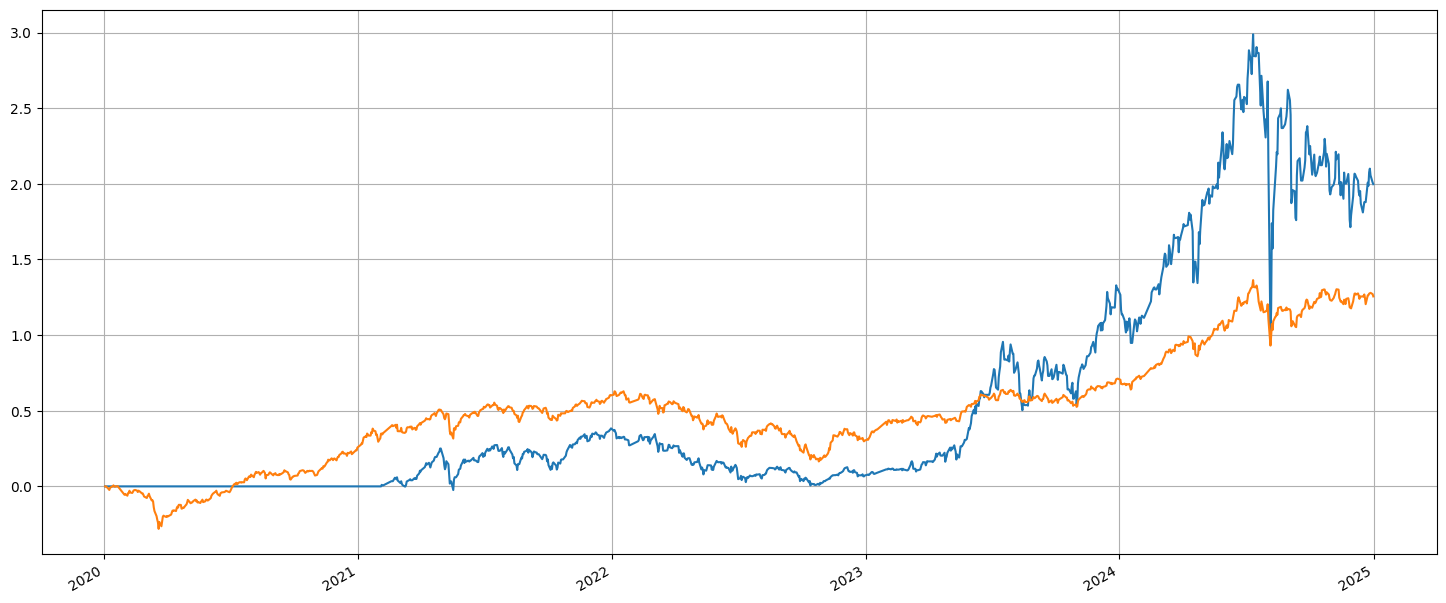

In [13]:
"""
Model Settings
"""
intial_portfolio = 50000000
minimum_momentum = 0
portfolio_size = 30

def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope,
            multiplied by the R2
    """
    # Note I: The easiest way to calculate exponential regression is to just do
    # a linear regression based on the log values
    #
    # Note II: Idea behind exponential regression: https://rpubs.com/mengxu/exponential-model

    # Make a list of consecutive numbers
    x = np.arange(len(ts))
    # Get logs
    log_ts = np.log(ts)
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    # Annualize percent
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    # Adjust for fitness
    score = annualized_slope * (r_value ** 2)
    return score

def initialize(context):
    
    # 設定 benchmark
    context.set_benchmark(symbol('IR0001'))
    # 交易成本
    context.enable_commission = False
    context.enable_slippage = False   
    
    if context.enable_commission:
        comm_model = PerContract(cost={'TX':200},exchange_fee=0)
    else:
        comm_model = PerContract(cost=0.0,exchange_fee=0)
        
    set_commission(futures=comm_model)
    
    if context.enable_slippage:
        slippage_model=FixedBasisPointsSlippage(basis_points=50, volume_limit=0.1) 
    else:
        slippage_model=FixedSlippage(spread=0.0)      
        
    set_slippage(futures=slippage_model)

    # Make a list of all the markets
    markets = [x for x in fut_universe ] # 'FFF','DFF','JFF','KFF'   if x not in ['HAF']
    
    # Make a list of all continuations
    context.universe = [
        continuous_future(market, offset=0, roll='calendar', adjustment='add')
            for market in markets
    ]
    # Schedule rebalance monthly.
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_close(),
    )

    # Schedule daily roll check
    schedule_function(roll_futures, date_rules.every_day(), time_rules.market_close())

    
def roll_futures(context, data):

    open_orders = get_open_orders()    
    # rolling positions
    for held_contract in context.portfolio.positions:
        if not isinstance(held_contract, Future):
            continue
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders: 
            continue
        # Save some time by only checking rolls for
        # contracts expiring in the next week         
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days
        if days_to_auto_close > 5:
            continue  
        # Make a continuation
        continuation = continuous_future(
                held_contract.root_symbol, 
                offset=0, 
                roll='calendar',
                adjustment='add'
                )
        # Get the current contract of the continuation
        continuation_contract = data.current(continuation, 'contract')
        # print(continuation_contract)  
        if continuation_contract != held_contract:
            # Check how many contracts we hold
            pos_size = context.portfolio.positions[held_contract].amount         
            # Close current position
            print(f'{held_contract} 平倉出場於轉倉')
            order_target(held_contract, 0)

            if continuation_contract is None or np.isnan(data.current(continuation_contract,'close'))==True:
                continue
                
            # Open new position
            print(f'{continuation_contract} 買進進場於轉倉')
            order_target(continuation_contract, pos_size)

def rebalance(context, data):
 
    momentum_list = {}
    # Iterate markets, check for trades
    for continuation in context.universe: 
        # Get root symbol of continuation
        root = continuation.root_symbol        
        try:
            h = data.history(
                        continuation, 
                        fields=['close'], 
                        frequency='1d', 
                        bar_count=250,
                        )
            if np.all(h.close.isna()): continue
        except Exception as e:
             continue            
        
        momentum_list[root] = momentum_score(h.close.values)
        
    # Sort by momentum value.
    momentum_list = pd.Series(momentum_list)
    ranking_table = momentum_list.sort_values(ascending=False).dropna()
    """
    Sell Logic
    
    First we check if any existing position should be sold.
    * Sell if stock is no longer part of index.
    * Sell if stock has too low momentum value.
    """
    # Make dictionary of open positions
    kept_positions = {pos.root_symbol: pos 
                        for pos in context.portfolio.positions
                     }     
    for contract in context.portfolio.positions:
        if contract.root_symbol not in ranking_table.index:
            if np.isnan(data.current(contract,'close'))==True:
                order_target_percent(contract, 0.0)
                kept_positions.pop(contract.root_symbol, None)  
            continue
        if ranking_table[contract.root_symbol] < minimum_momentum:
            order_target_percent(contract, 0.0)
            kept_positions.pop(contract.root_symbol, None)
    """
    Stock Selection Logic
    
    Check how many stocks we are keeping from last month.
    Fill from top of ranking list, until we reach the
    desired total number of portfolio holdings.
    """
    replacement_stocks = portfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[~ranking_table.index.isin(kept_positions.keys())][
        :replacement_stocks
    ]
    new_portfolio = pd.concat(
        (buy_list, ranking_table.loc[ranking_table.index.isin(kept_positions.keys())])
    )
    """
    Calculate inverse volatility for stocks, 
    and make target position weights.
    """
    for con_root_symbol, rank in new_portfolio.items():
        weight = 1 / (portfolio_size + 1)
        continuation = continuous_future(
                                        con_root_symbol, 
                                        offset=0, 
                                        roll='calendar',
                                        adjustment='add'
                                        )
        # Get the current contract of the continuation
        contract = data.current(continuation, 'contract')
        
        if con_root_symbol in kept_positions.keys():
            order_target_percent(kept_positions[con_root_symbol], weight)
        else:
            if ranking_table[con_root_symbol] > minimum_momentum:
                order_target_percent(contract, weight)

def analyze(context=None, results=None):
    # Plot the portfolio and asset data.
    results.algorithm_period_return.plot()
    results.benchmark_period_return.plot()
    plt.grid(True)
    # Show the plot.
    plt.gcf().set_size_inches(18, 8)
    plt.show()
    

capital_base = 50000000 
calendar_name = 'TEJ' 
start_dt = pd.Timestamp('2020-01-02', tz='utc') 
end_dt = pd.Timestamp('2024-12-31', tz='utc')

# Running a Backtest
results = run_algorithm(start=start_dt, 
                        end=end_dt, 
                        initialize=initialize, 
                        #handle_data = handle_data, 
                        capital_base=capital_base, 
                        data_frequency='daily', 
                        bundle='tquant_future', 
                        analyze = analyze,
                        trading_calendar=get_calendar(calendar_name), ) 


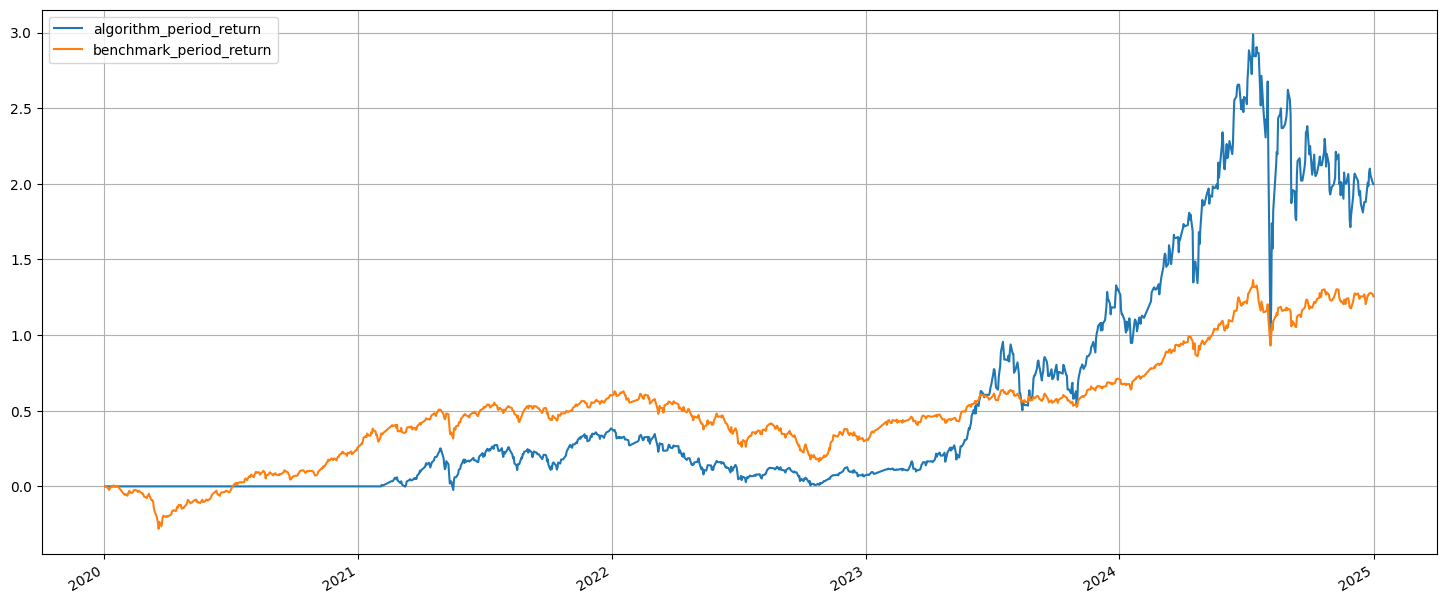

In [14]:
def analyze(context=None, results=None):
    # Plot the portfolio and asset data.
    results.algorithm_period_return.plot()
    results.benchmark_period_return.plot()
    plt.grid(True)
    # Show the plot.
    plt.gcf().set_size_inches(18, 8)
    plt.legend()
    plt.show()
analyze(results=results)